## Notebook to train an Advection-Aware AutoEncoder for parametric 1D Burgers equation


Consider the one-dimensional viscous Burgers' equation with Dirichlet boundary conditions which can be represented as 
\begin{align}
\dot{u} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},\\
u(x,0) = u_0, \qquad x \in [0,L], \qquad u(0,t) = u(L.t) = 0
\end{align}

Consider the initial condition
\begin{align}
u(x,0) = \frac{x}{1 + \sqrt{\frac{1}{t_0}} \exp{\left(Re \frac{x^2}{4} \right)}},
\end{align}

Set $L=1$ and maximum time $t_{max} = 2$. An analytical solution exists and is given by 
\begin{align}
u(x,t) =  \frac{\frac{x}{t+1}}{1 + \sqrt{\frac{t+1}{t_0}} \exp{\left(Re \frac{x^2}{4t+4} \right)}}
\end{align}

where $t_0 = \exp{(Re/8)}$ and $Re = 1/\nu$. 
The spatio-temporal domain $[0,L]\times[0,t_{max}]$ is uniformly discretized into $200$ grid points and $500$ time points.

In [1]:
## Load modules
%matplotlib inline

import numpy as np
import scipy
import os
import gc
import time
import importlib
from importlib import reload as reload
from pathlib import Path
import sys

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

import tensorflow as tf
print("Tensorflow v"+str(tf.__version__))
if tf.__version__ == '1.15.0':
    tf.compat.v1.enable_eager_execution()
elif tf.__version__.split('.')[0] == 2: # in ['2.2.0','2.3.0']:
    print("Setting Keras backend datatype")
    tf.keras.backend.set_floatx('float32')
    tf.debugging.set_log_device_placement(True)

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, # fontsize for x and y labels (was 10)
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x','D','H','v','*'])

try:
    base_dir.exists()
except:
    curr_dir = Path().resolve()
    base_dir = curr_dir.parent
data_dir = base_dir / "data" / "burgers1d"
fig_dir = base_dir / "figures"
utils_dir = base_dir / "src" / "utils"
nn_dir = base_dir / "src" / "nn_model"
work_dir = base_dir / "examples"
model_dir = base_dir / "data" / "saved_models" / "ae_param_models"

sys.path.append(str(utils_dir.absolute()))
sys.path.append(str(nn_dir.absolute()))

import data_utils as du
import tf_utils as tu
import plot_utils as pu
import aa_autoencoder as aa



Tensorflow v2.4.2


In [2]:
device = 'gpu:0' # select gpu:# or cpu:#
epochs_u = 5000

param_list = [50, 150, 300, 500, 400, 600]; flag = 'Re';    # Re as a parameter
param_train = [50, 150, 300, 500]; param_test = [400, 600 ]


In [3]:
## Load snapshot data
model ='Burgers1D'
soln_names = ['burgers']

snap_data = {}; times_offline = {}
Re = {}; 
snap_start = {}; snap_end = {}

for indx,val in enumerate(param_train):
    if flag == 'Re':
        datafile = 'Burgers1d_Nx200_Nt500_Re%.2f'%(val)+'.npz'
    data = np.load(os.path.join(data_dir, datafile))
   
    Re[indx] = float(datafile.split('_Re')[1].split('.npz')[0])
    print("\n%d: Loading snapshots for Re = %.2f "%(indx, Re[indx]))
    
    snap_data[indx], times_offline[indx], nodes, Nx, Ny, snap_start[indx], snap_end[indx] = du.read_data(data, soln_names)
    
del data
gc.collect()


0: Loading snapshots for Re = 50.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

1: Loading snapshots for Re = 150.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

2: Loading snapshots for Re = 300.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

3: Loading snapshots for Re = 500.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins


214

In [4]:
## Prepare training snapshots

Nn = Nx

## number of steps to skip in selecting training snapshots for SVD basis
snap_incr=2

## Fraction of time history to be used for training
tr_end = 1.0  ## For Model AA3
# tr_end = 0.9  ## For Model AA4


## Subsample snapshots for building reduced basis
Nt = {}
Nt_train = {}
train_end = {}
for indx,val in enumerate(param_train):
    Nt[indx] = times_offline[indx].size
    train_end[indx] = int(Nt[indx]*tr_end)
    Nt_train[indx] = times_offline[indx][:train_end[indx]+1:snap_incr].size
    print('{5}: Using {0} training snapshots for {1} = {2:.2f} in time interval [{3:.2f},{4:.2f}] mins'.format(
            Nt_train[indx], flag, param_train[indx], times_offline[indx][:train_end[indx]+1:snap_incr][0], 
            times_offline[indx][:train_end[indx]+1:snap_incr][-1], indx))



0: Using 250 training snapshots for Re = 50.00 in time interval [0.00,2.00] mins
1: Using 250 training snapshots for Re = 150.00 in time interval [0.00,2.00] mins
2: Using 250 training snapshots for Re = 300.00 in time interval [0.00,2.00] mins
3: Using 250 training snapshots for Re = 500.00 in time interval [0.00,2.00] mins


In [5]:
def set_label(key):
    if key == 'burgers':
        ky = 'u'
    
    return ky

In [6]:
## Load shifted snapshots   
print("Generating shifted snapshots -----\n")

shifted_snap = {}
for indx,val in enumerate(param_train):
    
    shifted_snap[indx] = {}
    for key in soln_names:
        tmp = snap_data[indx][key][:,int(Nt[indx]//2)]
        shifted_snap[indx][key] = np.outer(tmp,np.ones(Nt[indx]))

        print("%d: Generating %d shifted snapshots for Re = %d, key = %s"%(indx, 
                                                            shifted_snap[indx][key].shape[1], 
                                                            Re[indx], key))
        


Generating shifted snapshots -----

0: Generating 500 shifted snapshots for Re = 50, key = burgers
1: Generating 500 shifted snapshots for Re = 150, key = burgers
2: Generating 500 shifted snapshots for Re = 300, key = burgers
3: Generating 500 shifted snapshots for Re = 500, key = burgers


In [7]:
###  ***** Prepare Autoencoder input data *******
## 1. Concatenate parametric snapshots to prepare
##    input features for AA Autoencoder training

u = np.empty((0,Nn),)
u_shift = np.empty((0,Nn),)
key = soln_names[0]

for indx,val in enumerate(param_train):
    u_snap = snap_data[indx][key][:,:train_end[indx]+1:snap_incr].T    
    u = np.vstack((u,u_snap))
    u_shift_snap = shifted_snap[indx][key][:,:train_end[indx]+1:snap_incr].T
    u_shift = np.vstack((u_shift,u_shift_snap))
    

validation_data = True
skip_start = snap_incr//2
if validation_data:
    u_val = np.empty((0,Nn),)
    u_val_shift = np.empty((0,Nn),)
    for indx,val in enumerate(param_train):
        u_val_snap = snap_data[indx][key][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val_shift_snap = shifted_snap[indx][key][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val = np.vstack((u_val, u_val_snap))
        u_val_shift = np.vstack((u_val_shift, u_val_shift_snap))
    

In [8]:
## Scale Input Features to lie between [0,1]

scaling=True

if scaling:
    u, u_shift, u_max, u_min = du.data_scaler(u, u_shift)

    if validation_data:
        u_val, u_val_shift, _, _ = du.data_scaler(u_val, u_val_shift, u_max, u_min)
        
else:
    u_max = np.maximum(u.max(), u_shift.max()); u_min = np.minimum(u.min(), u_shift.min())

    

In [9]:
###  ***** Prepare Autoencoder input data *******
## 2. Augment input feature states with scaled 
##    parameter values

u_sigma = np.empty((0,1),)
u_shift_sigma = np.empty((0,1),)

p_max = np.asarray(param_list).max()
for indx,val in enumerate(param_train/p_max):
    u_sigma = np.vstack((u_sigma,val*np.ones((Nt_train[indx],1))))
    u_shift_sigma = np.vstack((u_shift_sigma,val*np.ones((Nt_train[indx],1)) ))
    
u = np.hstack(( u,u_sigma))
u_shift = np.hstack(( u_shift, u_shift_sigma))


if validation_data:
    u_val_sigma = np.empty((0,1),)
    u_val_shift_sigma = np.empty((0,1),)
    for indx,val in enumerate(param_train/p_max):
        val_steps = np.minimum(times_offline[indx][skip_start:train_end[indx]+1:snap_incr].size, Nt_train[indx])
        u_val_sigma = np.vstack((u_val_sigma, val*np.ones((val_steps,1)) ))
        u_val_shift_sigma = np.vstack((u_val_shift_sigma, val*np.ones((val_steps,1)) ))
        
        
    u_val = np.hstack(( u_val, u_val_sigma))
    u_val_shift = np.hstack(( u_val_shift, u_val_shift_sigma))


In [10]:
## Define minibatch generators for training and
## validation using Tensorflow Dataset API

batch_size = 24

size_buffer = max(list(Nt_train.values()))
    
u_training, u_validation = tu.gen_batch_ae(u, u_shift, u_val, u_val_shift, 
                                 batch_size=batch_size, shuffle_buffer=size_buffer)


In [11]:
## Design of the AA autoencoder sub-networks

size0 = u.shape[1]
size1 = int(np.floor(size0//2))
size2 = int(np.floor(size0//4))

size = np.array([size0, size1, size2])
latent_dim_u = 5
augment_output = True


print("Full order dimension: ",size0-1)
print("Latent dimension: ",latent_dim_u)


Full order dimension:  200
Latent dimension:  5


In [12]:
## Custom training loop for AA Autoencoder model

def train_AAautoencoder(epochs, train_dataset, val_dataset, latent_dim, actvn, size, Nt, 
                        augment_output = True, **kwargs):
    
    loss_wt = kwargs['loss_weights']
    model = aa.AAautoencoder(latent_dim, actvn, size, augment_output = augment_output)
    
    try:
        learn_rate = kwargs['lr']
    except:
        learn_rate = 0.0001
    try:
        batch_size = kwargs['batch_size']
    except:
        batch_size = 64
    try:
        reg_wt = kwargs['reg']
    except:
        reg_wt = 0.02
        
    try:
        lb = kwargs['loss_lb']
    except:
        lb = 0.9
        
    try:
        decay_factor = kwargs['decay'][0]; decay_rate = kwargs['decay'][1]
    except:
        decay_factor = 15; decay_rate = 0.9
    
    try: 
        learning_rate_decay = kwargs['lr_decay']
        init_learn_rate = tf.keras.optimizers.schedules.ExponentialDecay(learn_rate, 
                                                        decay_steps=epochs*Nt//batch_size//decay_factor,
                                                        decay_rate=decay_rate, staircase=True)
    except:
        init_learn_rate = learn_rate
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=init_learn_rate)
    

    train_loss = []
    val_loss = []
    shift_loss = []
    recon_loss = []
    lr = []
    regu_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        # Iterate over the batches of the dataset.
        train_loss_value = 0; 
        shift_loss_value = 0; 
        recon_loss_value = 0;
        rloss_value = 0
        for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
              
                ## Encoded output for this minibatch
                encoded = model.encoder(x_batch_train, training=True)
                
                ## Shift Decoder Evaluation for this minibatch
                pred = model.shift(encoded, training=True)  
                
                ## True Decoder Evaluation for this minibatch
                recon = model.decoder(encoded, training=True)
                
                ## L2 Regularization Loss Component
                l2_loss=tf.add_n(model.losses)
                
                ## Compute the loss value for this minibatch.
                if augment_output:
                    loss1 = tu.comb_loss(y_batch_train[:,:], pred, lb=lb, delta=0.5); #\
                    loss2 = tu.comb_loss(x_batch_train[:,:], recon, lb=lb, delta=0.5); #\
                else:
                    loss1 = tu.comb_loss(y_batch_train[:,:-1], pred, lb=lb, delta=0.5) #\
                    loss2 = tu.comb_loss(x_batch_train[:,:-1], recon, lb=lb, delta=0.5) #\
    
                if epoch < kwargs['segmented']:
                    loss_value = loss_wt[0] * loss1 + loss_wt[1] * loss2 
                else:
                    loss_value = loss_wt[2] * loss1 + loss_wt[3] * loss2
                
                reg_loss = reg_wt*tf.sqrt(l2_loss)/(epoch+1)
                loss_value += reg_loss
                rloss_value +=reg_loss
                       
            train_loss_value += loss_value
            shift_loss_value += loss1
            recon_loss_value += loss2
            
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_variables,
                        unconnected_gradients=tf.UnconnectedGradients.ZERO) 
            ## Suppress warnings about zero gradients during training
            
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Log every 10 batches.
            if step_train % 10 == 0:
                print("Training loss for batch %d: Shift: %.4e, Recon: %.4e, Reg: %.4e"
                    % ((step_train+1), float(loss1), float(loss2), float(reg_loss)))
                print("Seen so far: %s samples" % ((step_train + 1) * batch_size))
                
        train_loss.append((train_loss_value/(step_train + 1)).numpy())
        shift_loss.append((shift_loss_value/(step_train + 1)).numpy())
        recon_loss.append((recon_loss_value/(step_train + 1)).numpy())
        regu_loss.append((rloss_value/(step_train + 1)).numpy())
        
        # Run a validation loop at the end of each epoch.
        val_loss_value = 0; 
        for step_val, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            
            encoded_val = model.encoder(x_batch_val, training=False)
            pred_val = model.shift(encoded_val, training=False)
            recon_val = model.decoder(encoded_val, training=False)
            
            if augment_output:
                loss_val1 = tu.comb_loss(y_batch_val[:,:], pred_val, lb=lb,delta=0.5) #\
                loss_val2 = tu.comb_loss(x_batch_val[:,:], recon_val, lb=lb,delta=0.5) #\
            else:
                loss_val1 = tu.comb_loss(y_batch_val[:,:-1], pred_val, lb=lb,delta=0.5) #\
                loss_val2 = tu.comb_loss(x_batch_val[:,:-1], recon_val, lb=lb,delta=0.5) #\
                
            if epoch < kwargs['segmented']:
                val_loss_value += loss_wt[0] * loss_val1 + loss_wt[1] * loss_val2 
            else:
                val_loss_value += loss_wt[2] * loss_val1 + loss_wt[3] * loss_val2
        
        val_loss_value += rloss_value
        val_loss.append((val_loss_value/(step_val+1)).numpy())
        
        if learning_rate_decay:
            print("Epoch %d, Training Loss: %.4e, Validation Loss: %.4e. LR: %.4e" 
                  % (epoch, float(train_loss[-1]),float(val_loss[-1]),init_learn_rate(optimizer.iterations).numpy()))
            lr.append(init_learn_rate(optimizer.iterations).numpy())
        else:
            print("Epoch %d, Training Loss: %.4e, Validation Loss: %.4e. LR: %.4e" 
                  % (epoch, float(train_loss[-1]),float(val_loss[-1]),learn_rate))
            lr.append(learn_rate)

    
    end_time = time.time()
    print("****Total training time = {0}****\n".format(end_time - start_time))
    
    return model, train_loss, val_loss, shift_loss, recon_loss, lr


In [13]:
## Load AE model

load_ae_model = False

if load_ae_model:
    pre_trained_dir = model_dir / "saved_model_AA3"
#     pre_trained_dir = model_dir / "saved_model_AA4"

    mnum = str(pre_trained_dir).split('saved_model_')[1]

    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    
    u_autoencoder, model_training = aa.load_model(pre_trained_dir,mnum)
    
    print(model_training['msg'])

    loss_u = model_training['loss']
    vloss_u = model_training['valloss'] 
    sloss_u = model_training['shiftloss'] 
    rloss_u = model_training['reconloss'] 
    lr_u = model_training['lr']
    epochs_u = model_training['epochs']
    u_max = model_training['umax']
    u_min = model_training['umin']
    augment_output = model_training['augment']
    
    

In [14]:
## Training the AA Autoencoder Model
actvn = tf.keras.activations.swish

if not load_ae_model:
    init_time = time.time()
    
    #### Training model AA3
    init_lr = 5e-4
    u_autoencoder, loss_u, vloss_u, sloss_u, rloss_u, lr_u = train_AAautoencoder(epochs_u, 
                                              u_training, u_validation, 
                                              latent_dim_u, actvn, np.array([size[0], size[2], ]),
                                              sum(list(Nt_train.values())),
                                              augment_output = augment_output,
                                              batch_size = batch_size, loss_lb = 0.9,
                                              segmented = 1500, decay = [15, 0.9],
                                              loss_weights = [0.02, 0.96, 0.24, 0.74],
                                              lr = init_lr, lr_decay = True, reg = 0.02 )


#     #### Training model AA4
#     init_lr = 3e-4
#     u_autoencoder, loss_u, vloss_u, sloss_u, rloss_u, lr_u = train_AAautoencoder(epochs_u, 
#                                               u_training, u_validation, 
#                                               latent_dim_u, actvn, np.array([size[0], size[1], size[2], ]),
#                                               sum(list(Nt_train.values())),
#                                               augment_output = augment_output,
#                                               batch_size = batch_size, loss_lb = 0.9,
#                                               segmented = 1500, decay = [16, 0.9],
#                                               loss_weights = [0.02, 0.96, 0.14, 0.84],
#                                               lr = init_lr, lr_decay = True, reg = 0.02 )

      
    end_time = time.time()
    train_time = end_time - init_time
    mins = int(train_time//60); secs = int(train_time%60)
    print('Training time: %d M, %d S'%(mins,secs))


Start of epoch 0
Training loss for batch 1: Shift: 9.2490e-01, Recon: 9.1762e-01, Reg: 1.9801e-04
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.4507e-01, Recon: 8.3560e-01, Reg: 1.9801e-04
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.6051e-01, Recon: 6.2431e-01, Reg: 1.9834e-04
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.6037e-01, Recon: 5.4136e-01, Reg: 1.9899e-04
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.4443e-01, Recon: 3.1485e-01, Reg: 1.9949e-04
Seen so far: 984 samples
Epoch 0, Training Loss: 6.2878e-01, Validation Loss: 2.9970e-01. LR: 5.0000e-04

Start of epoch 1
Training loss for batch 1: Shift: 2.8537e-01, Recon: 3.4188e-01, Reg: 9.9771e-05
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7583e-01, Recon: 2.2185e-01, Reg: 9.9856e-05
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.7555e-02, Recon: 1.2212e-01, Reg: 9.9920e-05
Seen so far: 504 samples
Training loss for batch 31: Shif

Training loss for batch 1: Shift: 6.3275e-03, Recon: 7.7955e-03, Reg: 1.4367e-05
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.8317e-03, Recon: 3.1648e-02, Reg: 1.4375e-05
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2908e-02, Recon: 3.2752e-02, Reg: 1.4375e-05
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.2109e-02, Recon: 7.9654e-03, Reg: 1.4382e-05
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5634e-02, Recon: 4.7040e-02, Reg: 1.4384e-05
Seen so far: 984 samples
Epoch 13, Training Loss: 2.5401e-02, Validation Loss: 2.3287e-02. LR: 5.0000e-04

Start of epoch 14
Training loss for batch 1: Shift: 4.6970e-03, Recon: 2.0406e-02, Reg: 1.3427e-05
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.9784e-03, Recon: 9.4016e-03, Reg: 1.3435e-05
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2530e-02, Recon: 8.3763e-03, Reg: 1.3434e-05
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2904e-02, R

Training loss for batch 1: Shift: 4.2955e-02, Recon: 3.5526e-02, Reg: 7.5234e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.8897e-03, Recon: 3.2289e-03, Reg: 7.5238e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1477e-02, Recon: 1.4234e-02, Reg: 7.5255e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1352e-02, Recon: 8.9723e-03, Reg: 7.5266e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.4840e-03, Recon: 3.8390e-03, Reg: 7.5276e-06
Seen so far: 984 samples
Epoch 26, Training Loss: 1.3213e-02, Validation Loss: 1.2313e-02. LR: 5.0000e-04

Start of epoch 27
Training loss for batch 1: Shift: 6.5618e-03, Recon: 2.3719e-03, Reg: 7.2589e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0025e-03, Recon: 9.3866e-03, Reg: 7.2588e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0467e-02, Recon: 1.8846e-02, Reg: 7.2612e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3193e-03, R

Training loss for batch 31: Shift: 1.1147e-02, Recon: 1.2919e-02, Reg: 5.1135e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.3438e-03, Recon: 1.3737e-02, Reg: 5.1108e-06
Seen so far: 984 samples
Epoch 39, Training Loss: 1.0649e-02, Validation Loss: 9.7051e-03. LR: 5.0000e-04

Start of epoch 40
Training loss for batch 1: Shift: 8.3855e-03, Recon: 3.5605e-03, Reg: 4.9864e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.2381e-02, Recon: 3.4276e-02, Reg: 4.9837e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0280e-02, Recon: 2.5545e-02, Reg: 4.9852e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7743e-02, Recon: 1.1269e-02, Reg: 4.9905e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9126e-02, Recon: 7.0312e-03, Reg: 4.9895e-06
Seen so far: 984 samples
Epoch 40, Training Loss: 1.0246e-02, Validation Loss: 9.6225e-03. LR: 5.0000e-04

Start of epoch 41
Training loss for batch 1: Shift: 1.0723e-02, Recon: 

Training loss for batch 41: Shift: 5.5997e-03, Recon: 9.7515e-03, Reg: 3.8838e-06
Seen so far: 984 samples
Epoch 52, Training Loss: 7.6367e-03, Validation Loss: 7.0963e-03. LR: 5.0000e-04

Start of epoch 53
Training loss for batch 1: Shift: 4.2637e-03, Recon: 5.9297e-03, Reg: 3.8123e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.5247e-03, Recon: 5.4548e-03, Reg: 3.8147e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1648e-02, Recon: 2.9200e-02, Reg: 3.8157e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.7491e-03, Recon: 3.6538e-03, Reg: 3.8149e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7206e-03, Recon: 1.4521e-02, Reg: 3.8127e-06
Seen so far: 984 samples
Epoch 53, Training Loss: 7.3285e-03, Validation Loss: 7.1973e-03. LR: 5.0000e-04

Start of epoch 54
Training loss for batch 1: Shift: 3.9725e-03, Recon: 7.2131e-03, Reg: 3.7428e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.4131e-03, Recon: 1

Training loss for batch 41: Shift: 3.0461e-03, Recon: 9.2571e-03, Reg: 3.1361e-06
Seen so far: 984 samples
Epoch 65, Training Loss: 5.7858e-03, Validation Loss: 5.2569e-03. LR: 5.0000e-04

Start of epoch 66
Training loss for batch 1: Shift: 6.0964e-03, Recon: 5.2529e-03, Reg: 3.0899e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.9329e-03, Recon: 6.9951e-03, Reg: 3.0896e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.6498e-03, Recon: 1.2839e-02, Reg: 3.0895e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8098e-03, Recon: 9.1188e-03, Reg: 3.0902e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.5291e-03, Recon: 2.4757e-03, Reg: 3.0905e-06
Seen so far: 984 samples
Epoch 66, Training Loss: 5.6533e-03, Validation Loss: 5.1205e-03. LR: 5.0000e-04

Start of epoch 67
Training loss for batch 1: Shift: 2.2756e-03, Recon: 5.5227e-03, Reg: 3.0453e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3882e-03, Recon: 3

Epoch 78, Training Loss: 4.5538e-03, Validation Loss: 4.3444e-03. LR: 5.0000e-04

Start of epoch 79
Training loss for batch 1: Shift: 2.0782e-03, Recon: 2.8202e-03, Reg: 2.5991e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0536e-03, Recon: 3.1839e-03, Reg: 2.5991e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.7315e-03, Recon: 9.8984e-03, Reg: 2.5991e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2016e-03, Recon: 2.2156e-03, Reg: 2.6000e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.7923e-04, Recon: 1.0171e-03, Reg: 2.6002e-06
Seen so far: 984 samples
Epoch 79, Training Loss: 4.9115e-03, Validation Loss: 4.5851e-03. LR: 5.0000e-04

Start of epoch 80
Training loss for batch 1: Shift: 2.0340e-03, Recon: 4.2051e-03, Reg: 2.5679e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.7284e-03, Recon: 1.1022e-02, Reg: 2.5685e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.1102e-03, Recon: 1

Training loss for batch 1: Shift: 1.4806e-03, Recon: 2.5076e-03, Reg: 2.2447e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.4642e-04, Recon: 1.0177e-03, Reg: 2.2447e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4628e-03, Recon: 7.4159e-04, Reg: 2.2456e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.3758e-03, Recon: 1.1885e-02, Reg: 2.2470e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.3347e-03, Recon: 5.9113e-03, Reg: 2.2466e-06
Seen so far: 984 samples
Epoch 92, Training Loss: 4.1000e-03, Validation Loss: 3.6699e-03. LR: 5.0000e-04

Start of epoch 93
Training loss for batch 1: Shift: 8.5986e-03, Recon: 6.2009e-03, Reg: 2.2226e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.8055e-03, Recon: 2.0465e-03, Reg: 2.2226e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.7270e-03, Recon: 1.8328e-02, Reg: 2.2233e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8606e-03, R

Training loss for batch 21: Shift: 4.3491e-03, Recon: 2.7912e-03, Reg: 1.9800e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.7224e-03, Recon: 7.4291e-03, Reg: 1.9811e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.5492e-03, Recon: 7.2978e-03, Reg: 1.9820e-06
Seen so far: 984 samples
Epoch 105, Training Loss: 3.5404e-03, Validation Loss: 3.4480e-03. LR: 5.0000e-04

Start of epoch 106
Training loss for batch 1: Shift: 3.4527e-03, Recon: 5.1931e-03, Reg: 1.9635e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.3636e-03, Recon: 4.6694e-03, Reg: 1.9629e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.1612e-03, Recon: 1.8168e-03, Reg: 1.9628e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.2460e-04, Recon: 1.0785e-03, Reg: 1.9636e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5160e-03, Recon: 3.5579e-03, Reg: 1.9638e-06
Seen so far: 984 samples
Epoch 106, Training Loss: 3.3825e-03, Valida

Training loss for batch 21: Shift: 3.5358e-03, Recon: 1.8010e-03, Reg: 1.7725e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4427e-03, Recon: 3.6388e-03, Reg: 1.7727e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5800e-03, Recon: 1.3732e-03, Reg: 1.7731e-06
Seen so far: 984 samples
Epoch 118, Training Loss: 2.9699e-03, Validation Loss: 2.6850e-03. LR: 5.0000e-04

Start of epoch 119
Training loss for batch 1: Shift: 5.3965e-03, Recon: 4.9354e-03, Reg: 1.7586e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.7445e-03, Recon: 4.7109e-03, Reg: 1.7591e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8811e-03, Recon: 3.2013e-03, Reg: 1.7591e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.7253e-03, Recon: 4.2431e-03, Reg: 1.7600e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.5188e-04, Recon: 3.7610e-03, Reg: 1.7592e-06
Seen so far: 984 samples
Epoch 119, Training Loss: 2.9600e-03, Valida

Training loss for batch 21: Shift: 3.2439e-03, Recon: 3.7714e-03, Reg: 1.6075e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.4480e-03, Recon: 5.5079e-03, Reg: 1.6077e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1116e-03, Recon: 1.3373e-03, Reg: 1.6073e-06
Seen so far: 984 samples
Epoch 131, Training Loss: 2.5487e-03, Validation Loss: 2.1781e-03. LR: 5.0000e-04

Start of epoch 132
Training loss for batch 1: Shift: 6.1563e-04, Recon: 7.5622e-04, Reg: 1.5953e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3734e-03, Recon: 7.1260e-04, Reg: 1.5956e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4566e-03, Recon: 5.5560e-04, Reg: 1.5961e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5571e-03, Recon: 2.6442e-03, Reg: 1.5960e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4850e-03, Recon: 3.5711e-03, Reg: 1.5954e-06
Seen so far: 984 samples
Epoch 132, Training Loss: 2.6047e-03, Valida

Training loss for batch 31: Shift: 5.1726e-03, Recon: 1.4306e-03, Reg: 1.4695e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4470e-03, Recon: 1.3057e-03, Reg: 1.4702e-06
Seen so far: 984 samples
Epoch 144, Training Loss: 2.2050e-03, Validation Loss: 2.0983e-03. LR: 5.0000e-04

Start of epoch 145
Training loss for batch 1: Shift: 3.2854e-03, Recon: 2.8963e-03, Reg: 1.4602e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5858e-03, Recon: 1.3712e-03, Reg: 1.4607e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.8230e-04, Recon: 6.7919e-04, Reg: 1.4599e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.9960e-04, Recon: 1.6125e-03, Reg: 1.4600e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2538e-03, Recon: 1.4743e-03, Reg: 1.4603e-06
Seen so far: 984 samples
Epoch 145, Training Loss: 2.3397e-03, Validation Loss: 2.3307e-03. LR: 5.0000e-04

Start of epoch 146
Training loss for batch 1: Shift: 3.4595e-03, Rec

Training loss for batch 31: Shift: 4.4638e-03, Recon: 8.1771e-03, Reg: 1.3550e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5444e-03, Recon: 6.8313e-04, Reg: 1.3554e-06
Seen so far: 984 samples
Epoch 157, Training Loss: 2.4033e-03, Validation Loss: 2.5490e-03. LR: 5.0000e-04

Start of epoch 158
Training loss for batch 1: Shift: 7.0716e-04, Recon: 1.5208e-03, Reg: 1.3471e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2598e-03, Recon: 2.9804e-03, Reg: 1.3479e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.5182e-04, Recon: 3.4380e-04, Reg: 1.3480e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.7402e-03, Recon: 1.2555e-03, Reg: 1.3483e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.4427e-03, Recon: 2.9245e-03, Reg: 1.3484e-06
Seen so far: 984 samples
Epoch 158, Training Loss: 2.2494e-03, Validation Loss: 2.0651e-03. LR: 5.0000e-04

Start of epoch 159
Training loss for batch 1: Shift: 4.0385e-03, Rec

Training loss for batch 31: Shift: 1.6959e-03, Recon: 1.2661e-03, Reg: 1.2606e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1661e-03, Recon: 8.8357e-04, Reg: 1.2606e-06
Seen so far: 984 samples
Epoch 170, Training Loss: 1.8608e-03, Validation Loss: 1.6973e-03. LR: 5.0000e-04

Start of epoch 171
Training loss for batch 1: Shift: 1.1660e-03, Recon: 4.8610e-04, Reg: 1.2533e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.0881e-04, Recon: 5.1160e-04, Reg: 1.2535e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2854e-03, Recon: 6.4127e-04, Reg: 1.2536e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0340e-03, Recon: 1.2032e-03, Reg: 1.2538e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.9241e-03, Recon: 1.3350e-03, Reg: 1.2540e-06
Seen so far: 984 samples
Epoch 171, Training Loss: 1.8116e-03, Validation Loss: 1.6987e-03. LR: 5.0000e-04

Start of epoch 172
Training loss for batch 1: Shift: 9.3822e-04, Rec

Training loss for batch 31: Shift: 2.7075e-03, Recon: 7.0092e-03, Reg: 1.1764e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3036e-03, Recon: 8.7569e-04, Reg: 1.1761e-06
Seen so far: 984 samples
Epoch 183, Training Loss: 1.9243e-03, Validation Loss: 1.6401e-03. LR: 5.0000e-04

Start of epoch 184
Training loss for batch 1: Shift: 4.1726e-03, Recon: 1.7925e-03, Reg: 1.1696e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3051e-03, Recon: 1.6245e-03, Reg: 1.1695e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2884e-03, Recon: 7.3509e-04, Reg: 1.1701e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.4250e-04, Recon: 9.0776e-04, Reg: 1.1706e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3194e-03, Recon: 1.1886e-03, Reg: 1.1709e-06
Seen so far: 984 samples
Epoch 184, Training Loss: 1.9840e-03, Validation Loss: 1.8587e-03. LR: 5.0000e-04

Start of epoch 185
Training loss for batch 1: Shift: 1.3527e-03, Rec

Training loss for batch 41: Shift: 4.3182e-03, Recon: 4.9052e-03, Reg: 1.1046e-06
Seen so far: 984 samples
Epoch 196, Training Loss: 2.3103e-03, Validation Loss: 1.5898e-03. LR: 5.0000e-04

Start of epoch 197
Training loss for batch 1: Shift: 1.4132e-03, Recon: 5.7612e-04, Reg: 1.0989e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.5415e-04, Recon: 2.5119e-04, Reg: 1.0990e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1005e-03, Recon: 7.7486e-04, Reg: 1.0993e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.5667e-03, Recon: 4.8391e-03, Reg: 1.0991e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.5763e-04, Recon: 7.3619e-04, Reg: 1.0993e-06
Seen so far: 984 samples
Epoch 197, Training Loss: 1.6869e-03, Validation Loss: 1.4430e-03. LR: 5.0000e-04

Start of epoch 198
Training loss for batch 1: Shift: 4.0536e-03, Recon: 6.1340e-03, Reg: 1.0938e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3326e-03, Reco

Training loss for batch 41: Shift: 3.1045e-03, Recon: 4.3856e-03, Reg: 1.0406e-06
Seen so far: 984 samples
Epoch 209, Training Loss: 1.6323e-03, Validation Loss: 1.4355e-03. LR: 5.0000e-04

Start of epoch 210
Training loss for batch 1: Shift: 2.0192e-03, Recon: 7.3849e-04, Reg: 1.0357e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0678e-03, Recon: 1.6814e-03, Reg: 1.0361e-06
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.4588e-04, Recon: 2.6450e-03, Reg: 1.0359e-06
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4788e-03, Recon: 7.7769e-04, Reg: 1.0358e-06
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0046e-03, Recon: 9.1432e-04, Reg: 1.0351e-06
Seen so far: 984 samples
Epoch 210, Training Loss: 1.7588e-03, Validation Loss: 1.7732e-03. LR: 5.0000e-04

Start of epoch 211
Training loss for batch 1: Shift: 8.3058e-03, Recon: 1.1001e-03, Reg: 1.0302e-06
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0215e-03, Reco

Training loss for batch 1: Shift: 5.7224e-03, Recon: 2.5675e-03, Reg: 9.7993e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4081e-03, Recon: 1.8086e-03, Reg: 9.7968e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7838e-03, Recon: 1.1455e-03, Reg: 9.7995e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.6457e-03, Recon: 3.0679e-03, Reg: 9.8015e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.9849e-04, Recon: 5.6448e-04, Reg: 9.8032e-07
Seen so far: 984 samples
Epoch 223, Training Loss: 1.7057e-03, Validation Loss: 1.4019e-03. LR: 5.0000e-04

Start of epoch 224
Training loss for batch 1: Shift: 3.6874e-03, Recon: 4.1777e-04, Reg: 9.7600e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.7882e-03, Recon: 1.1751e-03, Reg: 9.7617e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0753e-03, Recon: 1.6612e-03, Reg: 9.7591e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.1760e-03,

Training loss for batch 1: Shift: 2.1171e-03, Recon: 1.1036e-03, Reg: 9.3000e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.8627e-03, Recon: 3.9761e-03, Reg: 9.2993e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1774e-03, Recon: 2.9538e-03, Reg: 9.2948e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0317e-03, Recon: 2.6041e-03, Reg: 9.2971e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2861e-03, Recon: 4.9576e-04, Reg: 9.3023e-07
Seen so far: 984 samples
Epoch 236, Training Loss: 1.6907e-03, Validation Loss: 1.5615e-03. LR: 5.0000e-04

Start of epoch 237
Training loss for batch 1: Shift: 3.4133e-03, Recon: 5.4686e-03, Reg: 9.2638e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.0348e-04, Recon: 5.6280e-04, Reg: 9.2665e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.4146e-04, Recon: 1.2942e-03, Reg: 9.2694e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3223e-03,

Training loss for batch 1: Shift: 7.2902e-04, Recon: 5.8847e-04, Reg: 8.8546e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1251e-03, Recon: 4.9604e-03, Reg: 8.8557e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.5981e-04, Recon: 9.7224e-04, Reg: 8.8563e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.0398e-03, Recon: 3.9289e-03, Reg: 8.8527e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7561e-03, Recon: 2.8615e-03, Reg: 8.8525e-07
Seen so far: 984 samples
Epoch 249, Training Loss: 1.3531e-03, Validation Loss: 1.1681e-03. LR: 5.0000e-04

Start of epoch 250
Training loss for batch 1: Shift: 4.4612e-04, Recon: 4.0488e-04, Reg: 8.8179e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7403e-03, Recon: 6.0062e-04, Reg: 8.8176e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.5086e-04, Recon: 1.2223e-03, Reg: 8.8202e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7843e-03,

Training loss for batch 1: Shift: 1.0135e-03, Recon: 2.1418e-03, Reg: 8.4442e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.1754e-03, Recon: 5.1313e-04, Reg: 8.4455e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5347e-03, Recon: 2.4002e-03, Reg: 8.4435e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.1622e-03, Recon: 4.1045e-03, Reg: 8.4437e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2311e-03, Recon: 2.3313e-03, Reg: 8.4448e-07
Seen so far: 984 samples
Epoch 262, Training Loss: 1.6106e-03, Validation Loss: 1.4250e-03. LR: 5.0000e-04

Start of epoch 263
Training loss for batch 1: Shift: 3.7284e-03, Recon: 4.8585e-03, Reg: 8.4113e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2499e-03, Recon: 1.5254e-03, Reg: 8.4117e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.5067e-03, Recon: 4.8520e-04, Reg: 8.4142e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.2018e-04,

Training loss for batch 1: Shift: 1.5642e-03, Recon: 5.7767e-04, Reg: 8.0758e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9608e-03, Recon: 5.4464e-04, Reg: 8.0757e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.7008e-03, Recon: 4.4731e-03, Reg: 8.0747e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7064e-03, Recon: 5.6561e-04, Reg: 8.0753e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.4248e-03, Recon: 1.3286e-03, Reg: 8.0795e-07
Seen so far: 984 samples
Epoch 275, Training Loss: 1.3677e-03, Validation Loss: 1.2468e-03. LR: 5.0000e-04

Start of epoch 276
Training loss for batch 1: Shift: 6.7307e-04, Recon: 8.7649e-04, Reg: 8.0504e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.7100e-04, Recon: 3.9238e-04, Reg: 8.0515e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0910e-03, Recon: 4.9751e-04, Reg: 8.0531e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7731e-03,

Training loss for batch 1: Shift: 2.4522e-04, Recon: 3.7194e-04, Reg: 7.7464e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.4858e-04, Recon: 3.4809e-04, Reg: 7.7418e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.9390e-04, Recon: 2.0071e-03, Reg: 7.7416e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.2406e-04, Recon: 4.7826e-04, Reg: 7.7434e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.9547e-04, Recon: 4.0168e-04, Reg: 7.7445e-07
Seen so far: 984 samples
Epoch 288, Training Loss: 1.3334e-03, Validation Loss: 1.0491e-03. LR: 5.0000e-04

Start of epoch 289
Training loss for batch 1: Shift: 3.2893e-03, Recon: 2.1615e-03, Reg: 7.7183e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.3206e-04, Recon: 8.3360e-04, Reg: 7.7189e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.4548e-04, Recon: 6.4188e-04, Reg: 7.7180e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.9229e-04,

Training loss for batch 1: Shift: 1.7817e-03, Recon: 1.3867e-03, Reg: 7.4298e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.8170e-04, Recon: 1.6517e-03, Reg: 7.4323e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6213e-03, Recon: 4.5511e-04, Reg: 7.4306e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.7749e-04, Recon: 5.4315e-04, Reg: 7.4323e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4058e-03, Recon: 2.1609e-04, Reg: 7.4341e-07
Seen so far: 984 samples
Epoch 301, Training Loss: 1.2914e-03, Validation Loss: 9.6303e-04. LR: 5.0000e-04

Start of epoch 302
Training loss for batch 1: Shift: 1.1954e-04, Recon: 8.9855e-05, Reg: 7.4090e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.3799e-04, Recon: 1.0094e-04, Reg: 7.4088e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3304e-03, Recon: 1.2873e-03, Reg: 7.4101e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.3706e-03,

Training loss for batch 1: Shift: 5.4500e-04, Recon: 3.4881e-04, Reg: 7.1538e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5146e-03, Recon: 1.0569e-03, Reg: 7.1550e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0160e-03, Recon: 1.4957e-03, Reg: 7.1573e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.4747e-03, Recon: 2.5036e-03, Reg: 7.1586e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0133e-03, Recon: 7.3982e-04, Reg: 7.1589e-07
Seen so far: 984 samples
Epoch 314, Training Loss: 1.1680e-03, Validation Loss: 1.2065e-03. LR: 5.0000e-04

Start of epoch 315
Training loss for batch 1: Shift: 1.5552e-03, Recon: 1.8040e-03, Reg: 7.1357e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.8139e-04, Recon: 7.8808e-04, Reg: 7.1335e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0033e-03, Recon: 1.6344e-03, Reg: 7.1323e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1509e-04,

Training loss for batch 1: Shift: 1.3837e-03, Recon: 5.7353e-04, Reg: 6.8956e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.8028e-04, Recon: 8.8213e-04, Reg: 6.8975e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0061e-03, Recon: 3.7419e-03, Reg: 6.8994e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.3655e-04, Recon: 1.1199e-03, Reg: 6.8993e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8126e-03, Recon: 2.6876e-03, Reg: 6.8987e-07
Seen so far: 984 samples
Epoch 327, Training Loss: 1.0047e-03, Validation Loss: 9.2051e-04. LR: 5.0000e-04

Start of epoch 328
Training loss for batch 1: Shift: 5.2577e-04, Recon: 3.5325e-04, Reg: 6.8780e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.8863e-04, Recon: 5.3190e-04, Reg: 6.8793e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0905e-03, Recon: 6.8221e-04, Reg: 6.8814e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.1888e-04,

Training loss for batch 1: Shift: 9.4769e-04, Recon: 1.0040e-03, Reg: 6.6587e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5472e-03, Recon: 1.9946e-04, Reg: 6.6623e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8417e-03, Recon: 2.3157e-03, Reg: 6.6649e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8098e-03, Recon: 3.1005e-03, Reg: 6.6649e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9734e-03, Recon: 2.3429e-03, Reg: 6.6613e-07
Seen so far: 984 samples
Epoch 340, Training Loss: 1.0674e-03, Validation Loss: 9.3936e-04. LR: 4.5000e-04

Start of epoch 341
Training loss for batch 1: Shift: 1.0191e-04, Recon: 2.4133e-04, Reg: 6.6413e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.2565e-04, Recon: 4.2320e-04, Reg: 6.6439e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.1215e-04, Recon: 3.5007e-04, Reg: 6.6459e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.4725e-04,

Training loss for batch 21: Shift: 5.4413e-04, Recon: 5.5337e-04, Reg: 6.4461e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8584e-04, Recon: 2.3385e-04, Reg: 6.4462e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.1895e-03, Recon: 2.2186e-03, Reg: 6.4475e-07
Seen so far: 984 samples
Epoch 353, Training Loss: 9.4092e-04, Validation Loss: 9.3482e-04. LR: 4.5000e-04

Start of epoch 354
Training loss for batch 1: Shift: 5.9475e-04, Recon: 1.0307e-03, Reg: 6.4293e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.0139e-04, Recon: 3.9975e-04, Reg: 6.4302e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.0579e-04, Recon: 4.2792e-04, Reg: 6.4306e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.4546e-05, Recon: 1.1856e-04, Reg: 6.4314e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9292e-03, Recon: 2.6246e-03, Reg: 6.4296e-07
Seen so far: 984 samples
Epoch 354, Training Loss: 9.0256e-04, Valida

Training loss for batch 31: Shift: 4.8847e-03, Recon: 2.3784e-03, Reg: 6.2293e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5793e-03, Recon: 2.6362e-03, Reg: 6.2320e-07
Seen so far: 984 samples
Epoch 366, Training Loss: 9.5947e-04, Validation Loss: 9.1587e-04. LR: 4.5000e-04

Start of epoch 367
Training loss for batch 1: Shift: 2.6477e-03, Recon: 1.3425e-03, Reg: 6.2148e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4660e-03, Recon: 3.7735e-04, Reg: 6.2155e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.3467e-04, Recon: 6.7207e-04, Reg: 6.2164e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4216e-03, Recon: 3.8450e-04, Reg: 6.2172e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.9657e-04, Recon: 3.6511e-04, Reg: 6.2175e-07
Seen so far: 984 samples
Epoch 367, Training Loss: 9.7760e-04, Validation Loss: 7.7580e-04. LR: 4.5000e-04

Start of epoch 368
Training loss for batch 1: Shift: 4.3894e-04, Rec

Training loss for batch 31: Shift: 1.8838e-03, Recon: 4.4288e-04, Reg: 6.0403e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6294e-03, Recon: 2.6107e-03, Reg: 6.0416e-07
Seen so far: 984 samples
Epoch 379, Training Loss: 1.0670e-03, Validation Loss: 9.5648e-04. LR: 4.5000e-04

Start of epoch 380
Training loss for batch 1: Shift: 4.0710e-04, Recon: 3.9220e-04, Reg: 6.0257e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.3656e-04, Recon: 5.2366e-04, Reg: 6.0246e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0131e-03, Recon: 1.3504e-03, Reg: 6.0253e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.1946e-04, Recon: 2.0920e-03, Reg: 6.0271e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.2889e-04, Recon: 6.6987e-04, Reg: 6.0257e-07
Seen so far: 984 samples
Epoch 380, Training Loss: 1.0959e-03, Validation Loss: 7.9528e-04. LR: 4.5000e-04

Start of epoch 381
Training loss for batch 1: Shift: 3.7383e-04, Rec

Training loss for batch 31: Shift: 4.4783e-04, Recon: 4.9342e-04, Reg: 5.8602e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0970e-03, Recon: 1.1648e-03, Reg: 5.8609e-07
Seen so far: 984 samples
Epoch 392, Training Loss: 9.2092e-04, Validation Loss: 7.3574e-04. LR: 4.5000e-04

Start of epoch 393
Training loss for batch 1: Shift: 3.4185e-03, Recon: 4.6565e-04, Reg: 5.8461e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.8804e-04, Recon: 9.8873e-04, Reg: 5.8467e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4988e-03, Recon: 1.0161e-03, Reg: 5.8478e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9940e-03, Recon: 3.1275e-03, Reg: 5.8477e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.5352e-04, Recon: 1.2769e-03, Reg: 5.8471e-07
Seen so far: 984 samples
Epoch 393, Training Loss: 8.2084e-04, Validation Loss: 7.5101e-04. LR: 4.5000e-04

Start of epoch 394
Training loss for batch 1: Shift: 1.2038e-04, Rec

Training loss for batch 31: Shift: 6.9293e-04, Recon: 1.4192e-03, Reg: 5.6888e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9767e-04, Recon: 1.3260e-03, Reg: 5.6895e-07
Seen so far: 984 samples
Epoch 405, Training Loss: 1.0520e-03, Validation Loss: 9.0257e-04. LR: 4.5000e-04

Start of epoch 406
Training loss for batch 1: Shift: 3.9775e-04, Recon: 2.7568e-04, Reg: 5.6753e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2562e-03, Recon: 1.2516e-03, Reg: 5.6745e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7568e-04, Recon: 3.1893e-04, Reg: 5.6736e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3822e-03, Recon: 1.3604e-03, Reg: 5.6743e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.9592e-04, Recon: 4.9435e-04, Reg: 5.6759e-07
Seen so far: 984 samples
Epoch 406, Training Loss: 9.2833e-04, Validation Loss: 8.3167e-04. LR: 4.5000e-04

Start of epoch 407
Training loss for batch 1: Shift: 1.5478e-03, Rec

Epoch 418, Training Loss: 8.2039e-04, Validation Loss: 9.7825e-04. LR: 4.5000e-04

Start of epoch 419
Training loss for batch 1: Shift: 8.8044e-05, Recon: 1.4217e-04, Reg: 5.5163e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9073e-03, Recon: 3.4948e-03, Reg: 5.5151e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.2344e-04, Recon: 8.9110e-04, Reg: 5.5145e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.6032e-04, Recon: 2.0509e-04, Reg: 5.5169e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9173e-03, Recon: 1.0261e-03, Reg: 5.5172e-07
Seen so far: 984 samples
Epoch 419, Training Loss: 9.0476e-04, Validation Loss: 7.2167e-04. LR: 4.5000e-04

Start of epoch 420
Training loss for batch 1: Shift: 5.5766e-03, Recon: 6.8461e-04, Reg: 5.5045e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.9774e-04, Recon: 3.2049e-04, Reg: 5.5053e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.3478e-03, Reco

Training loss for batch 1: Shift: 3.1435e-04, Recon: 3.8735e-04, Reg: 5.3693e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.5688e-04, Recon: 1.8468e-03, Reg: 5.3687e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.9592e-04, Recon: 4.4913e-04, Reg: 5.3686e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.1778e-03, Recon: 3.3596e-03, Reg: 5.3697e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.0301e-04, Recon: 7.0881e-04, Reg: 5.3713e-07
Seen so far: 984 samples
Epoch 432, Training Loss: 9.0091e-04, Validation Loss: 8.4503e-04. LR: 4.5000e-04

Start of epoch 433
Training loss for batch 1: Shift: 9.6292e-04, Recon: 6.6479e-04, Reg: 5.3585e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5796e-04, Recon: 9.7019e-04, Reg: 5.3580e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.6615e-04, Recon: 1.4659e-04, Reg: 5.3582e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0151e-03,

Training loss for batch 11: Shift: 4.1919e-04, Recon: 2.7335e-04, Reg: 5.2297e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9732e-04, Recon: 1.3450e-03, Reg: 5.2309e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0345e-04, Recon: 2.9022e-04, Reg: 5.2324e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0514e-03, Recon: 9.6286e-04, Reg: 5.2316e-07
Seen so far: 984 samples
Epoch 445, Training Loss: 9.5352e-04, Validation Loss: 9.1044e-04. LR: 4.5000e-04

Start of epoch 446
Training loss for batch 1: Shift: 1.6123e-03, Recon: 2.5315e-03, Reg: 5.2196e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.1265e-04, Recon: 2.6819e-04, Reg: 5.2179e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2857e-04, Recon: 2.8071e-04, Reg: 5.2191e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8301e-03, Recon: 5.0881e-04, Reg: 5.2225e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2871e-0

Training loss for batch 11: Shift: 9.3135e-04, Recon: 1.4929e-03, Reg: 5.0971e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7050e-04, Recon: 9.0799e-04, Reg: 5.0960e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3909e-03, Recon: 3.1247e-03, Reg: 5.0943e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.9609e-04, Recon: 8.5039e-04, Reg: 5.0947e-07
Seen so far: 984 samples
Epoch 458, Training Loss: 9.2884e-04, Validation Loss: 7.3834e-04. LR: 4.5000e-04

Start of epoch 459
Training loss for batch 1: Shift: 1.6768e-04, Recon: 3.0619e-04, Reg: 5.0836e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.8241e-04, Recon: 6.8067e-04, Reg: 5.0856e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.5468e-04, Recon: 2.1631e-03, Reg: 5.0875e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2866e-04, Recon: 3.2866e-04, Reg: 5.0862e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4192e-0

Training loss for batch 31: Shift: 3.7876e-04, Recon: 5.0067e-04, Reg: 4.9701e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6563e-03, Recon: 1.6252e-03, Reg: 4.9696e-07
Seen so far: 984 samples
Epoch 471, Training Loss: 8.9727e-04, Validation Loss: 7.5842e-04. LR: 4.5000e-04

Start of epoch 472
Training loss for batch 1: Shift: 1.8102e-04, Recon: 2.9512e-04, Reg: 4.9592e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.8127e-04, Recon: 6.8908e-04, Reg: 4.9615e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.2065e-04, Recon: 2.2583e-04, Reg: 4.9621e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.2990e-04, Recon: 4.6619e-04, Reg: 4.9614e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4039e-04, Recon: 8.9924e-04, Reg: 4.9610e-07
Seen so far: 984 samples
Epoch 472, Training Loss: 7.6493e-04, Validation Loss: 6.5070e-04. LR: 4.5000e-04

Start of epoch 473
Training loss for batch 1: Shift: 1.2729e-03, Rec

Training loss for batch 31: Shift: 2.4448e-04, Recon: 9.6062e-05, Reg: 4.8538e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.3877e-04, Recon: 2.9408e-04, Reg: 4.8535e-07
Seen so far: 984 samples
Epoch 484, Training Loss: 7.5163e-04, Validation Loss: 6.3666e-04. LR: 4.5000e-04

Start of epoch 485
Training loss for batch 1: Shift: 5.3916e-04, Recon: 2.0958e-04, Reg: 4.8434e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.5193e-04, Recon: 5.0340e-04, Reg: 4.8444e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.6243e-04, Recon: 8.2696e-05, Reg: 4.8461e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.7578e-04, Recon: 7.8751e-04, Reg: 4.8468e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.8622e-03, Recon: 1.2207e-03, Reg: 4.8438e-07
Seen so far: 984 samples
Epoch 485, Training Loss: 7.7443e-04, Validation Loss: 9.5137e-04. LR: 4.5000e-04

Start of epoch 486
Training loss for batch 1: Shift: 8.9135e-04, Rec

Epoch 497, Training Loss: 7.7364e-04, Validation Loss: 7.8296e-04. LR: 4.5000e-04

Start of epoch 498
Training loss for batch 1: Shift: 1.3766e-04, Recon: 3.0057e-04, Reg: 4.7334e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.3443e-04, Recon: 3.1424e-04, Reg: 4.7347e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7944e-04, Recon: 1.9616e-04, Reg: 4.7346e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6622e-03, Recon: 8.7964e-04, Reg: 4.7341e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5983e-03, Recon: 1.0308e-03, Reg: 4.7330e-07
Seen so far: 984 samples
Epoch 498, Training Loss: 7.5223e-04, Validation Loss: 6.5443e-04. LR: 4.5000e-04

Start of epoch 499
Training loss for batch 1: Shift: 5.3522e-04, Recon: 7.4533e-04, Reg: 4.7235e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.6454e-04, Recon: 4.2462e-04, Reg: 4.7221e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7898e-04, Reco

Training loss for batch 11: Shift: 5.4904e-04, Recon: 2.7295e-04, Reg: 4.6305e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1013e-03, Recon: 7.6715e-04, Reg: 4.6322e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.9544e-04, Recon: 4.7405e-04, Reg: 4.6333e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8726e-03, Recon: 1.3978e-03, Reg: 4.6328e-07
Seen so far: 984 samples
Epoch 511, Training Loss: 1.0763e-03, Validation Loss: 1.0269e-03. LR: 4.5000e-04

Start of epoch 512
Training loss for batch 1: Shift: 2.4637e-04, Recon: 2.6294e-04, Reg: 4.6235e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.8272e-04, Recon: 8.0787e-04, Reg: 4.6230e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1583e-04, Recon: 2.7223e-04, Reg: 4.6238e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8546e-04, Recon: 1.5376e-04, Reg: 4.6256e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.3758e-0

Training loss for batch 11: Shift: 9.6834e-04, Recon: 1.7172e-03, Reg: 4.5273e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0426e-03, Recon: 1.0219e-03, Reg: 4.5279e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8390e-04, Recon: 1.3462e-04, Reg: 4.5280e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.0681e-04, Recon: 3.0023e-04, Reg: 4.5276e-07
Seen so far: 984 samples
Epoch 524, Training Loss: 5.9387e-04, Validation Loss: 5.2333e-04. LR: 4.5000e-04

Start of epoch 525
Training loss for batch 1: Shift: 3.6913e-04, Recon: 3.9980e-04, Reg: 4.5192e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.8414e-04, Recon: 2.1757e-04, Reg: 4.5191e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2155e-04, Recon: 1.1686e-04, Reg: 4.5207e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5070e-04, Recon: 2.4077e-04, Reg: 4.5202e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6666e-0

Training loss for batch 11: Shift: 7.0930e-04, Recon: 1.6559e-04, Reg: 4.4358e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.4088e-04, Recon: 8.9620e-04, Reg: 4.4345e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.9468e-04, Recon: 4.7859e-04, Reg: 4.4360e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1495e-03, Recon: 6.8814e-04, Reg: 4.4370e-07
Seen so far: 984 samples
Epoch 537, Training Loss: 6.7799e-04, Validation Loss: 5.9222e-04. LR: 4.5000e-04

Start of epoch 538
Training loss for batch 1: Shift: 3.8895e-04, Recon: 6.5607e-04, Reg: 4.4291e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4323e-04, Recon: 4.3607e-04, Reg: 4.4303e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0182e-04, Recon: 9.7436e-05, Reg: 4.4312e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.4381e-04, Recon: 4.9099e-04, Reg: 4.4318e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0186e-0

Training loss for batch 31: Shift: 8.3833e-04, Recon: 1.2828e-03, Reg: 4.3414e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.6481e-04, Recon: 3.1864e-04, Reg: 4.3424e-07
Seen so far: 984 samples
Epoch 550, Training Loss: 6.0594e-04, Validation Loss: 4.9700e-04. LR: 4.5000e-04

Start of epoch 551
Training loss for batch 1: Shift: 9.5074e-04, Recon: 6.0092e-04, Reg: 4.3348e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.3115e-05, Recon: 1.9446e-04, Reg: 4.3352e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5921e-04, Recon: 1.3896e-03, Reg: 4.3346e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.4485e-04, Recon: 1.2899e-03, Reg: 4.3342e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.3080e-04, Recon: 7.4188e-04, Reg: 4.3353e-07
Seen so far: 984 samples
Epoch 551, Training Loss: 5.8577e-04, Validation Loss: 6.2613e-04. LR: 4.5000e-04

Start of epoch 552
Training loss for batch 1: Shift: 9.9954e-04, Rec

Training loss for batch 31: Shift: 1.4931e-03, Recon: 9.4091e-04, Reg: 4.2532e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.1803e-04, Recon: 4.1990e-04, Reg: 4.2553e-07
Seen so far: 984 samples
Epoch 563, Training Loss: 6.8868e-04, Validation Loss: 5.8812e-04. LR: 4.5000e-04

Start of epoch 564
Training loss for batch 1: Shift: 2.0283e-04, Recon: 3.0620e-04, Reg: 4.2477e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6075e-04, Recon: 3.9972e-04, Reg: 4.2483e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5610e-04, Recon: 1.4822e-03, Reg: 4.2484e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8989e-04, Recon: 5.4554e-04, Reg: 4.2469e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8957e-03, Recon: 1.2523e-03, Reg: 4.2475e-07
Seen so far: 984 samples
Epoch 564, Training Loss: 7.1751e-04, Validation Loss: 5.5898e-04. LR: 4.5000e-04

Start of epoch 565
Training loss for batch 1: Shift: 5.9644e-04, Rec

Training loss for batch 31: Shift: 1.5477e-04, Recon: 3.4301e-04, Reg: 4.1692e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.4661e-04, Recon: 2.9837e-04, Reg: 4.1694e-07
Seen so far: 984 samples
Epoch 576, Training Loss: 5.7839e-04, Validation Loss: 5.5406e-04. LR: 4.5000e-04

Start of epoch 577
Training loss for batch 1: Shift: 7.0721e-04, Recon: 1.5924e-04, Reg: 4.1623e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.2779e-04, Recon: 1.0647e-03, Reg: 4.1638e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.9944e-04, Recon: 7.2077e-04, Reg: 4.1632e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.7867e-04, Recon: 4.2652e-04, Reg: 4.1637e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.1647e-04, Recon: 1.9819e-03, Reg: 4.1635e-07
Seen so far: 984 samples
Epoch 577, Training Loss: 6.1356e-04, Validation Loss: 5.7740e-04. LR: 4.5000e-04

Start of epoch 578
Training loss for batch 1: Shift: 2.2681e-04, Rec

Training loss for batch 31: Shift: 1.2842e-03, Recon: 1.5565e-03, Reg: 4.0877e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.1702e-04, Recon: 1.3384e-03, Reg: 4.0877e-07
Seen so far: 984 samples
Epoch 589, Training Loss: 7.4154e-04, Validation Loss: 7.6347e-04. LR: 4.5000e-04

Start of epoch 590
Training loss for batch 1: Shift: 4.2006e-04, Recon: 4.0276e-04, Reg: 4.0810e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.6455e-04, Recon: 1.2026e-03, Reg: 4.0812e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.0771e-04, Recon: 3.9183e-04, Reg: 4.0807e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.2338e-04, Recon: 3.3504e-04, Reg: 4.0805e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.8411e-04, Recon: 2.0495e-04, Reg: 4.0812e-07
Seen so far: 984 samples
Epoch 590, Training Loss: 5.9482e-04, Validation Loss: 6.8913e-04. LR: 4.5000e-04

Start of epoch 591
Training loss for batch 1: Shift: 8.5732e-04, Rec

Training loss for batch 31: Shift: 4.3087e-04, Recon: 1.3100e-04, Reg: 4.0134e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.0848e-04, Recon: 1.2889e-03, Reg: 4.0131e-07
Seen so far: 984 samples
Epoch 602, Training Loss: 5.2941e-04, Validation Loss: 5.3118e-04. LR: 4.5000e-04

Start of epoch 603
Training loss for batch 1: Shift: 1.7122e-04, Recon: 2.4028e-04, Reg: 4.0064e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.6993e-04, Recon: 3.2658e-04, Reg: 4.0068e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.8378e-04, Recon: 7.0730e-04, Reg: 4.0072e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2052e-03, Recon: 1.1125e-03, Reg: 4.0071e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3626e-03, Recon: 1.8770e-03, Reg: 4.0055e-07
Seen so far: 984 samples
Epoch 603, Training Loss: 5.7499e-04, Validation Loss: 5.1788e-04. LR: 4.5000e-04

Start of epoch 604
Training loss for batch 1: Shift: 5.7880e-04, Rec

Training loss for batch 31: Shift: 5.4562e-04, Recon: 2.6697e-04, Reg: 3.9408e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.5697e-04, Recon: 1.7098e-03, Reg: 3.9403e-07
Seen so far: 984 samples
Epoch 615, Training Loss: 5.8757e-04, Validation Loss: 4.4454e-04. LR: 4.5000e-04

Start of epoch 616
Training loss for batch 1: Shift: 1.5321e-03, Recon: 8.5368e-04, Reg: 3.9338e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.7843e-04, Recon: 8.2327e-04, Reg: 3.9343e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5305e-04, Recon: 4.1761e-04, Reg: 3.9342e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.3554e-04, Recon: 2.9826e-04, Reg: 3.9341e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.9844e-04, Recon: 2.8912e-04, Reg: 3.9349e-07
Seen so far: 984 samples
Epoch 616, Training Loss: 5.2870e-04, Validation Loss: 5.4957e-04. LR: 4.5000e-04

Start of epoch 617
Training loss for batch 1: Shift: 9.5586e-04, Rec

Training loss for batch 31: Shift: 1.1872e-03, Recon: 4.1756e-04, Reg: 3.8692e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0373e-03, Recon: 7.6539e-04, Reg: 3.8704e-07
Seen so far: 984 samples
Epoch 628, Training Loss: 5.5198e-04, Validation Loss: 4.2160e-04. LR: 4.5000e-04

Start of epoch 629
Training loss for batch 1: Shift: 3.6114e-04, Recon: 2.5723e-04, Reg: 3.8643e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.7082e-04, Recon: 2.6840e-04, Reg: 3.8639e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.3143e-04, Recon: 4.5087e-04, Reg: 3.8646e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0571e-03, Recon: 3.8451e-04, Reg: 3.8647e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.1742e-04, Recon: 3.0273e-04, Reg: 3.8639e-07
Seen so far: 984 samples
Epoch 629, Training Loss: 5.4727e-04, Validation Loss: 4.8397e-04. LR: 4.5000e-04

Start of epoch 630
Training loss for batch 1: Shift: 2.7237e-04, Rec

Training loss for batch 31: Shift: 2.9248e-04, Recon: 2.3455e-04, Reg: 3.8042e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7529e-04, Recon: 5.3404e-04, Reg: 3.8039e-07
Seen so far: 984 samples
Epoch 641, Training Loss: 4.9855e-04, Validation Loss: 4.0613e-04. LR: 4.5000e-04

Start of epoch 642
Training loss for batch 1: Shift: 6.7002e-04, Recon: 6.4042e-04, Reg: 3.7980e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4763e-04, Recon: 7.7263e-04, Reg: 3.7975e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.5978e-04, Recon: 6.1505e-04, Reg: 3.7986e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.9917e-04, Recon: 1.3232e-04, Reg: 3.7993e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3482e-03, Recon: 1.4037e-03, Reg: 3.7992e-07
Seen so far: 984 samples
Epoch 642, Training Loss: 5.1571e-04, Validation Loss: 5.1990e-04. LR: 4.5000e-04

Start of epoch 643
Training loss for batch 1: Shift: 6.4986e-04, Rec

Training loss for batch 31: Shift: 2.3622e-04, Recon: 5.6083e-04, Reg: 3.7475e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7748e-04, Recon: 2.1126e-04, Reg: 3.7475e-07
Seen so far: 984 samples
Epoch 654, Training Loss: 4.6352e-04, Validation Loss: 3.8566e-04. LR: 4.5000e-04

Start of epoch 655
Training loss for batch 1: Shift: 1.7049e-04, Recon: 4.8649e-04, Reg: 3.7419e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1901e-04, Recon: 7.8464e-05, Reg: 3.7421e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.2807e-04, Recon: 1.3063e-03, Reg: 3.7418e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.1728e-04, Recon: 3.1627e-04, Reg: 3.7420e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.3045e-04, Recon: 2.3109e-04, Reg: 3.7418e-07
Seen so far: 984 samples
Epoch 655, Training Loss: 4.0827e-04, Validation Loss: 3.8072e-04. LR: 4.5000e-04

Start of epoch 656
Training loss for batch 1: Shift: 3.5537e-04, Rec

Training loss for batch 41: Shift: 8.9837e-04, Recon: 3.4972e-04, Reg: 3.6814e-07
Seen so far: 984 samples
Epoch 667, Training Loss: 4.2943e-04, Validation Loss: 4.1146e-04. LR: 4.0500e-04

Start of epoch 668
Training loss for batch 1: Shift: 1.4431e-04, Recon: 6.2594e-05, Reg: 3.6759e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1300e-03, Recon: 8.0317e-04, Reg: 3.6757e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.4335e-04, Recon: 3.2047e-04, Reg: 3.6751e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.3769e-04, Recon: 3.9693e-04, Reg: 3.6756e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.3529e-04, Recon: 1.2967e-04, Reg: 3.6759e-07
Seen so far: 984 samples
Epoch 668, Training Loss: 4.6026e-04, Validation Loss: 3.9066e-04. LR: 4.0500e-04

Start of epoch 669
Training loss for batch 1: Shift: 4.7559e-04, Recon: 7.6708e-04, Reg: 3.6704e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2477e-04, Reco

Epoch 680, Training Loss: 4.0068e-04, Validation Loss: 3.3742e-04. LR: 4.0500e-04

Start of epoch 681
Training loss for batch 1: Shift: 1.6115e-04, Recon: 1.5289e-04, Reg: 3.6129e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.8746e-04, Recon: 4.3273e-04, Reg: 3.6129e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.6156e-04, Recon: 4.3675e-04, Reg: 3.6131e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.9243e-04, Recon: 1.0418e-04, Reg: 3.6137e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.0734e-05, Recon: 1.3211e-04, Reg: 3.6135e-07
Seen so far: 984 samples
Epoch 681, Training Loss: 4.1052e-04, Validation Loss: 3.5387e-04. LR: 4.0500e-04

Start of epoch 682
Training loss for batch 1: Shift: 3.2617e-04, Recon: 2.1702e-04, Reg: 3.6080e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.9630e-04, Recon: 1.8892e-04, Reg: 3.6077e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.0840e-04, Reco

Epoch 693, Training Loss: 4.2920e-04, Validation Loss: 3.9768e-04. LR: 4.0500e-04

Start of epoch 694
Training loss for batch 1: Shift: 1.1298e-04, Recon: 2.3887e-04, Reg: 3.5535e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.4805e-04, Recon: 1.3265e-03, Reg: 3.5533e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.6922e-04, Recon: 4.5425e-04, Reg: 3.5536e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.9007e-04, Recon: 1.6276e-04, Reg: 3.5541e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0660e-04, Recon: 2.0139e-04, Reg: 3.5538e-07
Seen so far: 984 samples
Epoch 694, Training Loss: 4.2438e-04, Validation Loss: 3.4672e-04. LR: 4.0500e-04

Start of epoch 695
Training loss for batch 1: Shift: 4.3559e-04, Recon: 2.4575e-04, Reg: 3.5490e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0844e-04, Recon: 1.1145e-04, Reg: 3.5492e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.1090e-05, Reco

Epoch 706, Training Loss: 4.7587e-04, Validation Loss: 3.6197e-04. LR: 4.0500e-04

Start of epoch 707
Training loss for batch 1: Shift: 3.5199e-04, Recon: 3.9664e-04, Reg: 3.4968e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.2322e-04, Recon: 7.3267e-04, Reg: 3.4976e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1228e-04, Recon: 9.8198e-04, Reg: 3.4969e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.7108e-04, Recon: 1.5972e-04, Reg: 3.4972e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.9441e-05, Recon: 1.3508e-04, Reg: 3.4972e-07
Seen so far: 984 samples
Epoch 707, Training Loss: 4.1068e-04, Validation Loss: 3.3426e-04. LR: 4.0500e-04

Start of epoch 708
Training loss for batch 1: Shift: 4.3491e-04, Recon: 3.8347e-04, Reg: 3.4923e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.7340e-04, Recon: 9.2298e-04, Reg: 3.4920e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2341e-04, Reco

Training loss for batch 11: Shift: 3.7594e-04, Recon: 4.8291e-04, Reg: 3.4430e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6921e-03, Recon: 6.9455e-04, Reg: 3.4423e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.9510e-04, Recon: 6.4992e-04, Reg: 3.4433e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6175e-04, Recon: 1.4133e-04, Reg: 3.4445e-07
Seen so far: 984 samples
Epoch 720, Training Loss: 5.4968e-04, Validation Loss: 6.2772e-04. LR: 4.0500e-04

Start of epoch 721
Training loss for batch 1: Shift: 1.1204e-03, Recon: 5.9078e-04, Reg: 3.4398e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0610e-03, Recon: 2.2784e-03, Reg: 3.4388e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6835e-03, Recon: 1.5255e-03, Reg: 3.4381e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.7823e-04, Recon: 5.4339e-04, Reg: 3.4389e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.4050e-0

Training loss for batch 31: Shift: 5.8369e-05, Recon: 9.2596e-05, Reg: 3.3892e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7655e-04, Recon: 2.2122e-04, Reg: 3.3891e-07
Seen so far: 984 samples
Epoch 733, Training Loss: 4.1153e-04, Validation Loss: 3.6508e-04. LR: 4.0500e-04

Start of epoch 734
Training loss for batch 1: Shift: 2.4279e-04, Recon: 5.4514e-04, Reg: 3.3844e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.1211e-04, Recon: 1.0513e-03, Reg: 3.3844e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.3219e-05, Recon: 1.9793e-04, Reg: 3.3838e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5274e-04, Recon: 4.8502e-04, Reg: 3.3820e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.0585e-04, Recon: 4.4638e-04, Reg: 3.3822e-07
Seen so far: 984 samples
Epoch 734, Training Loss: 4.1436e-04, Validation Loss: 3.3597e-04. LR: 4.0500e-04

Start of epoch 735
Training loss for batch 1: Shift: 2.8149e-04, Rec

Training loss for batch 31: Shift: 1.9780e-04, Recon: 4.5188e-04, Reg: 3.3365e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7399e-04, Recon: 6.8924e-04, Reg: 3.3356e-07
Seen so far: 984 samples
Epoch 746, Training Loss: 6.2812e-04, Validation Loss: 5.0428e-04. LR: 4.0500e-04

Start of epoch 747
Training loss for batch 1: Shift: 7.1176e-04, Recon: 9.1915e-04, Reg: 3.3306e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4361e-04, Recon: 1.0151e-04, Reg: 3.3292e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.3882e-04, Recon: 6.8148e-04, Reg: 3.3295e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.4684e-04, Recon: 1.5714e-04, Reg: 3.3296e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.4678e-04, Recon: 4.6763e-04, Reg: 3.3296e-07
Seen so far: 984 samples
Epoch 747, Training Loss: 5.8550e-04, Validation Loss: 4.2729e-04. LR: 4.0500e-04

Start of epoch 748
Training loss for batch 1: Shift: 4.6637e-04, Rec

Epoch 759, Training Loss: 6.0954e-04, Validation Loss: 5.8947e-04. LR: 4.0500e-04

Start of epoch 760
Training loss for batch 1: Shift: 1.1121e-03, Recon: 5.6907e-04, Reg: 3.2821e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.7371e-04, Recon: 1.5907e-03, Reg: 3.2821e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4189e-03, Recon: 1.5323e-03, Reg: 3.2826e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4062e-04, Recon: 4.9765e-04, Reg: 3.2826e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3359e-04, Recon: 6.6069e-05, Reg: 3.2824e-07
Seen so far: 984 samples
Epoch 760, Training Loss: 4.2358e-04, Validation Loss: 3.8051e-04. LR: 4.0500e-04

Start of epoch 761
Training loss for batch 1: Shift: 1.9156e-04, Recon: 1.2628e-04, Reg: 3.2780e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0409e-04, Recon: 1.2718e-04, Reg: 3.2773e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.2674e-04, Reco

Training loss for batch 21: Shift: 3.0353e-04, Recon: 1.7691e-04, Reg: 3.2327e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3582e-05, Recon: 8.5698e-05, Reg: 3.2314e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.2380e-04, Recon: 2.9099e-04, Reg: 3.2318e-07
Seen so far: 984 samples
Epoch 773, Training Loss: 3.5435e-04, Validation Loss: 3.4743e-04. LR: 4.0500e-04

Start of epoch 774
Training loss for batch 1: Shift: 1.0229e-03, Recon: 6.2994e-04, Reg: 3.2278e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.6668e-05, Recon: 7.7113e-05, Reg: 3.2275e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3950e-04, Recon: 5.3720e-04, Reg: 3.2271e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1389e-04, Recon: 2.7014e-04, Reg: 3.2279e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.2045e-04, Recon: 4.6068e-04, Reg: 3.2289e-07
Seen so far: 984 samples
Epoch 774, Training Loss: 3.5896e-04, Valida

Training loss for batch 31: Shift: 8.4311e-04, Recon: 5.5270e-04, Reg: 3.1851e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.6506e-04, Recon: 1.2713e-04, Reg: 3.1859e-07
Seen so far: 984 samples
Epoch 786, Training Loss: 5.0496e-04, Validation Loss: 3.8040e-04. LR: 4.0500e-04

Start of epoch 787
Training loss for batch 1: Shift: 3.0377e-04, Recon: 1.7880e-04, Reg: 3.1818e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.8228e-05, Recon: 8.8933e-05, Reg: 3.1814e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.9227e-04, Recon: 1.2147e-03, Reg: 3.1827e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1973e-04, Recon: 1.0570e-03, Reg: 3.1811e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.7717e-04, Recon: 7.5246e-04, Reg: 3.1842e-07
Seen so far: 984 samples
Epoch 787, Training Loss: 5.9632e-04, Validation Loss: 6.8984e-04. LR: 4.0500e-04

Start of epoch 788
Training loss for batch 1: Shift: 5.2209e-05, Rec

Training loss for batch 41: Shift: 3.8377e-04, Recon: 4.6605e-04, Reg: 3.1397e-07
Seen so far: 984 samples
Epoch 799, Training Loss: 3.2667e-04, Validation Loss: 3.9202e-04. LR: 4.0500e-04

Start of epoch 800
Training loss for batch 1: Shift: 1.7722e-04, Recon: 1.9534e-04, Reg: 3.1361e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.4790e-05, Recon: 8.3719e-05, Reg: 3.1368e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.6208e-04, Recon: 5.2864e-04, Reg: 3.1367e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.1899e-04, Recon: 2.8655e-04, Reg: 3.1375e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2913e-04, Recon: 2.4128e-04, Reg: 3.1369e-07
Seen so far: 984 samples
Epoch 800, Training Loss: 4.1573e-04, Validation Loss: 2.8321e-04. LR: 4.0500e-04

Start of epoch 801
Training loss for batch 1: Shift: 2.6787e-04, Recon: 9.9979e-05, Reg: 3.1331e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.9916e-04, Reco

Training loss for batch 41: Shift: 4.5496e-04, Recon: 3.3720e-04, Reg: 3.0943e-07
Seen so far: 984 samples
Epoch 812, Training Loss: 3.5977e-04, Validation Loss: 2.8448e-04. LR: 4.0500e-04

Start of epoch 813
Training loss for batch 1: Shift: 1.6635e-04, Recon: 1.1703e-04, Reg: 3.0905e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4500e-04, Recon: 1.6283e-04, Reg: 3.0904e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.1430e-04, Recon: 4.5312e-04, Reg: 3.0911e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.6362e-04, Recon: 4.7070e-04, Reg: 3.0915e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.7962e-04, Recon: 2.1115e-04, Reg: 3.0913e-07
Seen so far: 984 samples
Epoch 813, Training Loss: 3.5702e-04, Validation Loss: 2.9540e-04. LR: 4.0500e-04

Start of epoch 814
Training loss for batch 1: Shift: 2.3142e-04, Recon: 6.6357e-05, Reg: 3.0872e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.7551e-04, Reco

Training loss for batch 1: Shift: 9.6558e-04, Recon: 5.9969e-04, Reg: 3.0475e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0925e-04, Recon: 5.3887e-04, Reg: 3.0464e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.5131e-04, Recon: 1.4953e-03, Reg: 3.0474e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.8483e-05, Recon: 1.7412e-04, Reg: 3.0479e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7990e-04, Recon: 7.8132e-04, Reg: 3.0469e-07
Seen so far: 984 samples
Epoch 826, Training Loss: 6.1211e-04, Validation Loss: 6.4911e-04. LR: 4.0500e-04

Start of epoch 827
Training loss for batch 1: Shift: 2.1395e-03, Recon: 1.4898e-03, Reg: 3.0429e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3828e-03, Recon: 9.9984e-04, Reg: 3.0428e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.6486e-04, Recon: 2.6738e-04, Reg: 3.0438e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.1887e-04,

Training loss for batch 1: Shift: 2.2939e-04, Recon: 2.1026e-04, Reg: 3.0101e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.2477e-04, Recon: 4.7429e-04, Reg: 3.0088e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1311e-04, Recon: 1.7267e-04, Reg: 3.0086e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.0789e-04, Recon: 1.8373e-04, Reg: 3.0088e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1461e-04, Recon: 1.7248e-04, Reg: 3.0094e-07
Seen so far: 984 samples
Epoch 839, Training Loss: 3.8496e-04, Validation Loss: 3.7071e-04. LR: 4.0500e-04

Start of epoch 840
Training loss for batch 1: Shift: 2.4758e-04, Recon: 2.0425e-04, Reg: 3.0059e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6363e-03, Recon: 1.3843e-03, Reg: 3.0056e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.5340e-04, Recon: 5.7611e-04, Reg: 3.0047e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4607e-04,

Training loss for batch 1: Shift: 1.0112e-04, Recon: 7.0095e-05, Reg: 2.9651e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.9796e-04, Recon: 2.8101e-04, Reg: 2.9657e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.9360e-04, Recon: 2.1683e-04, Reg: 2.9648e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4899e-04, Recon: 5.4872e-04, Reg: 2.9648e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5203e-03, Recon: 1.3150e-03, Reg: 2.9660e-07
Seen so far: 984 samples
Epoch 852, Training Loss: 3.8511e-04, Validation Loss: 5.8899e-04. LR: 4.0500e-04

Start of epoch 853
Training loss for batch 1: Shift: 8.9148e-05, Recon: 9.2298e-05, Reg: 2.9623e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2235e-04, Recon: 4.6834e-04, Reg: 2.9612e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.6264e-04, Recon: 5.7750e-04, Reg: 2.9625e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5513e-04,

Training loss for batch 21: Shift: 1.2765e-03, Recon: 7.7810e-04, Reg: 2.9259e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.0960e-04, Recon: 5.1632e-04, Reg: 2.9258e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.3907e-04, Recon: 8.5568e-05, Reg: 2.9250e-07
Seen so far: 984 samples
Epoch 865, Training Loss: 4.2573e-04, Validation Loss: 3.7778e-04. LR: 4.0500e-04

Start of epoch 866
Training loss for batch 1: Shift: 5.6299e-04, Recon: 5.3321e-04, Reg: 2.9216e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0780e-03, Recon: 7.6647e-04, Reg: 2.9224e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.4428e-04, Recon: 9.8124e-04, Reg: 2.9238e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2161e-03, Recon: 1.0592e-03, Reg: 2.9232e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9356e-04, Recon: 5.9794e-04, Reg: 2.9221e-07
Seen so far: 984 samples
Epoch 866, Training Loss: 5.8486e-04, Valida

Training loss for batch 31: Shift: 4.4208e-04, Recon: 1.7526e-04, Reg: 2.8883e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.9555e-05, Recon: 4.3015e-04, Reg: 2.8885e-07
Seen so far: 984 samples
Epoch 878, Training Loss: 4.2304e-04, Validation Loss: 4.4793e-04. LR: 4.0500e-04

Start of epoch 879
Training loss for batch 1: Shift: 2.2979e-04, Recon: 4.6720e-04, Reg: 2.8852e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0237e-03, Recon: 1.4642e-03, Reg: 2.8855e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.6209e-04, Recon: 1.4771e-03, Reg: 2.8863e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0878e-03, Recon: 2.6941e-04, Reg: 2.8860e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8586e-03, Recon: 2.1123e-03, Reg: 2.8847e-07
Seen so far: 984 samples
Epoch 879, Training Loss: 4.7664e-04, Validation Loss: 3.6219e-04. LR: 4.0500e-04

Start of epoch 880
Training loss for batch 1: Shift: 3.4025e-04, Rec

Training loss for batch 31: Shift: 3.2165e-04, Recon: 2.4464e-04, Reg: 2.8525e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.4895e-04, Recon: 7.3742e-04, Reg: 2.8524e-07
Seen so far: 984 samples
Epoch 891, Training Loss: 3.0831e-04, Validation Loss: 2.8231e-04. LR: 4.0500e-04

Start of epoch 892
Training loss for batch 1: Shift: 2.3651e-04, Recon: 1.3243e-04, Reg: 2.8493e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2086e-04, Recon: 2.4919e-04, Reg: 2.8493e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.4845e-04, Recon: 2.5088e-04, Reg: 2.8498e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.0550e-04, Recon: 8.2110e-04, Reg: 2.8499e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.7668e-04, Recon: 3.5183e-04, Reg: 2.8496e-07
Seen so far: 984 samples
Epoch 892, Training Loss: 3.7001e-04, Validation Loss: 2.6746e-04. LR: 4.0500e-04

Start of epoch 893
Training loss for batch 1: Shift: 3.2490e-04, Rec

Training loss for batch 31: Shift: 1.9194e-03, Recon: 1.2801e-03, Reg: 2.8143e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.9050e-04, Recon: 3.3945e-04, Reg: 2.8149e-07
Seen so far: 984 samples
Epoch 904, Training Loss: 3.1451e-04, Validation Loss: 3.4161e-04. LR: 4.0500e-04

Start of epoch 905
Training loss for batch 1: Shift: 3.7389e-03, Recon: 7.3141e-04, Reg: 2.8119e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.3354e-04, Recon: 6.5693e-04, Reg: 2.8134e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.6235e-05, Recon: 2.2483e-04, Reg: 2.8142e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5674e-03, Recon: 6.5884e-04, Reg: 2.8128e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.4147e-04, Recon: 3.2520e-04, Reg: 2.8129e-07
Seen so far: 984 samples
Epoch 905, Training Loss: 3.3417e-04, Validation Loss: 2.7975e-04. LR: 4.0500e-04

Start of epoch 906
Training loss for batch 1: Shift: 4.2132e-04, Rec

Epoch 917, Training Loss: 3.3378e-04, Validation Loss: 3.0074e-04. LR: 4.0500e-04

Start of epoch 918
Training loss for batch 1: Shift: 6.1040e-04, Recon: 1.2435e-04, Reg: 2.7809e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.8976e-04, Recon: 3.1856e-04, Reg: 2.7805e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2804e-04, Recon: 3.0006e-05, Reg: 2.7805e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8005e-04, Recon: 8.9500e-04, Reg: 2.7810e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5289e-04, Recon: 2.1733e-04, Reg: 2.7814e-07
Seen so far: 984 samples
Epoch 918, Training Loss: 2.9177e-04, Validation Loss: 3.3974e-04. LR: 4.0500e-04

Start of epoch 919
Training loss for batch 1: Shift: 4.0421e-04, Recon: 2.8219e-04, Reg: 2.7783e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.8837e-04, Recon: 4.7154e-04, Reg: 2.7785e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.0841e-04, Reco

Epoch 930, Training Loss: 3.2648e-04, Validation Loss: 3.3094e-04. LR: 4.0500e-04

Start of epoch 931
Training loss for batch 1: Shift: 1.3375e-04, Recon: 9.2652e-05, Reg: 2.7440e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1692e-04, Recon: 3.4489e-04, Reg: 2.7442e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4787e-04, Recon: 2.8192e-04, Reg: 2.7437e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8209e-04, Recon: 7.3439e-04, Reg: 2.7442e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0357e-04, Recon: 1.1063e-04, Reg: 2.7444e-07
Seen so far: 984 samples
Epoch 931, Training Loss: 3.4157e-04, Validation Loss: 4.1300e-04. LR: 4.0500e-04

Start of epoch 932
Training loss for batch 1: Shift: 4.8009e-04, Recon: 3.3305e-04, Reg: 2.7413e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.5821e-04, Recon: 4.7903e-04, Reg: 2.7418e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.9187e-04, Reco

Training loss for batch 11: Shift: 2.1390e-04, Recon: 3.5645e-04, Reg: 2.7132e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.7185e-04, Recon: 1.2347e-04, Reg: 2.7126e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.8368e-04, Recon: 4.0026e-04, Reg: 2.7122e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.1681e-04, Recon: 2.6997e-04, Reg: 2.7123e-07
Seen so far: 984 samples
Epoch 944, Training Loss: 3.9149e-04, Validation Loss: 4.4019e-04. LR: 4.0500e-04

Start of epoch 945
Training loss for batch 1: Shift: 3.9781e-04, Recon: 2.4674e-04, Reg: 2.7096e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.6951e-04, Recon: 2.1198e-04, Reg: 2.7095e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4899e-04, Recon: 6.6709e-04, Reg: 2.7096e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.7306e-04, Recon: 6.6573e-04, Reg: 2.7105e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.8929e-0

Training loss for batch 21: Shift: 5.6304e-04, Recon: 8.8212e-04, Reg: 2.6823e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5824e-04, Recon: 2.5415e-04, Reg: 2.6822e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5779e-04, Recon: 2.5965e-04, Reg: 2.6824e-07
Seen so far: 984 samples
Epoch 957, Training Loss: 2.5073e-04, Validation Loss: 2.1085e-04. LR: 4.0500e-04

Start of epoch 958
Training loss for batch 1: Shift: 6.0527e-04, Recon: 1.9762e-04, Reg: 2.6796e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5275e-04, Recon: 2.1198e-04, Reg: 2.6796e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2514e-04, Recon: 2.8099e-04, Reg: 2.6793e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.7072e-04, Recon: 1.4381e-04, Reg: 2.6795e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.3203e-04, Recon: 3.2114e-04, Reg: 2.6793e-07
Seen so far: 984 samples
Epoch 958, Training Loss: 2.8882e-04, Valida

Training loss for batch 21: Shift: 8.3320e-05, Recon: 8.8607e-05, Reg: 2.6507e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1038e-03, Recon: 6.8837e-04, Reg: 2.6503e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.9258e-04, Recon: 2.8180e-04, Reg: 2.6509e-07
Seen so far: 984 samples
Epoch 970, Training Loss: 3.7569e-04, Validation Loss: 3.7095e-04. LR: 4.0500e-04

Start of epoch 971
Training loss for batch 1: Shift: 1.5644e-04, Recon: 1.0694e-04, Reg: 2.6481e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9582e-04, Recon: 2.6560e-04, Reg: 2.6471e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0193e-04, Recon: 3.2430e-04, Reg: 2.6473e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.7182e-04, Recon: 8.9976e-04, Reg: 2.6474e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.7023e-04, Recon: 6.1906e-04, Reg: 2.6477e-07
Seen so far: 984 samples
Epoch 971, Training Loss: 3.8786e-04, Valida

Training loss for batch 31: Shift: 2.5245e-04, Recon: 1.4325e-04, Reg: 2.6188e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.9496e-04, Recon: 1.3828e-04, Reg: 2.6187e-07
Seen so far: 984 samples
Epoch 983, Training Loss: 2.9067e-04, Validation Loss: 2.3748e-04. LR: 4.0500e-04

Start of epoch 984
Training loss for batch 1: Shift: 6.3772e-04, Recon: 2.3508e-04, Reg: 2.6161e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5572e-04, Recon: 4.5179e-05, Reg: 2.6161e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.5680e-04, Recon: 2.3317e-04, Reg: 2.6164e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6906e-04, Recon: 2.1162e-04, Reg: 2.6164e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7717e-04, Recon: 3.7614e-04, Reg: 2.6163e-07
Seen so far: 984 samples
Epoch 984, Training Loss: 2.6536e-04, Validation Loss: 2.1610e-04. LR: 4.0500e-04

Start of epoch 985
Training loss for batch 1: Shift: 5.7119e-04, Rec

Training loss for batch 31: Shift: 1.1379e-04, Recon: 2.9172e-04, Reg: 2.5911e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3681e-04, Recon: 3.2829e-04, Reg: 2.5907e-07
Seen so far: 984 samples
Epoch 996, Training Loss: 3.2359e-04, Validation Loss: 3.6560e-04. LR: 3.6450e-04

Start of epoch 997
Training loss for batch 1: Shift: 2.5239e-04, Recon: 1.1992e-03, Reg: 2.5881e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.3532e-04, Recon: 4.2090e-04, Reg: 2.5887e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.6684e-04, Recon: 1.3727e-04, Reg: 2.5889e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1122e-04, Recon: 8.8517e-05, Reg: 2.5888e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3739e-04, Recon: 3.7477e-04, Reg: 2.5886e-07
Seen so far: 984 samples
Epoch 997, Training Loss: 2.8821e-04, Validation Loss: 2.1442e-04. LR: 3.6450e-04

Start of epoch 998
Training loss for batch 1: Shift: 3.2977e-04, Rec

Training loss for batch 31: Shift: 1.2146e-04, Recon: 8.8621e-05, Reg: 2.5589e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.1923e-04, Recon: 2.7103e-04, Reg: 2.5595e-07
Seen so far: 984 samples
Epoch 1009, Training Loss: 2.7625e-04, Validation Loss: 2.3968e-04. LR: 3.6450e-04

Start of epoch 1010
Training loss for batch 1: Shift: 1.1992e-04, Recon: 4.6270e-04, Reg: 2.5571e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.2282e-04, Recon: 5.3132e-04, Reg: 2.5568e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.3693e-04, Recon: 3.2860e-04, Reg: 2.5564e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8723e-05, Recon: 1.1863e-04, Reg: 2.5571e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4509e-04, Recon: 1.6422e-04, Reg: 2.5569e-07
Seen so far: 984 samples
Epoch 1010, Training Loss: 2.8505e-04, Validation Loss: 2.2565e-04. LR: 3.6450e-04

Start of epoch 1011
Training loss for batch 1: Shift: 1.8066e-04,

Training loss for batch 31: Shift: 3.3768e-04, Recon: 4.7428e-04, Reg: 2.5295e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.9880e-05, Recon: 3.3552e-04, Reg: 2.5302e-07
Seen so far: 984 samples
Epoch 1022, Training Loss: 6.8113e-04, Validation Loss: 3.7663e-04. LR: 3.6450e-04

Start of epoch 1023
Training loss for batch 1: Shift: 3.0438e-04, Recon: 1.2618e-04, Reg: 2.5273e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.3627e-04, Recon: 6.6585e-04, Reg: 2.5260e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1199e-04, Recon: 1.7708e-04, Reg: 2.5260e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8794e-04, Recon: 3.9366e-04, Reg: 2.5266e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.5387e-04, Recon: 2.5074e-04, Reg: 2.5275e-07
Seen so far: 984 samples
Epoch 1023, Training Loss: 3.4748e-04, Validation Loss: 2.2350e-04. LR: 3.6450e-04

Start of epoch 1024
Training loss for batch 1: Shift: 3.0070e-04,

Training loss for batch 41: Shift: 1.2642e-04, Recon: 3.1322e-04, Reg: 2.4994e-07
Seen so far: 984 samples
Epoch 1035, Training Loss: 2.5037e-04, Validation Loss: 2.2022e-04. LR: 3.6450e-04

Start of epoch 1036
Training loss for batch 1: Shift: 2.0022e-04, Recon: 1.8220e-04, Reg: 2.4970e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.8758e-05, Recon: 7.1472e-05, Reg: 2.4972e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.6436e-04, Recon: 1.2092e-04, Reg: 2.4974e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0726e-04, Recon: 5.6250e-05, Reg: 2.4974e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.3191e-04, Recon: 1.8910e-04, Reg: 2.4976e-07
Seen so far: 984 samples
Epoch 1036, Training Loss: 2.5003e-04, Validation Loss: 2.1686e-04. LR: 3.6450e-04

Start of epoch 1037
Training loss for batch 1: Shift: 1.2287e-04, Recon: 1.4737e-04, Reg: 2.4951e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.7412e-04, 

Epoch 1048, Training Loss: 4.8156e-04, Validation Loss: 2.6942e-04. LR: 3.6450e-04

Start of epoch 1049
Training loss for batch 1: Shift: 6.8629e-05, Recon: 3.2259e-04, Reg: 2.4708e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.3538e-04, Recon: 4.9171e-05, Reg: 2.4712e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3907e-04, Recon: 1.1699e-04, Reg: 2.4711e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.9265e-04, Recon: 2.3428e-04, Reg: 2.4713e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.6320e-04, Recon: 1.2604e-04, Reg: 2.4711e-07
Seen so far: 984 samples
Epoch 1049, Training Loss: 2.7328e-04, Validation Loss: 2.7445e-04. LR: 3.6450e-04

Start of epoch 1050
Training loss for batch 1: Shift: 1.0162e-04, Recon: 6.9275e-05, Reg: 2.4687e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0870e-04, Recon: 6.5646e-05, Reg: 2.4684e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.6628e-04, 

Epoch 1061, Training Loss: 2.4375e-04, Validation Loss: 2.3675e-04. LR: 3.6450e-04

Start of epoch 1062
Training loss for batch 1: Shift: 7.2191e-04, Recon: 2.6792e-04, Reg: 2.4430e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.1703e-04, Recon: 3.2326e-04, Reg: 2.4437e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2315e-04, Recon: 1.1625e-04, Reg: 2.4440e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8819e-04, Recon: 3.9436e-04, Reg: 2.4438e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6918e-04, Recon: 3.9330e-04, Reg: 2.4438e-07
Seen so far: 984 samples
Epoch 1062, Training Loss: 2.3743e-04, Validation Loss: 2.1023e-04. LR: 3.6450e-04

Start of epoch 1063
Training loss for batch 1: Shift: 1.4263e-04, Recon: 1.6105e-04, Reg: 2.4416e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.0845e-04, Recon: 8.7746e-05, Reg: 2.4419e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7972e-04, 

Training loss for batch 11: Shift: 2.8034e-04, Recon: 5.7524e-04, Reg: 2.4176e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.5922e-04, Recon: 1.7675e-04, Reg: 2.4172e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6454e-04, Recon: 7.2591e-05, Reg: 2.4172e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.0130e-04, Recon: 3.8124e-04, Reg: 2.4178e-07
Seen so far: 984 samples
Epoch 1075, Training Loss: 2.7859e-04, Validation Loss: 2.6568e-04. LR: 3.6450e-04

Start of epoch 1076
Training loss for batch 1: Shift: 1.6915e-04, Recon: 3.3306e-04, Reg: 2.4157e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0141e-03, Recon: 8.6045e-04, Reg: 2.4160e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0724e-04, Recon: 1.8023e-04, Reg: 2.4159e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.9258e-04, Recon: 1.1075e-04, Reg: 2.4157e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0969e

Training loss for batch 31: Shift: 2.3571e-04, Recon: 2.4559e-04, Reg: 2.3916e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5063e-04, Recon: 1.1416e-04, Reg: 2.3924e-07
Seen so far: 984 samples
Epoch 1088, Training Loss: 2.9625e-04, Validation Loss: 2.2821e-04. LR: 3.6450e-04

Start of epoch 1089
Training loss for batch 1: Shift: 2.8784e-04, Recon: 7.4327e-05, Reg: 2.3902e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.3912e-05, Recon: 2.5561e-04, Reg: 2.3908e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8962e-04, Recon: 1.1677e-04, Reg: 2.3907e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.7222e-04, Recon: 3.0065e-04, Reg: 2.3905e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5337e-04, Recon: 1.1483e-04, Reg: 2.3905e-07
Seen so far: 984 samples
Epoch 1089, Training Loss: 2.6827e-04, Validation Loss: 2.2098e-04. LR: 3.6450e-04

Start of epoch 1090
Training loss for batch 1: Shift: 3.8947e-04,

Training loss for batch 31: Shift: 8.3625e-05, Recon: 2.9428e-04, Reg: 2.3671e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.1344e-04, Recon: 4.8507e-04, Reg: 2.3676e-07
Seen so far: 984 samples
Epoch 1101, Training Loss: 2.3569e-04, Validation Loss: 2.6173e-04. LR: 3.6450e-04

Start of epoch 1102
Training loss for batch 1: Shift: 1.4423e-04, Recon: 1.9009e-04, Reg: 2.3655e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.7049e-04, Recon: 2.0420e-04, Reg: 2.3654e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1365e-04, Recon: 1.6178e-04, Reg: 2.3651e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.8114e-04, Recon: 2.8401e-04, Reg: 2.3650e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.4822e-04, Recon: 1.2080e-04, Reg: 2.3656e-07
Seen so far: 984 samples
Epoch 1102, Training Loss: 2.4717e-04, Validation Loss: 1.7934e-04. LR: 3.6450e-04

Start of epoch 1103
Training loss for batch 1: Shift: 4.3239e-04,

Training loss for batch 31: Shift: 2.4397e-04, Recon: 1.5222e-04, Reg: 2.3433e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.6190e-04, Recon: 3.2500e-04, Reg: 2.3432e-07
Seen so far: 984 samples
Epoch 1114, Training Loss: 2.2691e-04, Validation Loss: 1.9072e-04. LR: 3.6450e-04

Start of epoch 1115
Training loss for batch 1: Shift: 2.7751e-04, Recon: 2.4808e-04, Reg: 2.3411e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.7984e-04, Recon: 5.5906e-04, Reg: 2.3409e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2924e-04, Recon: 1.5140e-04, Reg: 2.3415e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8112e-04, Recon: 9.7501e-04, Reg: 2.3416e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.1579e-05, Recon: 1.0935e-04, Reg: 2.3421e-07
Seen so far: 984 samples
Epoch 1115, Training Loss: 2.9264e-04, Validation Loss: 3.2909e-04. LR: 3.6450e-04

Start of epoch 1116
Training loss for batch 1: Shift: 8.4376e-04,

Training loss for batch 31: Shift: 9.8034e-04, Recon: 1.3496e-03, Reg: 2.3189e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.5662e-04, Recon: 3.8223e-04, Reg: 2.3202e-07
Seen so far: 984 samples
Epoch 1127, Training Loss: 4.1887e-04, Validation Loss: 2.8686e-04. LR: 3.6450e-04

Start of epoch 1128
Training loss for batch 1: Shift: 4.2097e-04, Recon: 6.0321e-04, Reg: 2.3181e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2813e-04, Recon: 1.5431e-04, Reg: 2.3186e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.8366e-04, Recon: 3.0547e-04, Reg: 2.3178e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3245e-04, Recon: 3.0107e-04, Reg: 2.3182e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2846e-04, Recon: 4.1025e-04, Reg: 2.3180e-07
Seen so far: 984 samples
Epoch 1128, Training Loss: 3.9203e-04, Validation Loss: 2.8843e-04. LR: 3.6450e-04

Start of epoch 1129
Training loss for batch 1: Shift: 7.0483e-04,

Training loss for batch 31: Shift: 1.3474e-04, Recon: 2.2072e-04, Reg: 2.2971e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6224e-04, Recon: 3.0807e-04, Reg: 2.2973e-07
Seen so far: 984 samples
Epoch 1140, Training Loss: 1.9460e-04, Validation Loss: 1.8568e-04. LR: 3.6450e-04

Start of epoch 1141
Training loss for batch 1: Shift: 2.7572e-04, Recon: 8.9688e-05, Reg: 2.2954e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0795e-04, Recon: 1.8033e-04, Reg: 2.2952e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.2129e-04, Recon: 6.0008e-04, Reg: 2.2953e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3725e-04, Recon: 5.7698e-05, Reg: 2.2951e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0646e-04, Recon: 1.0467e-04, Reg: 2.2952e-07
Seen so far: 984 samples
Epoch 1141, Training Loss: 2.0356e-04, Validation Loss: 1.8293e-04. LR: 3.6450e-04

Start of epoch 1142
Training loss for batch 1: Shift: 3.9419e-04,

Training loss for batch 31: Shift: 1.2258e-04, Recon: 7.9645e-05, Reg: 2.2748e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2111e-04, Recon: 7.3405e-05, Reg: 2.2747e-07
Seen so far: 984 samples
Epoch 1153, Training Loss: 2.3416e-04, Validation Loss: 1.8799e-04. LR: 3.6450e-04

Start of epoch 1154
Training loss for batch 1: Shift: 3.3036e-05, Recon: 3.8381e-05, Reg: 2.2727e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5740e-04, Recon: 3.8246e-04, Reg: 2.2727e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2829e-04, Recon: 5.9717e-05, Reg: 2.2730e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7431e-04, Recon: 1.3323e-04, Reg: 2.2727e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6022e-05, Recon: 4.9008e-05, Reg: 2.2726e-07
Seen so far: 984 samples
Epoch 1154, Training Loss: 2.1255e-04, Validation Loss: 1.8525e-04. LR: 3.6450e-04

Start of epoch 1155
Training loss for batch 1: Shift: 1.8072e-04,

Epoch 1166, Training Loss: 2.1811e-04, Validation Loss: 1.9934e-04. LR: 3.6450e-04

Start of epoch 1167
Training loss for batch 1: Shift: 1.0253e-04, Recon: 1.3075e-04, Reg: 2.2520e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1206e-04, Recon: 4.4064e-05, Reg: 2.2522e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4610e-04, Recon: 6.1011e-05, Reg: 2.2525e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.2512e-04, Recon: 9.3152e-05, Reg: 2.2520e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.7426e-04, Recon: 1.3365e-04, Reg: 2.2523e-07
Seen so far: 984 samples
Epoch 1167, Training Loss: 2.2129e-04, Validation Loss: 1.8395e-04. LR: 3.6450e-04

Start of epoch 1168
Training loss for batch 1: Shift: 2.1977e-04, Recon: 1.3496e-04, Reg: 2.2505e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3856e-04, Recon: 1.2414e-04, Reg: 2.2504e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3748e-04, 

Training loss for batch 1: Shift: 4.1818e-04, Recon: 1.5225e-04, Reg: 2.2305e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.6829e-04, Recon: 4.8933e-04, Reg: 2.2307e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.9391e-04, Recon: 8.5299e-04, Reg: 2.2303e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0152e-04, Recon: 9.2874e-05, Reg: 2.2309e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.3727e-04, Recon: 2.1850e-04, Reg: 2.2307e-07
Seen so far: 984 samples
Epoch 1180, Training Loss: 2.7622e-04, Validation Loss: 3.3453e-04. LR: 3.6450e-04

Start of epoch 1181
Training loss for batch 1: Shift: 5.2371e-04, Recon: 5.7230e-04, Reg: 2.2286e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.7144e-04, Recon: 2.5263e-04, Reg: 2.2284e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.5762e-04, Recon: 1.7108e-04, Reg: 2.2293e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.3576e-0

Training loss for batch 1: Shift: 1.1412e-04, Recon: 8.9285e-05, Reg: 2.2099e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0198e-05, Recon: 3.7790e-05, Reg: 2.2101e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3552e-04, Recon: 2.5597e-04, Reg: 2.2101e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.6332e-05, Recon: 6.5061e-05, Reg: 2.2100e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.8878e-04, Recon: 2.4275e-04, Reg: 2.2101e-07
Seen so far: 984 samples
Epoch 1193, Training Loss: 2.1180e-04, Validation Loss: 1.8433e-04. LR: 3.6450e-04

Start of epoch 1194
Training loss for batch 1: Shift: 2.5804e-04, Recon: 1.2147e-04, Reg: 2.2082e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.8753e-04, Recon: 9.4298e-05, Reg: 2.2082e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7949e-04, Recon: 5.5983e-05, Reg: 2.2082e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7933e-0

Training loss for batch 1: Shift: 3.0577e-04, Recon: 4.4216e-04, Reg: 2.1889e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2300e-04, Recon: 8.0639e-05, Reg: 2.1884e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2954e-04, Recon: 2.9069e-04, Reg: 2.1887e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.5643e-04, Recon: 4.4460e-04, Reg: 2.1887e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.2780e-05, Recon: 5.5290e-05, Reg: 2.1888e-07
Seen so far: 984 samples
Epoch 1206, Training Loss: 2.8197e-04, Validation Loss: 2.9758e-04. LR: 3.6450e-04

Start of epoch 1207
Training loss for batch 1: Shift: 3.3559e-04, Recon: 2.8770e-04, Reg: 2.1868e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.9230e-04, Recon: 6.4534e-04, Reg: 2.1869e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.3998e-05, Recon: 7.0195e-05, Reg: 2.1872e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.4308e-0

Training loss for batch 21: Shift: 1.5841e-04, Recon: 7.0180e-05, Reg: 2.1684e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5034e-04, Recon: 2.8216e-04, Reg: 2.1683e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.4884e-05, Recon: 3.4333e-04, Reg: 2.1684e-07
Seen so far: 984 samples
Epoch 1219, Training Loss: 2.3267e-04, Validation Loss: 1.9396e-04. LR: 3.6450e-04

Start of epoch 1220
Training loss for batch 1: Shift: 5.6080e-04, Recon: 2.1663e-04, Reg: 2.1667e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6207e-04, Recon: 9.6193e-05, Reg: 2.1666e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.1253e-04, Recon: 2.8800e-04, Reg: 2.1667e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4837e-04, Recon: 3.1588e-04, Reg: 2.1667e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2543e-04, Recon: 1.1340e-04, Reg: 2.1669e-07
Seen so far: 984 samples
Epoch 1220, Training Loss: 2.1783e-04, Val

Training loss for batch 31: Shift: 4.2222e-04, Recon: 1.8586e-04, Reg: 2.1476e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.8037e-05, Recon: 6.3030e-05, Reg: 2.1474e-07
Seen so far: 984 samples
Epoch 1232, Training Loss: 2.3198e-04, Validation Loss: 1.8895e-04. LR: 3.6450e-04

Start of epoch 1233
Training loss for batch 1: Shift: 7.8851e-05, Recon: 3.0171e-04, Reg: 2.1456e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3965e-04, Recon: 2.7936e-05, Reg: 2.1458e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1047e-04, Recon: 8.1888e-05, Reg: 2.1459e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8247e-04, Recon: 2.2078e-04, Reg: 2.1460e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7963e-04, Recon: 8.7674e-05, Reg: 2.1461e-07
Seen so far: 984 samples
Epoch 1233, Training Loss: 2.1419e-04, Validation Loss: 2.0001e-04. LR: 3.6450e-04

Start of epoch 1234
Training loss for batch 1: Shift: 4.1573e-04,

Training loss for batch 31: Shift: 3.3783e-04, Recon: 2.4036e-04, Reg: 2.1285e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3525e-04, Recon: 1.1649e-04, Reg: 2.1288e-07
Seen so far: 984 samples
Epoch 1245, Training Loss: 1.9958e-04, Validation Loss: 1.6530e-04. LR: 3.6450e-04

Start of epoch 1246
Training loss for batch 1: Shift: 1.9335e-04, Recon: 5.2388e-05, Reg: 2.1271e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.0789e-04, Recon: 2.5162e-04, Reg: 2.1273e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9158e-04, Recon: 1.6292e-04, Reg: 2.1276e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1185e-04, Recon: 6.8497e-05, Reg: 2.1274e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.1861e-04, Recon: 2.6092e-04, Reg: 2.1275e-07
Seen so far: 984 samples
Epoch 1246, Training Loss: 2.0381e-04, Validation Loss: 2.1719e-04. LR: 3.6450e-04

Start of epoch 1247
Training loss for batch 1: Shift: 9.0564e-04,

Training loss for batch 41: Shift: 5.9723e-04, Recon: 1.5382e-04, Reg: 2.1114e-07
Seen so far: 984 samples
Epoch 1258, Training Loss: 4.4549e-04, Validation Loss: 2.6215e-04. LR: 3.6450e-04

Start of epoch 1259
Training loss for batch 1: Shift: 3.0252e-04, Recon: 1.2998e-04, Reg: 2.1097e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.3240e-04, Recon: 7.8951e-04, Reg: 2.1092e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0102e-04, Recon: 2.8630e-04, Reg: 2.1095e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2879e-04, Recon: 1.1262e-04, Reg: 2.1098e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5864e-04, Recon: 4.9313e-04, Reg: 2.1100e-07
Seen so far: 984 samples
Epoch 1259, Training Loss: 2.9535e-04, Validation Loss: 3.6825e-04. LR: 3.6450e-04

Start of epoch 1260
Training loss for batch 1: Shift: 6.7890e-04, Recon: 4.0173e-04, Reg: 2.1084e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.9804e-04, 

Training loss for batch 1: Shift: 3.9785e-04, Recon: 1.3821e-04, Reg: 2.0896e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4856e-04, Recon: 2.4747e-04, Reg: 2.0897e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2308e-04, Recon: 6.9130e-05, Reg: 2.0899e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0214e-04, Recon: 7.6525e-05, Reg: 2.0900e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0972e-04, Recon: 1.5642e-04, Reg: 2.0903e-07
Seen so far: 984 samples
Epoch 1272, Training Loss: 2.6863e-04, Validation Loss: 2.6295e-04. LR: 3.6450e-04

Start of epoch 1273
Training loss for batch 1: Shift: 1.9602e-04, Recon: 1.1926e-04, Reg: 2.0887e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1266e-03, Recon: 5.5030e-04, Reg: 2.0888e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2018e-04, Recon: 1.2275e-04, Reg: 2.0888e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7832e-0

Training loss for batch 1: Shift: 3.1176e-04, Recon: 9.7689e-05, Reg: 2.0709e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1266e-04, Recon: 5.5511e-05, Reg: 2.0705e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.5015e-05, Recon: 4.1813e-05, Reg: 2.0708e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.4222e-04, Recon: 2.6040e-04, Reg: 2.0705e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.0496e-04, Recon: 1.9949e-04, Reg: 2.0709e-07
Seen so far: 984 samples
Epoch 1285, Training Loss: 2.1705e-04, Validation Loss: 1.9795e-04. LR: 3.6450e-04

Start of epoch 1286
Training loss for batch 1: Shift: 7.3545e-05, Recon: 2.1747e-04, Reg: 2.0694e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.0042e-05, Recon: 7.6386e-05, Reg: 2.0694e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3307e-04, Recon: 1.1074e-04, Reg: 2.0696e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.4845e-0

Training loss for batch 1: Shift: 5.6586e-04, Recon: 4.3365e-04, Reg: 2.0557e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4888e-03, Recon: 9.8905e-04, Reg: 2.0551e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2752e-04, Recon: 3.2643e-04, Reg: 2.0552e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.4351e-05, Recon: 2.6657e-04, Reg: 2.0552e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4516e-04, Recon: 1.8576e-04, Reg: 2.0552e-07
Seen so far: 984 samples
Epoch 1298, Training Loss: 6.1058e-04, Validation Loss: 3.0810e-04. LR: 3.6450e-04

Start of epoch 1299
Training loss for batch 1: Shift: 1.9041e-04, Recon: 1.4213e-04, Reg: 2.0535e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.3078e-04, Recon: 8.9143e-05, Reg: 2.0539e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2398e-04, Recon: 2.3434e-04, Reg: 2.0541e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3943e-0

Training loss for batch 1: Shift: 2.1180e-04, Recon: 7.5434e-05, Reg: 2.0372e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.4340e-05, Recon: 1.3626e-04, Reg: 2.0369e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2066e-04, Recon: 4.4234e-04, Reg: 2.0373e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.9982e-04, Recon: 3.6794e-04, Reg: 2.0371e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.0863e-04, Recon: 1.2403e-04, Reg: 2.0369e-07
Seen so far: 984 samples
Epoch 1311, Training Loss: 2.2059e-04, Validation Loss: 2.1023e-04. LR: 3.6450e-04

Start of epoch 1312
Training loss for batch 1: Shift: 2.3790e-04, Recon: 2.5796e-04, Reg: 2.0354e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.2427e-05, Recon: 8.6511e-05, Reg: 2.0357e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0038e-04, Recon: 4.1375e-04, Reg: 2.0359e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.6512e-0

Training loss for batch 1: Shift: 4.0802e-04, Recon: 2.7448e-04, Reg: 2.0188e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.6291e-04, Recon: 3.7686e-05, Reg: 2.0190e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0232e-04, Recon: 2.5076e-04, Reg: 2.0192e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.3942e-04, Recon: 1.9583e-04, Reg: 2.0190e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8334e-04, Recon: 1.8968e-04, Reg: 2.0193e-07
Seen so far: 984 samples
Epoch 1324, Training Loss: 1.9345e-04, Validation Loss: 2.1871e-04. LR: 3.2805e-04

Start of epoch 1325
Training loss for batch 1: Shift: 4.7057e-04, Recon: 1.3048e-04, Reg: 2.0178e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.6048e-04, Recon: 8.2520e-05, Reg: 2.0177e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.3406e-04, Recon: 2.4870e-04, Reg: 2.0178e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0897e-0

Training loss for batch 1: Shift: 1.7800e-04, Recon: 8.7501e-05, Reg: 2.0013e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.5815e-04, Recon: 5.9083e-04, Reg: 2.0014e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2383e-04, Recon: 3.7235e-04, Reg: 2.0009e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.0825e-04, Recon: 1.4025e-04, Reg: 2.0010e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.2743e-05, Recon: 4.3804e-05, Reg: 2.0009e-07
Seen so far: 984 samples
Epoch 1337, Training Loss: 2.3023e-04, Validation Loss: 2.0484e-04. LR: 3.2805e-04

Start of epoch 1338
Training loss for batch 1: Shift: 8.7824e-05, Recon: 2.2002e-04, Reg: 1.9994e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.4936e-05, Recon: 4.7129e-05, Reg: 1.9994e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2508e-04, Recon: 2.5823e-04, Reg: 2.0000e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7202e-0

Training loss for batch 11: Shift: 1.5338e-04, Recon: 2.6808e-04, Reg: 1.9834e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0222e-03, Recon: 2.0645e-04, Reg: 1.9833e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.9322e-04, Recon: 1.8402e-04, Reg: 1.9831e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5019e-04, Recon: 3.8285e-04, Reg: 1.9832e-07
Seen so far: 984 samples
Epoch 1350, Training Loss: 1.9469e-04, Validation Loss: 1.9304e-04. LR: 3.2805e-04

Start of epoch 1351
Training loss for batch 1: Shift: 6.7650e-05, Recon: 2.7603e-05, Reg: 1.9819e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.9463e-04, Recon: 2.6774e-04, Reg: 1.9825e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0738e-04, Recon: 2.3614e-04, Reg: 1.9820e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.1013e-05, Recon: 4.2172e-05, Reg: 1.9822e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9929e

Training loss for batch 31: Shift: 1.4890e-03, Recon: 8.0562e-04, Reg: 1.9690e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.0523e-04, Recon: 1.3453e-04, Reg: 1.9688e-07
Seen so far: 984 samples
Epoch 1363, Training Loss: 4.4543e-04, Validation Loss: 7.5596e-04. LR: 3.2805e-04

Start of epoch 1364
Training loss for batch 1: Shift: 1.3383e-03, Recon: 1.1654e-03, Reg: 1.9673e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5718e-03, Recon: 4.7712e-04, Reg: 1.9676e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3523e-04, Recon: 3.7347e-04, Reg: 1.9675e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.9216e-04, Recon: 1.3724e-03, Reg: 1.9685e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.7528e-04, Recon: 6.1577e-04, Reg: 1.9679e-07
Seen so far: 984 samples
Epoch 1364, Training Loss: 7.8169e-04, Validation Loss: 8.0866e-04. LR: 3.2805e-04

Start of epoch 1365
Training loss for batch 1: Shift: 4.0441e-04,

Training loss for batch 31: Shift: 2.8245e-04, Recon: 4.2575e-04, Reg: 1.9530e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2130e-04, Recon: 7.9564e-05, Reg: 1.9533e-07
Seen so far: 984 samples
Epoch 1376, Training Loss: 2.2626e-04, Validation Loss: 2.0818e-04. LR: 3.2805e-04

Start of epoch 1377
Training loss for batch 1: Shift: 4.4410e-04, Recon: 2.8151e-04, Reg: 1.9520e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.8621e-05, Recon: 3.2124e-05, Reg: 1.9520e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4268e-04, Recon: 7.5812e-05, Reg: 1.9521e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.0547e-04, Recon: 2.5471e-04, Reg: 1.9520e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.2444e-04, Recon: 2.2715e-04, Reg: 1.9521e-07
Seen so far: 984 samples
Epoch 1377, Training Loss: 1.7735e-04, Validation Loss: 1.5740e-04. LR: 3.2805e-04

Start of epoch 1378
Training loss for batch 1: Shift: 7.5179e-05,

Training loss for batch 41: Shift: 3.8855e-04, Recon: 2.6888e-04, Reg: 1.9370e-07
Seen so far: 984 samples
Epoch 1389, Training Loss: 2.6616e-04, Validation Loss: 2.1485e-04. LR: 3.2805e-04

Start of epoch 1390
Training loss for batch 1: Shift: 6.8328e-04, Recon: 4.1053e-04, Reg: 1.9356e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3817e-04, Recon: 2.4180e-04, Reg: 1.9356e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.3844e-04, Recon: 1.2405e-04, Reg: 1.9358e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8246e-04, Recon: 1.2077e-04, Reg: 1.9358e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8741e-04, Recon: 1.5171e-04, Reg: 1.9359e-07
Seen so far: 984 samples
Epoch 1390, Training Loss: 2.2221e-04, Validation Loss: 2.2752e-04. LR: 3.2805e-04

Start of epoch 1391
Training loss for batch 1: Shift: 2.1153e-04, Recon: 8.3756e-05, Reg: 1.9346e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.3816e-04, 

Training loss for batch 1: Shift: 2.4203e-04, Recon: 1.6121e-04, Reg: 1.9203e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.3083e-04, Recon: 2.4929e-04, Reg: 1.9204e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.5610e-04, Recon: 4.6088e-04, Reg: 1.9202e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.4560e-05, Recon: 4.4939e-05, Reg: 1.9208e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0186e-04, Recon: 9.5972e-05, Reg: 1.9207e-07
Seen so far: 984 samples
Epoch 1403, Training Loss: 1.8277e-04, Validation Loss: 1.4566e-04. LR: 3.2805e-04

Start of epoch 1404
Training loss for batch 1: Shift: 2.1489e-04, Recon: 1.1717e-04, Reg: 1.9192e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.6817e-04, Recon: 4.3659e-04, Reg: 1.9189e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7319e-04, Recon: 6.5730e-05, Reg: 1.9190e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.4132e-0

Training loss for batch 11: Shift: 7.8643e-05, Recon: 4.7849e-05, Reg: 1.9047e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3998e-04, Recon: 5.2875e-05, Reg: 1.9044e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.7740e-04, Recon: 4.5497e-04, Reg: 1.9046e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.1558e-05, Recon: 6.0249e-05, Reg: 1.9048e-07
Seen so far: 984 samples
Epoch 1416, Training Loss: 1.7013e-04, Validation Loss: 1.4683e-04. LR: 3.2805e-04

Start of epoch 1417
Training loss for batch 1: Shift: 2.1041e-04, Recon: 1.1627e-04, Reg: 1.9034e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.8124e-04, Recon: 4.3100e-04, Reg: 1.9034e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2902e-04, Recon: 6.5101e-05, Reg: 1.9034e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.0819e-04, Recon: 1.5248e-04, Reg: 1.9038e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.9631e

Training loss for batch 21: Shift: 1.8911e-04, Recon: 2.2998e-04, Reg: 1.8902e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3132e-04, Recon: 1.4721e-04, Reg: 1.8901e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4686e-04, Recon: 2.5284e-04, Reg: 1.8904e-07
Seen so far: 984 samples
Epoch 1429, Training Loss: 2.0044e-04, Validation Loss: 1.8137e-04. LR: 3.2805e-04

Start of epoch 1430
Training loss for batch 1: Shift: 2.4362e-04, Recon: 4.4954e-04, Reg: 1.8891e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.2423e-04, Recon: 3.0847e-04, Reg: 1.8890e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8620e-04, Recon: 3.2258e-04, Reg: 1.8891e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6758e-04, Recon: 8.0497e-05, Reg: 1.8887e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.9452e-04, Recon: 1.5338e-04, Reg: 1.8889e-07
Seen so far: 984 samples
Epoch 1430, Training Loss: 1.6809e-04, Val

Training loss for batch 41: Shift: 3.5679e-05, Recon: 5.3269e-05, Reg: 1.8749e-07
Seen so far: 984 samples
Epoch 1442, Training Loss: 1.6358e-04, Validation Loss: 1.5721e-04. LR: 3.2805e-04

Start of epoch 1443
Training loss for batch 1: Shift: 1.6344e-04, Recon: 2.7595e-04, Reg: 1.8736e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0459e-04, Recon: 3.2366e-05, Reg: 1.8737e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3432e-04, Recon: 2.7404e-04, Reg: 1.8737e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6854e-04, Recon: 8.1588e-05, Reg: 1.8741e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2765e-04, Recon: 1.3443e-04, Reg: 1.8739e-07
Seen so far: 984 samples
Epoch 1443, Training Loss: 1.7083e-04, Validation Loss: 1.6201e-04. LR: 3.2805e-04

Start of epoch 1444
Training loss for batch 1: Shift: 2.3797e-04, Recon: 7.9396e-05, Reg: 1.8726e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0410e-04, 

Epoch 1455, Training Loss: 1.6684e-04, Validation Loss: 1.9469e-04. LR: 3.2805e-04

Start of epoch 1456
Training loss for batch 1: Shift: 1.1252e-04, Recon: 1.2575e-04, Reg: 1.8593e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.2353e-04, Recon: 2.1921e-04, Reg: 1.8592e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5749e-04, Recon: 1.2398e-04, Reg: 1.8588e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.9195e-04, Recon: 3.9052e-04, Reg: 1.8587e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1599e-04, Recon: 5.9992e-04, Reg: 1.8588e-07
Seen so far: 984 samples
Epoch 1456, Training Loss: 1.8308e-04, Validation Loss: 1.9766e-04. LR: 3.2805e-04

Start of epoch 1457
Training loss for batch 1: Shift: 6.8257e-04, Recon: 2.5375e-04, Reg: 1.8575e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5792e-04, Recon: 1.8987e-04, Reg: 1.8571e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.8719e-04, 

Epoch 1468, Training Loss: 1.5884e-04, Validation Loss: 1.9142e-04. LR: 3.2805e-04

Start of epoch 1469
Training loss for batch 1: Shift: 2.9056e-04, Recon: 1.3785e-04, Reg: 1.8450e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2155e-04, Recon: 5.8118e-05, Reg: 1.8453e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.5393e-04, Recon: 9.4837e-05, Reg: 1.8452e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.0952e-04, Recon: 1.8815e-04, Reg: 1.8453e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.5562e-04, Recon: 5.7117e-04, Reg: 1.8458e-07
Seen so far: 984 samples
Epoch 1469, Training Loss: 2.3548e-04, Validation Loss: 2.6014e-04. LR: 3.2805e-04

Start of epoch 1470
Training loss for batch 1: Shift: 1.3575e-04, Recon: 3.0326e-04, Reg: 1.8445e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.3267e-04, Recon: 3.7208e-04, Reg: 1.8443e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.5484e-05, 

Training loss for batch 11: Shift: 2.8879e-04, Recon: 2.6910e-04, Reg: 1.8309e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.8538e-04, Recon: 1.6945e-04, Reg: 1.8309e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4981e-04, Recon: 5.4166e-04, Reg: 1.8307e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4589e-04, Recon: 3.2745e-04, Reg: 1.8311e-07
Seen so far: 984 samples
Epoch 1482, Training Loss: 1.6939e-04, Validation Loss: 1.8407e-04. LR: 3.2805e-04

Start of epoch 1483
Training loss for batch 1: Shift: 2.0332e-04, Recon: 6.5055e-05, Reg: 1.8300e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.5897e-04, Recon: 1.7439e-04, Reg: 1.8296e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4623e-04, Recon: 2.2783e-04, Reg: 1.8295e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0856e-04, Recon: 2.1625e-04, Reg: 1.8297e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.7414e

Training loss for batch 31: Shift: 2.5685e-04, Recon: 1.4385e-04, Reg: 1.8173e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.5482e-04, Recon: 1.3273e-04, Reg: 1.8173e-07
Seen so far: 984 samples
Epoch 1495, Training Loss: 1.7113e-04, Validation Loss: 1.7363e-04. LR: 3.2805e-04

Start of epoch 1496
Training loss for batch 1: Shift: 2.6406e-04, Recon: 2.0723e-04, Reg: 1.8161e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.2474e-05, Recon: 2.3137e-04, Reg: 1.8163e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.3829e-04, Recon: 4.5731e-04, Reg: 1.8164e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.2133e-05, Recon: 1.9819e-04, Reg: 1.8164e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7241e-04, Recon: 2.0213e-04, Reg: 1.8166e-07
Seen so far: 984 samples
Epoch 1496, Training Loss: 1.8747e-04, Validation Loss: 2.9555e-04. LR: 3.2805e-04

Start of epoch 1497
Training loss for batch 1: Shift: 1.5343e-04,

Training loss for batch 31: Shift: 1.8857e-04, Recon: 8.8327e-05, Reg: 1.8086e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1342e-04, Recon: 1.2957e-04, Reg: 1.8086e-07
Seen so far: 984 samples
Epoch 1508, Training Loss: 1.6239e-04, Validation Loss: 1.8437e-04. LR: 3.2805e-04

Start of epoch 1509
Training loss for batch 1: Shift: 3.8547e-04, Recon: 1.4626e-04, Reg: 1.8074e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1065e-03, Recon: 3.5317e-04, Reg: 1.8073e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0206e-04, Recon: 4.1489e-04, Reg: 1.8075e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.6106e-04, Recon: 2.2278e-04, Reg: 1.8075e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2894e-04, Recon: 2.1823e-04, Reg: 1.8074e-07
Seen so far: 984 samples
Epoch 1509, Training Loss: 1.7150e-04, Validation Loss: 1.4739e-04. LR: 3.2805e-04

Start of epoch 1510
Training loss for batch 1: Shift: 1.0076e-04,

Training loss for batch 31: Shift: 4.4613e-04, Recon: 1.5585e-04, Reg: 1.7930e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.5095e-05, Recon: 6.9249e-05, Reg: 1.7927e-07
Seen so far: 984 samples
Epoch 1521, Training Loss: 1.8316e-04, Validation Loss: 1.7018e-04. LR: 3.2805e-04

Start of epoch 1522
Training loss for batch 1: Shift: 2.8213e-04, Recon: 1.8881e-04, Reg: 1.7914e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.2243e-04, Recon: 3.5824e-04, Reg: 1.7916e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7253e-04, Recon: 2.1586e-04, Reg: 1.7915e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7449e-04, Recon: 1.4663e-04, Reg: 1.7915e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3573e-04, Recon: 1.5721e-04, Reg: 1.7914e-07
Seen so far: 984 samples
Epoch 1522, Training Loss: 1.7554e-04, Validation Loss: 1.4095e-04. LR: 3.2805e-04

Start of epoch 1523
Training loss for batch 1: Shift: 3.0951e-04,

Training loss for batch 31: Shift: 4.7312e-05, Recon: 7.7137e-05, Reg: 1.7782e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.8351e-04, Recon: 1.8254e-04, Reg: 1.7785e-07
Seen so far: 984 samples
Epoch 1534, Training Loss: 2.6611e-04, Validation Loss: 2.3149e-04. LR: 3.2805e-04

Start of epoch 1535
Training loss for batch 1: Shift: 1.6394e-04, Recon: 1.4623e-04, Reg: 1.7773e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0296e-04, Recon: 3.4035e-05, Reg: 1.7767e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.7841e-05, Recon: 2.7074e-04, Reg: 1.7765e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4191e-04, Recon: 2.3526e-04, Reg: 1.7774e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.6542e-04, Recon: 2.3717e-04, Reg: 1.7773e-07
Seen so far: 984 samples
Epoch 1535, Training Loss: 2.2267e-04, Validation Loss: 2.0387e-04. LR: 3.2805e-04

Start of epoch 1536
Training loss for batch 1: Shift: 8.4681e-05,

Training loss for batch 31: Shift: 1.2809e-04, Recon: 1.1891e-04, Reg: 1.7655e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.8326e-04, Recon: 2.1727e-04, Reg: 1.7658e-07
Seen so far: 984 samples
Epoch 1547, Training Loss: 2.5836e-04, Validation Loss: 2.1693e-04. LR: 3.2805e-04

Start of epoch 1548
Training loss for batch 1: Shift: 5.8427e-04, Recon: 2.0573e-04, Reg: 1.7646e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7105e-04, Recon: 4.4138e-04, Reg: 1.7646e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.2794e-04, Recon: 1.2038e-04, Reg: 1.7649e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4575e-04, Recon: 3.5822e-04, Reg: 1.7649e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.6488e-05, Recon: 1.9173e-04, Reg: 1.7646e-07
Seen so far: 984 samples
Epoch 1548, Training Loss: 2.3038e-04, Validation Loss: 1.7799e-04. LR: 3.2805e-04

Start of epoch 1549
Training loss for batch 1: Shift: 1.5606e-04,

Epoch 1560, Training Loss: 2.7173e-04, Validation Loss: 1.9201e-04. LR: 3.2805e-04

Start of epoch 1561
Training loss for batch 1: Shift: 4.8437e-04, Recon: 2.1304e-04, Reg: 1.7523e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5248e-04, Recon: 9.9546e-05, Reg: 1.7524e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0904e-04, Recon: 9.4919e-05, Reg: 1.7521e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.6223e-04, Recon: 9.8792e-05, Reg: 1.7522e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6910e-04, Recon: 1.6674e-04, Reg: 1.7522e-07
Seen so far: 984 samples
Epoch 1561, Training Loss: 2.1279e-04, Validation Loss: 1.5278e-04. LR: 3.2805e-04

Start of epoch 1562
Training loss for batch 1: Shift: 3.4781e-04, Recon: 2.2227e-04, Reg: 1.7511e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.7991e-04, Recon: 5.5487e-04, Reg: 1.7509e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.0136e-05, 

Training loss for batch 1: Shift: 1.5268e-04, Recon: 9.9938e-05, Reg: 1.7385e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1064e-04, Recon: 6.6758e-05, Reg: 1.7385e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6130e-04, Recon: 3.4300e-04, Reg: 1.7384e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.3747e-04, Recon: 4.3406e-04, Reg: 1.7382e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9788e-04, Recon: 1.7674e-04, Reg: 1.7382e-07
Seen so far: 984 samples
Epoch 1574, Training Loss: 2.0085e-04, Validation Loss: 1.4535e-04. LR: 3.2805e-04

Start of epoch 1575
Training loss for batch 1: Shift: 1.2643e-04, Recon: 2.5480e-04, Reg: 1.7370e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.8682e-05, Recon: 3.9780e-05, Reg: 1.7373e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0935e-04, Recon: 1.4060e-04, Reg: 1.7372e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1723e-0

Training loss for batch 21: Shift: 1.8985e-04, Recon: 3.6559e-04, Reg: 1.7253e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.4923e-04, Recon: 1.1812e-04, Reg: 1.7255e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7389e-04, Recon: 3.8905e-04, Reg: 1.7253e-07
Seen so far: 984 samples
Epoch 1587, Training Loss: 2.1592e-04, Validation Loss: 1.7750e-04. LR: 3.2805e-04

Start of epoch 1588
Training loss for batch 1: Shift: 7.0177e-05, Recon: 1.1621e-04, Reg: 1.7242e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.6575e-04, Recon: 2.1520e-04, Reg: 1.7243e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4510e-05, Recon: 3.2860e-05, Reg: 1.7243e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8821e-04, Recon: 1.7454e-04, Reg: 1.7245e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6165e-04, Recon: 7.3937e-05, Reg: 1.7249e-07
Seen so far: 984 samples
Epoch 1588, Training Loss: 1.8038e-04, Val

Training loss for batch 31: Shift: 1.1887e-04, Recon: 1.1792e-04, Reg: 1.7146e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.7184e-05, Recon: 5.8056e-05, Reg: 1.7145e-07
Seen so far: 984 samples
Epoch 1600, Training Loss: 2.5271e-04, Validation Loss: 2.3763e-04. LR: 3.2805e-04

Start of epoch 1601
Training loss for batch 1: Shift: 3.8743e-04, Recon: 6.3244e-04, Reg: 1.7134e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.0416e-05, Recon: 2.5981e-04, Reg: 1.7140e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.7504e-04, Recon: 6.6536e-04, Reg: 1.7140e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8892e-04, Recon: 2.5180e-04, Reg: 1.7135e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.4934e-04, Recon: 5.9362e-04, Reg: 1.7134e-07
Seen so far: 984 samples
Epoch 1601, Training Loss: 3.7663e-04, Validation Loss: 9.2740e-04. LR: 3.2805e-04

Start of epoch 1602
Training loss for batch 1: Shift: 2.0087e-04,

Training loss for batch 41: Shift: 3.8606e-05, Recon: 4.0321e-05, Reg: 1.7030e-07
Seen so far: 984 samples
Epoch 1613, Training Loss: 2.1958e-04, Validation Loss: 1.6600e-04. LR: 3.2805e-04

Start of epoch 1614
Training loss for batch 1: Shift: 2.3619e-04, Recon: 1.1239e-04, Reg: 1.7020e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6454e-04, Recon: 3.5385e-04, Reg: 1.7017e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0156e-04, Recon: 2.6625e-04, Reg: 1.7015e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.6731e-04, Recon: 1.3528e-04, Reg: 1.7014e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2567e-04, Recon: 2.1331e-04, Reg: 1.7015e-07
Seen so far: 984 samples
Epoch 1614, Training Loss: 2.3399e-04, Validation Loss: 2.2916e-04. LR: 3.2805e-04

Start of epoch 1615
Training loss for batch 1: Shift: 2.3446e-04, Recon: 1.6831e-04, Reg: 1.7004e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.8705e-04, 

Training loss for batch 1: Shift: 2.4381e-04, Recon: 3.5092e-04, Reg: 1.6913e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3465e-04, Recon: 7.1937e-05, Reg: 1.6912e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4833e-04, Recon: 2.8005e-04, Reg: 1.6911e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.1293e-05, Recon: 1.2583e-04, Reg: 1.6916e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.9356e-04, Recon: 1.8670e-04, Reg: 1.6915e-07
Seen so far: 984 samples
Epoch 1627, Training Loss: 1.8253e-04, Validation Loss: 1.7106e-04. LR: 3.2805e-04

Start of epoch 1628
Training loss for batch 1: Shift: 1.5249e-04, Recon: 2.9632e-04, Reg: 1.6904e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.9699e-04, Recon: 2.1096e-04, Reg: 1.6904e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0711e-04, Recon: 1.9761e-04, Reg: 1.6905e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0315e-0

Training loss for batch 1: Shift: 1.0203e-04, Recon: 2.7422e-04, Reg: 1.6788e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.3480e-05, Recon: 2.1122e-04, Reg: 1.6787e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0337e-04, Recon: 2.1097e-04, Reg: 1.6779e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1727e-04, Recon: 6.7880e-05, Reg: 1.6778e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4880e-04, Recon: 1.7368e-04, Reg: 1.6789e-07
Seen so far: 984 samples
Epoch 1640, Training Loss: 2.7339e-04, Validation Loss: 4.8587e-04. LR: 3.2805e-04

Start of epoch 1641
Training loss for batch 1: Shift: 2.1735e-03, Recon: 2.0058e-03, Reg: 1.6782e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7694e-04, Recon: 5.8756e-04, Reg: 1.6781e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.3948e-04, Recon: 6.7810e-04, Reg: 1.6782e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.5229e-0


Start of epoch 1653
Training loss for batch 1: Shift: 2.2984e-04, Recon: 1.4157e-04, Reg: 1.6665e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0993e-04, Recon: 2.7906e-04, Reg: 1.6665e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.8531e-04, Recon: 4.4905e-04, Reg: 1.6668e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7518e-04, Recon: 2.3154e-04, Reg: 1.6670e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.0458e-04, Recon: 1.8869e-04, Reg: 1.6671e-07
Seen so far: 984 samples
Epoch 1653, Training Loss: 1.9172e-04, Validation Loss: 1.3938e-04. LR: 2.9524e-04

Start of epoch 1654
Training loss for batch 1: Shift: 1.5730e-05, Recon: 2.5844e-05, Reg: 1.6661e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9786e-05, Recon: 3.0305e-05, Reg: 1.6660e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.8879e-05, Recon: 5.9058e-05, Reg: 1.6661e-07
Seen so far: 504 samples
Training loss for batch

Training loss for batch 1: Shift: 9.4485e-05, Recon: 7.7214e-05, Reg: 1.6561e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2734e-04, Recon: 1.4300e-04, Reg: 1.6559e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.7075e-05, Recon: 8.1990e-05, Reg: 1.6562e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2154e-04, Recon: 2.1189e-04, Reg: 1.6561e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.0938e-04, Recon: 1.2805e-04, Reg: 1.6559e-07
Seen so far: 984 samples
Epoch 1666, Training Loss: 1.6771e-04, Validation Loss: 1.4641e-04. LR: 2.9524e-04

Start of epoch 1667
Training loss for batch 1: Shift: 4.8662e-04, Recon: 1.5983e-04, Reg: 1.6549e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.5136e-05, Recon: 9.8363e-05, Reg: 1.6549e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6232e-04, Recon: 6.9613e-05, Reg: 1.6549e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8756e-0

Training loss for batch 1: Shift: 1.5106e-04, Recon: 1.6165e-04, Reg: 1.6448e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9709e-04, Recon: 1.3815e-04, Reg: 1.6448e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.2533e-04, Recon: 4.0578e-04, Reg: 1.6446e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.8762e-04, Recon: 4.4700e-04, Reg: 1.6446e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.7047e-05, Recon: 4.4067e-05, Reg: 1.6447e-07
Seen so far: 984 samples
Epoch 1679, Training Loss: 1.7610e-04, Validation Loss: 1.6950e-04. LR: 2.9524e-04

Start of epoch 1680
Training loss for batch 1: Shift: 4.3590e-05, Recon: 1.0230e-04, Reg: 1.6438e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6342e-04, Recon: 2.7860e-04, Reg: 1.6438e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6806e-04, Recon: 1.9166e-04, Reg: 1.6440e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3553e-0

Training loss for batch 1: Shift: 1.4102e-04, Recon: 2.1099e-04, Reg: 1.6352e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3782e-04, Recon: 1.8333e-04, Reg: 1.6354e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.6357e-05, Recon: 1.9313e-04, Reg: 1.6353e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.9698e-04, Recon: 2.2007e-04, Reg: 1.6352e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.1747e-05, Recon: 3.0779e-04, Reg: 1.6353e-07
Seen so far: 984 samples
Epoch 1692, Training Loss: 1.4382e-04, Validation Loss: 1.3444e-04. LR: 2.9524e-04

Start of epoch 1693
Training loss for batch 1: Shift: 1.2951e-04, Recon: 1.0110e-04, Reg: 1.6343e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0791e-04, Recon: 1.6322e-04, Reg: 1.6343e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.5923e-05, Recon: 2.0609e-05, Reg: 1.6343e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2590e-0

Training loss for batch 31: Shift: 3.3003e-04, Recon: 1.5286e-04, Reg: 1.6233e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2521e-05, Recon: 2.4109e-04, Reg: 1.6233e-07
Seen so far: 984 samples
Epoch 1705, Training Loss: 1.3371e-04, Validation Loss: 1.3465e-04. LR: 2.9524e-04

Start of epoch 1706
Training loss for batch 1: Shift: 1.1411e-04, Recon: 5.9241e-05, Reg: 1.6223e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.9193e-04, Recon: 1.5266e-04, Reg: 1.6223e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.6948e-04, Recon: 1.2691e-04, Reg: 1.6223e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5475e-04, Recon: 1.1450e-04, Reg: 1.6223e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4034e-04, Recon: 1.8423e-04, Reg: 1.6224e-07
Seen so far: 984 samples
Epoch 1706, Training Loss: 1.3948e-04, Validation Loss: 1.4961e-04. LR: 2.9524e-04

Start of epoch 1707
Training loss for batch 1: Shift: 3.9654e-04,

Training loss for batch 31: Shift: 4.7159e-05, Recon: 2.0431e-05, Reg: 1.6127e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.1968e-05, Recon: 1.4608e-04, Reg: 1.6130e-07
Seen so far: 984 samples
Epoch 1718, Training Loss: 1.5771e-04, Validation Loss: 1.4058e-04. LR: 2.9524e-04

Start of epoch 1719
Training loss for batch 1: Shift: 4.2700e-05, Recon: 1.1737e-04, Reg: 1.6121e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.4593e-05, Recon: 8.5228e-05, Reg: 1.6121e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8970e-04, Recon: 6.4084e-05, Reg: 1.6120e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3250e-04, Recon: 1.3584e-04, Reg: 1.6119e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1691e-04, Recon: 1.1896e-04, Reg: 1.6119e-07
Seen so far: 984 samples
Epoch 1719, Training Loss: 1.3616e-04, Validation Loss: 1.2519e-04. LR: 2.9524e-04

Start of epoch 1720
Training loss for batch 1: Shift: 9.9456e-05,

Training loss for batch 31: Shift: 3.1831e-04, Recon: 2.9334e-04, Reg: 1.6012e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.6306e-05, Recon: 5.9942e-05, Reg: 1.6012e-07
Seen so far: 984 samples
Epoch 1731, Training Loss: 1.4854e-04, Validation Loss: 1.6758e-04. LR: 2.9524e-04

Start of epoch 1732
Training loss for batch 1: Shift: 1.0239e-04, Recon: 2.9396e-04, Reg: 1.6002e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2565e-04, Recon: 2.5272e-04, Reg: 1.6004e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0759e-04, Recon: 3.3679e-04, Reg: 1.6004e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8140e-04, Recon: 3.0510e-04, Reg: 1.6004e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2464e-04, Recon: 1.8878e-04, Reg: 1.6001e-07
Seen so far: 984 samples
Epoch 1732, Training Loss: 2.5221e-04, Validation Loss: 3.0232e-04. LR: 2.9524e-04

Start of epoch 1733
Training loss for batch 1: Shift: 1.6881e-04,

Training loss for batch 31: Shift: 2.0312e-04, Recon: 2.0564e-04, Reg: 1.5910e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.1008e-05, Recon: 2.3375e-04, Reg: 1.5911e-07
Seen so far: 984 samples
Epoch 1744, Training Loss: 1.8422e-04, Validation Loss: 1.9427e-04. LR: 2.9524e-04

Start of epoch 1745
Training loss for batch 1: Shift: 2.0342e-04, Recon: 4.3174e-04, Reg: 1.5903e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.1262e-04, Recon: 2.0890e-04, Reg: 1.5902e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.9598e-04, Recon: 2.1825e-04, Reg: 1.5900e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.9559e-04, Recon: 2.2268e-04, Reg: 1.5900e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.6030e-04, Recon: 1.2859e-04, Reg: 1.5901e-07
Seen so far: 984 samples
Epoch 1745, Training Loss: 2.2474e-04, Validation Loss: 1.6944e-04. LR: 2.9524e-04

Start of epoch 1746
Training loss for batch 1: Shift: 6.3427e-05,

Training loss for batch 31: Shift: 3.4544e-04, Recon: 4.4298e-04, Reg: 1.5810e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.6282e-05, Recon: 8.5661e-05, Reg: 1.5813e-07
Seen so far: 984 samples
Epoch 1757, Training Loss: 1.9665e-04, Validation Loss: 2.6845e-04. LR: 2.9524e-04

Start of epoch 1758
Training loss for batch 1: Shift: 7.6132e-05, Recon: 8.4594e-05, Reg: 1.5805e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1406e-04, Recon: 2.6321e-04, Reg: 1.5804e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.6834e-04, Recon: 1.2955e-04, Reg: 1.5802e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9924e-04, Recon: 3.6138e-04, Reg: 1.5802e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.3774e-05, Recon: 1.6247e-04, Reg: 1.5803e-07
Seen so far: 984 samples
Epoch 1758, Training Loss: 2.3582e-04, Validation Loss: 2.4120e-04. LR: 2.9524e-04

Start of epoch 1759
Training loss for batch 1: Shift: 2.8500e-04,

Training loss for batch 31: Shift: 1.7703e-03, Recon: 5.2357e-04, Reg: 1.5717e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1438e-04, Recon: 6.0029e-05, Reg: 1.5707e-07
Seen so far: 984 samples
Epoch 1770, Training Loss: 2.9791e-04, Validation Loss: 5.4093e-04. LR: 2.9524e-04

Start of epoch 1771
Training loss for batch 1: Shift: 3.7908e-05, Recon: 1.0765e-04, Reg: 1.5697e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.8026e-04, Recon: 4.2825e-04, Reg: 1.5705e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9596e-04, Recon: 5.1435e-04, Reg: 1.5712e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.0647e-05, Recon: 1.6470e-04, Reg: 1.5709e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3409e-03, Recon: 4.9945e-04, Reg: 1.5709e-07
Seen so far: 984 samples
Epoch 1771, Training Loss: 3.7939e-04, Validation Loss: 2.7492e-04. LR: 2.9524e-04

Start of epoch 1772
Training loss for batch 1: Shift: 3.1513e-05,

Training loss for batch 31: Shift: 8.3357e-05, Recon: 4.2106e-05, Reg: 1.5623e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1081e-04, Recon: 6.4493e-05, Reg: 1.5623e-07
Seen so far: 984 samples
Epoch 1783, Training Loss: 1.4615e-04, Validation Loss: 1.1675e-04. LR: 2.9524e-04

Start of epoch 1784
Training loss for batch 1: Shift: 6.5770e-05, Recon: 3.9183e-05, Reg: 1.5614e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2496e-04, Recon: 9.0530e-05, Reg: 1.5613e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7954e-04, Recon: 6.6860e-05, Reg: 1.5613e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1296e-04, Recon: 1.7502e-04, Reg: 1.5613e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.2737e-05, Recon: 5.3187e-05, Reg: 1.5614e-07
Seen so far: 984 samples
Epoch 1784, Training Loss: 1.2541e-04, Validation Loss: 1.0745e-04. LR: 2.9524e-04

Start of epoch 1785
Training loss for batch 1: Shift: 1.0007e-04,

Training loss for batch 31: Shift: 1.2485e-04, Recon: 1.2454e-04, Reg: 1.5518e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.6095e-04, Recon: 1.1316e-04, Reg: 1.5518e-07
Seen so far: 984 samples
Epoch 1796, Training Loss: 1.3402e-04, Validation Loss: 1.1589e-04. LR: 2.9524e-04

Start of epoch 1797
Training loss for batch 1: Shift: 6.8494e-05, Recon: 5.3057e-05, Reg: 1.5510e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6108e-04, Recon: 8.7438e-05, Reg: 1.5511e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.3996e-05, Recon: 3.6629e-05, Reg: 1.5512e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.6379e-05, Recon: 1.7821e-04, Reg: 1.5511e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3172e-04, Recon: 1.1830e-04, Reg: 1.5513e-07
Seen so far: 984 samples
Epoch 1797, Training Loss: 1.3928e-04, Validation Loss: 1.1544e-04. LR: 2.9524e-04

Start of epoch 1798
Training loss for batch 1: Shift: 6.1261e-05,

Training loss for batch 31: Shift: 9.4785e-05, Recon: 1.0230e-04, Reg: 1.5419e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2346e-04, Recon: 4.4787e-05, Reg: 1.5420e-07
Seen so far: 984 samples
Epoch 1809, Training Loss: 1.7572e-04, Validation Loss: 1.6538e-04. LR: 2.9524e-04

Start of epoch 1810
Training loss for batch 1: Shift: 2.1743e-04, Recon: 3.1381e-04, Reg: 1.5411e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1361e-04, Recon: 6.1902e-05, Reg: 1.5409e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3396e-04, Recon: 1.0896e-04, Reg: 1.5410e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8988e-04, Recon: 2.7557e-04, Reg: 1.5411e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6161e-04, Recon: 1.2426e-04, Reg: 1.5410e-07
Seen so far: 984 samples
Epoch 1810, Training Loss: 1.6309e-04, Validation Loss: 1.7539e-04. LR: 2.9524e-04

Start of epoch 1811
Training loss for batch 1: Shift: 4.7274e-05,

Training loss for batch 31: Shift: 5.1888e-04, Recon: 5.5523e-04, Reg: 1.5337e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5647e-04, Recon: 4.9247e-04, Reg: 1.5339e-07
Seen so far: 984 samples
Epoch 1822, Training Loss: 4.4286e-04, Validation Loss: 4.1101e-04. LR: 2.9524e-04

Start of epoch 1823
Training loss for batch 1: Shift: 1.0369e-04, Recon: 1.3076e-04, Reg: 1.5330e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4069e-04, Recon: 1.9979e-04, Reg: 1.5317e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.6382e-04, Recon: 5.2099e-04, Reg: 1.5323e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.1675e-04, Recon: 1.5128e-04, Reg: 1.5327e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2603e-04, Recon: 2.0682e-04, Reg: 1.5327e-07
Seen so far: 984 samples
Epoch 1823, Training Loss: 5.7127e-04, Validation Loss: 6.7513e-04. LR: 2.9524e-04

Start of epoch 1824
Training loss for batch 1: Shift: 5.5672e-05,

Epoch 1835, Training Loss: 1.5315e-04, Validation Loss: 1.4141e-04. LR: 2.9524e-04

Start of epoch 1836
Training loss for batch 1: Shift: 5.5289e-05, Recon: 2.5185e-04, Reg: 1.5230e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.8178e-04, Recon: 2.4205e-04, Reg: 1.5230e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.7827e-04, Recon: 1.6923e-04, Reg: 1.5230e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0575e-04, Recon: 5.4383e-05, Reg: 1.5227e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2371e-04, Recon: 4.8414e-05, Reg: 1.5227e-07
Seen so far: 984 samples
Epoch 1836, Training Loss: 1.5507e-04, Validation Loss: 1.2051e-04. LR: 2.9524e-04

Start of epoch 1837
Training loss for batch 1: Shift: 1.3733e-04, Recon: 1.1646e-04, Reg: 1.5219e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0075e-04, Recon: 2.5206e-04, Reg: 1.5223e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.6855e-05, 

Training loss for batch 11: Shift: 1.5007e-04, Recon: 1.7765e-04, Reg: 1.5143e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.7311e-04, Recon: 4.4004e-04, Reg: 1.5144e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0045e-04, Recon: 7.9703e-05, Reg: 1.5144e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2080e-04, Recon: 2.1013e-04, Reg: 1.5146e-07
Seen so far: 984 samples
Epoch 1849, Training Loss: 1.9977e-04, Validation Loss: 3.4112e-04. LR: 2.9524e-04

Start of epoch 1850
Training loss for batch 1: Shift: 3.9413e-04, Recon: 3.4489e-04, Reg: 1.5139e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.4512e-05, Recon: 1.3056e-04, Reg: 1.5142e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.0569e-04, Recon: 3.2000e-04, Reg: 1.5140e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3958e-04, Recon: 1.6120e-04, Reg: 1.5141e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8999e

Training loss for batch 31: Shift: 9.5129e-05, Recon: 2.1471e-04, Reg: 1.5053e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.9532e-05, Recon: 1.2493e-04, Reg: 1.5053e-07
Seen so far: 984 samples
Epoch 1862, Training Loss: 1.2051e-04, Validation Loss: 1.0865e-04. LR: 2.9524e-04

Start of epoch 1863
Training loss for batch 1: Shift: 3.1977e-04, Recon: 1.2141e-04, Reg: 1.5045e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.1676e-05, Recon: 2.4793e-04, Reg: 1.5044e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.2224e-05, Recon: 1.0728e-04, Reg: 1.5045e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.7822e-05, Recon: 5.9771e-05, Reg: 1.5045e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9839e-05, Recon: 3.3732e-05, Reg: 1.5046e-07
Seen so far: 984 samples
Epoch 1863, Training Loss: 1.2428e-04, Validation Loss: 1.0537e-04. LR: 2.9524e-04

Start of epoch 1864
Training loss for batch 1: Shift: 1.3431e-04,

Training loss for batch 31: Shift: 6.2649e-04, Recon: 8.3007e-04, Reg: 1.4959e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.8678e-04, Recon: 3.9901e-04, Reg: 1.4965e-07
Seen so far: 984 samples
Epoch 1875, Training Loss: 3.5058e-04, Validation Loss: 2.4864e-04. LR: 2.9524e-04

Start of epoch 1876
Training loss for batch 1: Shift: 9.0513e-04, Recon: 7.6191e-04, Reg: 1.4958e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.4590e-05, Recon: 1.0851e-04, Reg: 1.4959e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.7884e-04, Recon: 4.0512e-04, Reg: 1.4956e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2550e-04, Recon: 4.0442e-04, Reg: 1.4957e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1640e-04, Recon: 6.6418e-05, Reg: 1.4956e-07
Seen so far: 984 samples
Epoch 1876, Training Loss: 2.2465e-04, Validation Loss: 1.4014e-04. LR: 2.9524e-04

Start of epoch 1877
Training loss for batch 1: Shift: 6.8756e-05,

Training loss for batch 31: Shift: 4.4387e-05, Recon: 1.4203e-04, Reg: 1.4870e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0634e-04, Recon: 3.0143e-04, Reg: 1.4872e-07
Seen so far: 984 samples
Epoch 1888, Training Loss: 1.4780e-04, Validation Loss: 1.2485e-04. LR: 2.9524e-04

Start of epoch 1889
Training loss for batch 1: Shift: 2.9953e-04, Recon: 1.0480e-04, Reg: 1.4864e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.1849e-04, Recon: 1.7601e-04, Reg: 1.4864e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7185e-04, Recon: 1.6430e-04, Reg: 1.4864e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.0633e-05, Recon: 1.5652e-04, Reg: 1.4864e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.2398e-05, Recon: 5.9364e-05, Reg: 1.4864e-07
Seen so far: 984 samples
Epoch 1889, Training Loss: 1.4410e-04, Validation Loss: 1.3486e-04. LR: 2.9524e-04

Start of epoch 1890
Training loss for batch 1: Shift: 1.3828e-04,

Training loss for batch 31: Shift: 1.8455e-04, Recon: 3.5256e-04, Reg: 1.4785e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.9312e-05, Recon: 2.4941e-04, Reg: 1.4783e-07
Seen so far: 984 samples
Epoch 1901, Training Loss: 1.3297e-04, Validation Loss: 1.4562e-04. LR: 2.9524e-04

Start of epoch 1902
Training loss for batch 1: Shift: 4.8767e-05, Recon: 4.1931e-05, Reg: 1.4775e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.5431e-05, Recon: 1.4643e-04, Reg: 1.4778e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.0869e-05, Recon: 6.0431e-05, Reg: 1.4777e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4238e-04, Recon: 6.1500e-05, Reg: 1.4777e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0597e-04, Recon: 5.9146e-05, Reg: 1.4777e-07
Seen so far: 984 samples
Epoch 1902, Training Loss: 1.4046e-04, Validation Loss: 1.2956e-04. LR: 2.9524e-04

Start of epoch 1903
Training loss for batch 1: Shift: 2.2845e-04,

Training loss for batch 31: Shift: 9.3334e-05, Recon: 2.5185e-04, Reg: 1.4699e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0869e-04, Recon: 5.4158e-05, Reg: 1.4701e-07
Seen so far: 984 samples
Epoch 1914, Training Loss: 1.3849e-04, Validation Loss: 1.3474e-04. LR: 2.9524e-04

Start of epoch 1915
Training loss for batch 1: Shift: 4.2744e-05, Recon: 4.1924e-05, Reg: 1.4694e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.8901e-04, Recon: 2.0675e-04, Reg: 1.4694e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.7732e-05, Recon: 8.6201e-05, Reg: 1.4693e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.9042e-05, Recon: 7.0568e-05, Reg: 1.4692e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0797e-04, Recon: 6.6718e-05, Reg: 1.4693e-07
Seen so far: 984 samples
Epoch 1915, Training Loss: 1.4802e-04, Validation Loss: 1.7269e-04. LR: 2.9524e-04

Start of epoch 1916
Training loss for batch 1: Shift: 1.9530e-04,

Training loss for batch 31: Shift: 1.5869e-04, Recon: 1.2080e-04, Reg: 1.4624e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.9143e-05, Recon: 1.2083e-04, Reg: 1.4623e-07
Seen so far: 984 samples
Epoch 1927, Training Loss: 1.3529e-04, Validation Loss: 1.7347e-04. LR: 2.9524e-04

Start of epoch 1928
Training loss for batch 1: Shift: 2.5972e-04, Recon: 1.8014e-04, Reg: 1.4616e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.2378e-05, Recon: 1.3087e-04, Reg: 1.4614e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8173e-04, Recon: 8.0614e-05, Reg: 1.4616e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5341e-05, Recon: 1.0559e-04, Reg: 1.4617e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7530e-05, Recon: 3.9504e-05, Reg: 1.4619e-07
Seen so far: 984 samples
Epoch 1928, Training Loss: 1.3891e-04, Validation Loss: 1.2286e-04. LR: 2.9524e-04

Start of epoch 1929
Training loss for batch 1: Shift: 1.0881e-05,

Training loss for batch 31: Shift: 2.8273e-05, Recon: 6.2433e-05, Reg: 1.4539e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.0151e-04, Recon: 1.2586e-04, Reg: 1.4540e-07
Seen so far: 984 samples
Epoch 1940, Training Loss: 1.5706e-04, Validation Loss: 1.2717e-04. LR: 2.9524e-04

Start of epoch 1941
Training loss for batch 1: Shift: 1.0600e-04, Recon: 8.1080e-05, Reg: 1.4533e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.0870e-05, Recon: 7.6016e-05, Reg: 1.4533e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.5583e-04, Recon: 2.6621e-04, Reg: 1.4530e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9241e-04, Recon: 1.8351e-04, Reg: 1.4533e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2559e-04, Recon: 1.9550e-04, Reg: 1.4531e-07
Seen so far: 984 samples
Epoch 1941, Training Loss: 1.5531e-04, Validation Loss: 1.2467e-04. LR: 2.9524e-04

Start of epoch 1942
Training loss for batch 1: Shift: 9.6698e-05,

Training loss for batch 31: Shift: 2.2457e-04, Recon: 1.8870e-04, Reg: 1.4455e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.3705e-05, Recon: 1.0198e-04, Reg: 1.4454e-07
Seen so far: 984 samples
Epoch 1953, Training Loss: 1.7350e-04, Validation Loss: 1.7971e-04. LR: 2.9524e-04

Start of epoch 1954
Training loss for batch 1: Shift: 5.3459e-04, Recon: 2.3344e-04, Reg: 1.4447e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.7226e-05, Recon: 4.4419e-05, Reg: 1.4445e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1994e-04, Recon: 1.2929e-04, Reg: 1.4444e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2429e-04, Recon: 2.0997e-04, Reg: 1.4442e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4543e-04, Recon: 7.1675e-05, Reg: 1.4445e-07
Seen so far: 984 samples
Epoch 1954, Training Loss: 1.7147e-04, Validation Loss: 1.7474e-04. LR: 2.9524e-04

Start of epoch 1955
Training loss for batch 1: Shift: 3.8888e-04,

Training loss for batch 41: Shift: 2.4809e-04, Recon: 2.0928e-04, Reg: 1.4376e-07
Seen so far: 984 samples
Epoch 1966, Training Loss: 1.8152e-04, Validation Loss: 2.2971e-04. LR: 2.9524e-04

Start of epoch 1967
Training loss for batch 1: Shift: 1.3182e-04, Recon: 2.3083e-04, Reg: 1.4368e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4136e-04, Recon: 2.1616e-04, Reg: 1.4373e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.8916e-06, Recon: 5.3197e-05, Reg: 1.4374e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4648e-04, Recon: 2.6098e-04, Reg: 1.4375e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.3637e-04, Recon: 9.5321e-05, Reg: 1.4375e-07
Seen so far: 984 samples
Epoch 1967, Training Loss: 1.5988e-04, Validation Loss: 1.1662e-04. LR: 2.9524e-04

Start of epoch 1968
Training loss for batch 1: Shift: 7.5169e-05, Recon: 2.3127e-04, Reg: 1.4368e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0589e-04, 

Training loss for batch 1: Shift: 1.0182e-04, Recon: 1.8549e-04, Reg: 1.4291e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.5928e-04, Recon: 1.6589e-04, Reg: 1.4290e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.9276e-04, Recon: 1.2024e-04, Reg: 1.4288e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8610e-04, Recon: 7.3129e-05, Reg: 1.4287e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1775e-05, Recon: 3.7439e-05, Reg: 1.4289e-07
Seen so far: 984 samples
Epoch 1980, Training Loss: 1.4148e-04, Validation Loss: 1.3668e-04. LR: 2.9524e-04

Start of epoch 1981
Training loss for batch 1: Shift: 2.1412e-04, Recon: 1.8881e-04, Reg: 1.4282e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9365e-04, Recon: 2.4953e-04, Reg: 1.4282e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4956e-04, Recon: 1.8116e-04, Reg: 1.4285e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0834e-0

Training loss for batch 11: Shift: 1.4065e-04, Recon: 3.1080e-04, Reg: 1.4206e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9025e-04, Recon: 1.3577e-04, Reg: 1.4205e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.4840e-05, Recon: 1.1663e-04, Reg: 1.4203e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0805e-04, Recon: 1.3588e-04, Reg: 1.4208e-07
Seen so far: 984 samples
Epoch 1993, Training Loss: 1.7392e-04, Validation Loss: 2.0177e-04. LR: 2.6572e-04

Start of epoch 1994
Training loss for batch 1: Shift: 9.2459e-05, Recon: 2.5681e-04, Reg: 1.4202e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.1783e-05, Recon: 1.1035e-04, Reg: 1.4200e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.3487e-04, Recon: 3.1844e-04, Reg: 1.4196e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4783e-04, Recon: 1.9472e-04, Reg: 1.4199e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8394e

Training loss for batch 31: Shift: 1.0894e-04, Recon: 8.2582e-05, Reg: 1.4118e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.8862e-04, Recon: 2.0364e-04, Reg: 1.4119e-07
Seen so far: 984 samples
Epoch 2006, Training Loss: 2.2942e-04, Validation Loss: 5.3938e-04. LR: 2.6572e-04

Start of epoch 2007
Training loss for batch 1: Shift: 2.1181e-03, Recon: 4.8124e-04, Reg: 1.4113e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.5761e-04, Recon: 5.1131e-04, Reg: 1.4112e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.5516e-04, Recon: 3.3472e-04, Reg: 1.4116e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.3563e-05, Recon: 1.2191e-04, Reg: 1.4117e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3702e-04, Recon: 4.4798e-04, Reg: 1.4116e-07
Seen so far: 984 samples
Epoch 2007, Training Loss: 2.8579e-04, Validation Loss: 1.8555e-04. LR: 2.6572e-04

Start of epoch 2008
Training loss for batch 1: Shift: 3.2705e-04,

Training loss for batch 31: Shift: 1.8219e-04, Recon: 8.1928e-05, Reg: 1.4051e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3095e-04, Recon: 2.6379e-04, Reg: 1.4052e-07
Seen so far: 984 samples
Epoch 2019, Training Loss: 1.2070e-04, Validation Loss: 1.3360e-04. LR: 2.6572e-04

Start of epoch 2020
Training loss for batch 1: Shift: 3.7662e-04, Recon: 1.9128e-04, Reg: 1.4045e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1588e-04, Recon: 1.0612e-04, Reg: 1.4046e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0927e-04, Recon: 7.0063e-05, Reg: 1.4046e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.3324e-05, Recon: 7.5105e-05, Reg: 1.4045e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0681e-04, Recon: 1.8228e-04, Reg: 1.4046e-07
Seen so far: 984 samples
Epoch 2020, Training Loss: 1.4162e-04, Validation Loss: 1.2003e-04. LR: 2.6572e-04

Start of epoch 2021
Training loss for batch 1: Shift: 7.5067e-05,

Training loss for batch 31: Shift: 8.7711e-05, Recon: 6.4661e-05, Reg: 1.3971e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.6331e-05, Recon: 8.6468e-05, Reg: 1.3972e-07
Seen so far: 984 samples
Epoch 2032, Training Loss: 1.6281e-04, Validation Loss: 1.4823e-04. LR: 2.6572e-04

Start of epoch 2033
Training loss for batch 1: Shift: 4.7432e-05, Recon: 5.2466e-05, Reg: 1.3965e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1666e-04, Recon: 1.7549e-04, Reg: 1.3965e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1829e-04, Recon: 1.3115e-04, Reg: 1.3963e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1631e-04, Recon: 1.4296e-04, Reg: 1.3963e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.6990e-05, Recon: 4.3104e-05, Reg: 1.3965e-07
Seen so far: 984 samples
Epoch 2033, Training Loss: 1.4525e-04, Validation Loss: 1.8720e-04. LR: 2.6572e-04

Start of epoch 2034
Training loss for batch 1: Shift: 8.6443e-05,

Training loss for batch 31: Shift: 1.2762e-04, Recon: 1.5973e-04, Reg: 1.3894e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.1450e-05, Recon: 1.3312e-04, Reg: 1.3891e-07
Seen so far: 984 samples
Epoch 2045, Training Loss: 1.7863e-04, Validation Loss: 2.1105e-04. LR: 2.6572e-04

Start of epoch 2046
Training loss for batch 1: Shift: 1.7208e-04, Recon: 9.7221e-05, Reg: 1.3885e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7453e-04, Recon: 1.2401e-04, Reg: 1.3887e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9334e-04, Recon: 2.4779e-04, Reg: 1.3886e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.6225e-05, Recon: 4.1416e-05, Reg: 1.3887e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7735e-04, Recon: 1.1923e-04, Reg: 1.3887e-07
Seen so far: 984 samples
Epoch 2046, Training Loss: 1.8100e-04, Validation Loss: 1.2415e-04. LR: 2.6572e-04

Start of epoch 2047
Training loss for batch 1: Shift: 1.8546e-04,

Training loss for batch 31: Shift: 2.6089e-05, Recon: 2.0507e-05, Reg: 1.3819e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.2738e-05, Recon: 7.4460e-05, Reg: 1.3817e-07
Seen so far: 984 samples
Epoch 2058, Training Loss: 1.5588e-04, Validation Loss: 1.3583e-04. LR: 2.6572e-04

Start of epoch 2059
Training loss for batch 1: Shift: 2.4466e-04, Recon: 6.9769e-05, Reg: 1.3811e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.3776e-04, Recon: 1.5320e-04, Reg: 1.3811e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4606e-04, Recon: 1.3466e-04, Reg: 1.3811e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5921e-04, Recon: 2.7559e-04, Reg: 1.3811e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.0936e-05, Recon: 3.0124e-04, Reg: 1.3812e-07
Seen so far: 984 samples
Epoch 2059, Training Loss: 1.2851e-04, Validation Loss: 1.1442e-04. LR: 2.6572e-04

Start of epoch 2060
Training loss for batch 1: Shift: 2.7827e-05,

Training loss for batch 31: Shift: 1.3186e-04, Recon: 5.4168e-05, Reg: 1.3740e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.9251e-05, Recon: 6.3029e-05, Reg: 1.3741e-07
Seen so far: 984 samples
Epoch 2071, Training Loss: 1.3237e-04, Validation Loss: 1.1394e-04. LR: 2.6572e-04

Start of epoch 2072
Training loss for batch 1: Shift: 5.0632e-05, Recon: 2.8788e-05, Reg: 1.3735e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6140e-04, Recon: 1.0079e-04, Reg: 1.3735e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4158e-05, Recon: 3.8447e-05, Reg: 1.3735e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8622e-04, Recon: 1.5718e-04, Reg: 1.3736e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0727e-04, Recon: 2.2232e-04, Reg: 1.3736e-07
Seen so far: 984 samples
Epoch 2072, Training Loss: 1.6760e-04, Validation Loss: 1.6290e-04. LR: 2.6572e-04

Start of epoch 2073
Training loss for batch 1: Shift: 5.7737e-05,

Training loss for batch 31: Shift: 1.8445e-04, Recon: 6.3532e-05, Reg: 1.3676e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5749e-04, Recon: 3.3896e-04, Reg: 1.3676e-07
Seen so far: 984 samples
Epoch 2084, Training Loss: 2.4335e-04, Validation Loss: 1.4019e-04. LR: 2.6572e-04

Start of epoch 2085
Training loss for batch 1: Shift: 7.5517e-05, Recon: 7.6655e-05, Reg: 1.3669e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5048e-05, Recon: 7.7045e-05, Reg: 1.3666e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8170e-04, Recon: 1.3526e-04, Reg: 1.3667e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3517e-04, Recon: 1.4367e-04, Reg: 1.3666e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5172e-05, Recon: 4.6217e-05, Reg: 1.3666e-07
Seen so far: 984 samples
Epoch 2085, Training Loss: 1.4909e-04, Validation Loss: 1.1184e-04. LR: 2.6572e-04

Start of epoch 2086
Training loss for batch 1: Shift: 2.1169e-05,

Training loss for batch 31: Shift: 1.3589e-04, Recon: 8.7527e-05, Reg: 1.3592e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0196e-04, Recon: 1.3800e-04, Reg: 1.3594e-07
Seen so far: 984 samples
Epoch 2097, Training Loss: 1.8338e-04, Validation Loss: 1.2979e-04. LR: 2.6572e-04

Start of epoch 2098
Training loss for batch 1: Shift: 1.3196e-04, Recon: 3.3729e-04, Reg: 1.3587e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.3960e-04, Recon: 1.7101e-04, Reg: 1.3590e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.1872e-05, Recon: 1.0656e-04, Reg: 1.3590e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3406e-05, Recon: 6.6023e-05, Reg: 1.3590e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3572e-04, Recon: 9.2307e-05, Reg: 1.3592e-07
Seen so far: 984 samples
Epoch 2098, Training Loss: 1.5604e-04, Validation Loss: 1.2277e-04. LR: 2.6572e-04

Start of epoch 2099
Training loss for batch 1: Shift: 1.2794e-04,

Training loss for batch 31: Shift: 1.3490e-04, Recon: 1.4034e-04, Reg: 1.3523e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.0502e-04, Recon: 1.7979e-04, Reg: 1.3525e-07
Seen so far: 984 samples
Epoch 2110, Training Loss: 1.2630e-04, Validation Loss: 1.2900e-04. LR: 2.6572e-04

Start of epoch 2111
Training loss for batch 1: Shift: 1.1810e-04, Recon: 1.9890e-04, Reg: 1.3519e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.3498e-05, Recon: 7.0277e-05, Reg: 1.3518e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5815e-04, Recon: 1.8034e-04, Reg: 1.3517e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3022e-04, Recon: 2.2472e-04, Reg: 1.3517e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.7823e-05, Recon: 8.3797e-05, Reg: 1.3517e-07
Seen so far: 984 samples
Epoch 2111, Training Loss: 1.4201e-04, Validation Loss: 1.2710e-04. LR: 2.6572e-04

Start of epoch 2112
Training loss for batch 1: Shift: 2.8304e-04,

Training loss for batch 31: Shift: 8.1362e-05, Recon: 1.6049e-04, Reg: 1.3454e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.1697e-05, Recon: 5.2552e-05, Reg: 1.3453e-07
Seen so far: 984 samples
Epoch 2123, Training Loss: 1.1373e-04, Validation Loss: 1.0283e-04. LR: 2.6572e-04

Start of epoch 2124
Training loss for batch 1: Shift: 1.0606e-04, Recon: 1.0789e-04, Reg: 1.3446e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5191e-05, Recon: 4.6287e-05, Reg: 1.3445e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8046e-04, Recon: 2.7357e-04, Reg: 1.3447e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4351e-04, Recon: 2.4003e-04, Reg: 1.3445e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1577e-04, Recon: 2.1213e-04, Reg: 1.3446e-07
Seen so far: 984 samples
Epoch 2124, Training Loss: 1.3203e-04, Validation Loss: 1.2454e-04. LR: 2.6572e-04

Start of epoch 2125
Training loss for batch 1: Shift: 9.1626e-05,

Training loss for batch 31: Shift: 7.3014e-05, Recon: 2.5387e-04, Reg: 1.3389e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7330e-04, Recon: 2.3122e-04, Reg: 1.3390e-07
Seen so far: 984 samples
Epoch 2136, Training Loss: 2.4041e-04, Validation Loss: 1.8515e-04. LR: 2.6572e-04

Start of epoch 2137
Training loss for batch 1: Shift: 2.8575e-04, Recon: 1.0695e-04, Reg: 1.3385e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.8613e-04, Recon: 1.8873e-04, Reg: 1.3385e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2823e-04, Recon: 1.5639e-04, Reg: 1.3385e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5393e-04, Recon: 2.0910e-04, Reg: 1.3385e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1514e-04, Recon: 1.6947e-04, Reg: 1.3387e-07
Seen so far: 984 samples
Epoch 2137, Training Loss: 1.8448e-04, Validation Loss: 1.7068e-04. LR: 2.6572e-04

Start of epoch 2138
Training loss for batch 1: Shift: 3.8956e-04,

Training loss for batch 41: Shift: 3.0355e-04, Recon: 7.8254e-05, Reg: 1.3311e-07
Seen so far: 984 samples
Epoch 2149, Training Loss: 1.8596e-04, Validation Loss: 2.5246e-04. LR: 2.6572e-04

Start of epoch 2150
Training loss for batch 1: Shift: 1.7076e-04, Recon: 1.5202e-04, Reg: 1.3305e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.7158e-04, Recon: 3.4642e-04, Reg: 1.3306e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2561e-04, Recon: 5.0800e-04, Reg: 1.3309e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8373e-04, Recon: 1.6947e-04, Reg: 1.3310e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.9301e-04, Recon: 3.3287e-04, Reg: 1.3313e-07
Seen so far: 984 samples
Epoch 2150, Training Loss: 2.3197e-04, Validation Loss: 3.6045e-04. LR: 2.6572e-04

Start of epoch 2151
Training loss for batch 1: Shift: 4.9258e-04, Recon: 8.5490e-04, Reg: 1.3307e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1098e-03, 

Training loss for batch 41: Shift: 1.9780e-04, Recon: 2.1065e-04, Reg: 1.3247e-07
Seen so far: 984 samples
Epoch 2162, Training Loss: 1.2548e-04, Validation Loss: 1.2978e-04. LR: 2.6572e-04

Start of epoch 2163
Training loss for batch 1: Shift: 1.9377e-04, Recon: 9.2932e-05, Reg: 1.3241e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.4333e-04, Recon: 2.5976e-04, Reg: 1.3242e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5785e-04, Recon: 1.0198e-04, Reg: 1.3242e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2676e-04, Recon: 3.3389e-04, Reg: 1.3243e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.1193e-05, Recon: 4.9030e-05, Reg: 1.3243e-07
Seen so far: 984 samples
Epoch 2163, Training Loss: 1.6655e-04, Validation Loss: 1.5575e-04. LR: 2.6572e-04

Start of epoch 2164
Training loss for batch 1: Shift: 1.1220e-04, Recon: 1.6424e-04, Reg: 1.3238e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.5745e-04, 

Training loss for batch 1: Shift: 2.1847e-04, Recon: 1.5914e-04, Reg: 1.3171e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.9937e-04, Recon: 1.1562e-04, Reg: 1.3171e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.5546e-05, Recon: 9.9727e-05, Reg: 1.3171e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6200e-04, Recon: 5.4946e-05, Reg: 1.3172e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0021e-04, Recon: 2.4615e-04, Reg: 1.3172e-07
Seen so far: 984 samples
Epoch 2176, Training Loss: 1.3764e-04, Validation Loss: 2.0952e-04. LR: 2.6572e-04

Start of epoch 2177
Training loss for batch 1: Shift: 1.2971e-04, Recon: 1.8854e-04, Reg: 1.3167e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.5018e-04, Recon: 4.7853e-04, Reg: 1.3165e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.4399e-04, Recon: 4.4894e-04, Reg: 1.3167e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.9702e-0

Training loss for batch 31: Shift: 1.4978e-04, Recon: 1.7917e-04, Reg: 1.3106e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8755e-05, Recon: 3.8716e-05, Reg: 1.3107e-07
Seen so far: 984 samples
Epoch 2189, Training Loss: 1.4152e-04, Validation Loss: 1.1139e-04. LR: 2.6572e-04

Start of epoch 2190
Training loss for batch 1: Shift: 1.5857e-05, Recon: 1.8972e-05, Reg: 1.3101e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3782e-04, Recon: 6.9367e-05, Reg: 1.3100e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8778e-04, Recon: 1.8689e-04, Reg: 1.3100e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.5568e-04, Recon: 3.6557e-04, Reg: 1.3099e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.4297e-05, Recon: 1.1683e-04, Reg: 1.3102e-07
Seen so far: 984 samples
Epoch 2190, Training Loss: 1.3843e-04, Validation Loss: 1.1899e-04. LR: 2.6572e-04

Start of epoch 2191
Training loss for batch 1: Shift: 4.2320e-05,

Epoch 2202, Training Loss: 1.1806e-04, Validation Loss: 1.1743e-04. LR: 2.6572e-04

Start of epoch 2203
Training loss for batch 1: Shift: 1.1826e-05, Recon: 2.2916e-05, Reg: 1.3027e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.7258e-05, Recon: 9.5516e-05, Reg: 1.3027e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.0917e-05, Recon: 2.1858e-04, Reg: 1.3027e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.5403e-05, Recon: 1.7160e-04, Reg: 1.3027e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.8573e-05, Recon: 1.9860e-04, Reg: 1.3028e-07
Seen so far: 984 samples
Epoch 2203, Training Loss: 1.2824e-04, Validation Loss: 1.0164e-04. LR: 2.6572e-04

Start of epoch 2204
Training loss for batch 1: Shift: 1.5513e-05, Recon: 3.7922e-05, Reg: 1.3022e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.4389e-04, Recon: 1.0529e-04, Reg: 1.3022e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7637e-04, 

Training loss for batch 1: Shift: 2.1043e-04, Recon: 2.1425e-04, Reg: 1.2961e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.9581e-04, Recon: 2.1976e-04, Reg: 1.2965e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2344e-05, Recon: 1.0217e-04, Reg: 1.2967e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.2338e-05, Recon: 7.4876e-05, Reg: 1.2968e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.9361e-05, Recon: 4.7711e-05, Reg: 1.2969e-07
Seen so far: 984 samples
Epoch 2216, Training Loss: 2.2585e-04, Validation Loss: 1.5502e-04. LR: 2.6572e-04

Start of epoch 2217
Training loss for batch 1: Shift: 1.4479e-05, Recon: 9.4667e-05, Reg: 1.2964e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0908e-04, Recon: 6.6315e-05, Reg: 1.2965e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4629e-04, Recon: 8.8877e-05, Reg: 1.2963e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5480e-0

Training loss for batch 11: Shift: 1.0278e-04, Recon: 9.4915e-05, Reg: 1.2900e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.7308e-05, Recon: 7.4643e-05, Reg: 1.2900e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.9521e-03, Recon: 7.4672e-04, Reg: 1.2900e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.0652e-04, Recon: 1.4037e-04, Reg: 1.2901e-07
Seen so far: 984 samples
Epoch 2229, Training Loss: 1.8598e-04, Validation Loss: 1.4777e-04. LR: 2.6572e-04

Start of epoch 2230
Training loss for batch 1: Shift: 8.7081e-05, Recon: 9.3591e-05, Reg: 1.2895e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0856e-04, Recon: 1.2579e-04, Reg: 1.2893e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7092e-04, Recon: 2.1368e-04, Reg: 1.2893e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.6349e-05, Recon: 5.5534e-05, Reg: 1.2893e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3677e

Training loss for batch 31: Shift: 1.3572e-04, Recon: 1.8909e-04, Reg: 1.2835e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3462e-04, Recon: 1.9742e-04, Reg: 1.2836e-07
Seen so far: 984 samples
Epoch 2242, Training Loss: 1.8395e-04, Validation Loss: 2.9868e-04. LR: 2.6572e-04

Start of epoch 2243
Training loss for batch 1: Shift: 2.4681e-04, Recon: 3.3322e-04, Reg: 1.2831e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.9651e-04, Recon: 3.9500e-04, Reg: 1.2835e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.1320e-04, Recon: 1.0816e-03, Reg: 1.2831e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0154e-03, Recon: 3.8029e-04, Reg: 1.2832e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4589e-04, Recon: 4.0059e-04, Reg: 1.2833e-07
Seen so far: 984 samples
Epoch 2243, Training Loss: 2.7946e-04, Validation Loss: 2.4414e-04. LR: 2.6572e-04

Start of epoch 2244
Training loss for batch 1: Shift: 6.5216e-05,

Training loss for batch 31: Shift: 5.3121e-04, Recon: 4.4028e-04, Reg: 1.2776e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.7140e-05, Recon: 1.2851e-04, Reg: 1.2778e-07
Seen so far: 984 samples
Epoch 2255, Training Loss: 2.7845e-04, Validation Loss: 2.6161e-04. LR: 2.6572e-04

Start of epoch 2256
Training loss for batch 1: Shift: 1.7656e-04, Recon: 3.2122e-04, Reg: 1.2772e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.5639e-04, Recon: 3.5548e-04, Reg: 1.2771e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0515e-04, Recon: 1.2194e-04, Reg: 1.2770e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.4300e-05, Recon: 2.9642e-04, Reg: 1.2773e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.1962e-04, Recon: 1.0955e-04, Reg: 1.2771e-07
Seen so far: 984 samples
Epoch 2256, Training Loss: 2.4580e-04, Validation Loss: 2.3031e-04. LR: 2.6572e-04

Start of epoch 2257
Training loss for batch 1: Shift: 3.6605e-04,

Training loss for batch 31: Shift: 5.7438e-05, Recon: 1.5933e-04, Reg: 1.2707e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4695e-04, Recon: 1.3129e-04, Reg: 1.2707e-07
Seen so far: 984 samples
Epoch 2268, Training Loss: 1.0285e-04, Validation Loss: 8.7684e-05. LR: 2.6572e-04

Start of epoch 2269
Training loss for batch 1: Shift: 1.2998e-04, Recon: 6.2065e-05, Reg: 1.2701e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.9296e-05, Recon: 7.2765e-05, Reg: 1.2702e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7890e-05, Recon: 4.5599e-05, Reg: 1.2703e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.6305e-05, Recon: 9.9967e-05, Reg: 1.2702e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9470e-04, Recon: 1.9599e-04, Reg: 1.2702e-07
Seen so far: 984 samples
Epoch 2269, Training Loss: 1.0534e-04, Validation Loss: 9.8968e-05. LR: 2.6572e-04

Start of epoch 2270
Training loss for batch 1: Shift: 4.1107e-05,

Epoch 2281, Training Loss: 1.7275e-04, Validation Loss: 2.1688e-04. LR: 2.6572e-04

Start of epoch 2282
Training loss for batch 1: Shift: 3.6168e-05, Recon: 2.4698e-05, Reg: 1.2639e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1591e-04, Recon: 1.8836e-04, Reg: 1.2638e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.0874e-04, Recon: 5.6629e-04, Reg: 1.2641e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1621e-04, Recon: 1.0283e-04, Reg: 1.2643e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.9364e-04, Recon: 1.5166e-04, Reg: 1.2641e-07
Seen so far: 984 samples
Epoch 2282, Training Loss: 2.2745e-04, Validation Loss: 1.6326e-04. LR: 2.6572e-04

Start of epoch 2283
Training loss for batch 1: Shift: 1.3839e-04, Recon: 4.3611e-04, Reg: 1.2636e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3925e-04, Recon: 9.1571e-05, Reg: 1.2635e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2298e-04, 

Training loss for batch 1: Shift: 3.3549e-05, Recon: 3.0552e-05, Reg: 1.2578e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.9689e-05, Recon: 6.5550e-05, Reg: 1.2577e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7843e-05, Recon: 1.5802e-04, Reg: 1.2579e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0315e-04, Recon: 5.5496e-05, Reg: 1.2579e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.8995e-04, Recon: 1.4154e-04, Reg: 1.2580e-07
Seen so far: 984 samples
Epoch 2295, Training Loss: 1.2037e-04, Validation Loss: 1.1099e-04. LR: 2.6572e-04

Start of epoch 2296
Training loss for batch 1: Shift: 3.5233e-05, Recon: 4.8063e-05, Reg: 1.2575e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4217e-04, Recon: 1.6281e-04, Reg: 1.2572e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5097e-05, Recon: 7.0167e-05, Reg: 1.2571e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.6419e-0

Training loss for batch 1: Shift: 2.2540e-04, Recon: 1.1853e-04, Reg: 1.2528e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0404e-05, Recon: 4.0355e-05, Reg: 1.2529e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.1399e-05, Recon: 5.1135e-05, Reg: 1.2528e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6424e-04, Recon: 2.0637e-04, Reg: 1.2529e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3860e-05, Recon: 5.5949e-05, Reg: 1.2529e-07
Seen so far: 984 samples
Epoch 2308, Training Loss: 1.0992e-04, Validation Loss: 1.1350e-04. LR: 2.6572e-04

Start of epoch 2309
Training loss for batch 1: Shift: 2.6596e-04, Recon: 2.9640e-04, Reg: 1.2524e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.2010e-05, Recon: 1.8621e-04, Reg: 1.2523e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4176e-04, Recon: 2.9840e-04, Reg: 1.2523e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.4384e-0

Training loss for batch 1: Shift: 3.2473e-05, Recon: 4.7695e-05, Reg: 1.2461e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.5844e-05, Recon: 2.1310e-05, Reg: 1.2461e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0349e-04, Recon: 2.2233e-04, Reg: 1.2462e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.3756e-05, Recon: 9.4306e-05, Reg: 1.2462e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.5618e-05, Recon: 4.6810e-05, Reg: 1.2462e-07
Seen so far: 984 samples
Epoch 2321, Training Loss: 1.0523e-04, Validation Loss: 9.4454e-05. LR: 2.3915e-04

Start of epoch 2322
Training loss for batch 1: Shift: 1.2221e-04, Recon: 1.4601e-04, Reg: 1.2457e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.0310e-05, Recon: 2.1004e-04, Reg: 1.2457e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0404e-04, Recon: 3.0113e-04, Reg: 1.2457e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.8718e-0


Start of epoch 2334
Training loss for batch 1: Shift: 5.5238e-05, Recon: 1.7436e-05, Reg: 1.2399e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.4937e-05, Recon: 2.7056e-05, Reg: 1.2399e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1983e-05, Recon: 1.5849e-05, Reg: 1.2399e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5283e-04, Recon: 1.2767e-04, Reg: 1.2399e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2278e-04, Recon: 1.2795e-04, Reg: 1.2400e-07
Seen so far: 984 samples
Epoch 2334, Training Loss: 9.5002e-05, Validation Loss: 1.0092e-04. LR: 2.3915e-04

Start of epoch 2335
Training loss for batch 1: Shift: 8.9195e-05, Recon: 5.6128e-05, Reg: 1.2395e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5022e-04, Recon: 9.8741e-05, Reg: 1.2394e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3660e-04, Recon: 3.1263e-04, Reg: 1.2394e-07
Seen so far: 504 samples
Training loss for batch

Training loss for batch 1: Shift: 1.0028e-04, Recon: 6.0740e-05, Reg: 1.2336e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9939e-04, Recon: 2.3430e-04, Reg: 1.2336e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.7427e-05, Recon: 9.4318e-05, Reg: 1.2338e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.5915e-04, Recon: 2.0401e-04, Reg: 1.2339e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.2989e-04, Recon: 1.9486e-04, Reg: 1.2339e-07
Seen so far: 984 samples
Epoch 2347, Training Loss: 1.7011e-04, Validation Loss: 1.9297e-04. LR: 2.3915e-04

Start of epoch 2348
Training loss for batch 1: Shift: 2.7939e-04, Recon: 1.7232e-04, Reg: 1.2334e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9492e-04, Recon: 2.6129e-04, Reg: 1.2335e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2527e-04, Recon: 1.3148e-04, Reg: 1.2335e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.8479e-0

Training loss for batch 1: Shift: 9.8518e-05, Recon: 1.5788e-04, Reg: 1.2277e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.8232e-04, Recon: 1.3104e-04, Reg: 1.2277e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7087e-05, Recon: 5.8493e-05, Reg: 1.2278e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.2325e-05, Recon: 5.7772e-05, Reg: 1.2279e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.0229e-05, Recon: 1.5514e-04, Reg: 1.2278e-07
Seen so far: 984 samples
Epoch 2360, Training Loss: 1.3378e-04, Validation Loss: 1.1114e-04. LR: 2.3915e-04

Start of epoch 2361
Training loss for batch 1: Shift: 1.3160e-04, Recon: 1.9951e-04, Reg: 1.2273e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1620e-04, Recon: 2.2288e-04, Reg: 1.2273e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5808e-05, Recon: 8.6492e-05, Reg: 1.2272e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7733e-0

Training loss for batch 1: Shift: 2.1317e-04, Recon: 7.7145e-04, Reg: 1.2223e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.7715e-05, Recon: 1.2926e-04, Reg: 1.2220e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0727e-04, Recon: 2.1760e-04, Reg: 1.2216e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3337e-04, Recon: 1.4977e-03, Reg: 1.2224e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2336e-04, Recon: 2.1259e-04, Reg: 1.2223e-07
Seen so far: 984 samples
Epoch 2373, Training Loss: 2.7874e-04, Validation Loss: 1.3269e-04. LR: 2.3915e-04

Start of epoch 2374
Training loss for batch 1: Shift: 2.0590e-04, Recon: 1.8786e-04, Reg: 1.2218e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.4191e-05, Recon: 1.3664e-05, Reg: 1.2218e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1110e-04, Recon: 1.3074e-04, Reg: 1.2217e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.6458e-0

Training loss for batch 11: Shift: 1.2762e-04, Recon: 2.7761e-04, Reg: 1.2164e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3295e-04, Recon: 1.3732e-04, Reg: 1.2163e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2765e-04, Recon: 1.5449e-04, Reg: 1.2164e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2031e-04, Recon: 2.5413e-04, Reg: 1.2164e-07
Seen so far: 984 samples
Epoch 2386, Training Loss: 1.1704e-04, Validation Loss: 1.5828e-04. LR: 2.3915e-04

Start of epoch 2387
Training loss for batch 1: Shift: 1.1221e-04, Recon: 6.1450e-05, Reg: 1.2159e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.8482e-05, Recon: 1.4410e-04, Reg: 1.2162e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8609e-04, Recon: 2.5063e-04, Reg: 1.2162e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0994e-04, Recon: 2.1021e-04, Reg: 1.2160e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.6419e

Training loss for batch 11: Shift: 1.7857e-04, Recon: 1.4425e-04, Reg: 1.2107e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.4970e-05, Recon: 4.1158e-05, Reg: 1.2107e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0116e-05, Recon: 6.4833e-05, Reg: 1.2106e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0654e-04, Recon: 8.6952e-05, Reg: 1.2107e-07
Seen so far: 984 samples
Epoch 2399, Training Loss: 1.0758e-04, Validation Loss: 8.4832e-05. LR: 2.3915e-04

Start of epoch 2400
Training loss for batch 1: Shift: 1.0078e-04, Recon: 1.4820e-04, Reg: 1.2102e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0205e-05, Recon: 5.9296e-05, Reg: 1.2101e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.5177e-05, Recon: 2.4150e-05, Reg: 1.2101e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5548e-04, Recon: 7.4196e-05, Reg: 1.2100e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9124e

Training loss for batch 11: Shift: 1.9794e-04, Recon: 9.5366e-05, Reg: 1.2048e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8403e-04, Recon: 1.3884e-04, Reg: 1.2049e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3855e-05, Recon: 4.0068e-05, Reg: 1.2049e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.6890e-05, Recon: 7.7817e-05, Reg: 1.2049e-07
Seen so far: 984 samples
Epoch 2412, Training Loss: 1.0975e-04, Validation Loss: 9.7707e-05. LR: 2.3915e-04

Start of epoch 2413
Training loss for batch 1: Shift: 2.1193e-04, Recon: 2.5608e-04, Reg: 1.2044e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.8233e-04, Recon: 3.6527e-04, Reg: 1.2043e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.4051e-05, Recon: 1.8694e-05, Reg: 1.2044e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.4642e-05, Recon: 2.2518e-04, Reg: 1.2043e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7620e

Training loss for batch 11: Shift: 3.2390e-04, Recon: 2.2395e-04, Reg: 1.1993e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2348e-05, Recon: 2.6130e-05, Reg: 1.1992e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.9106e-05, Recon: 7.1382e-05, Reg: 1.1994e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.5062e-05, Recon: 2.6878e-04, Reg: 1.1994e-07
Seen so far: 984 samples
Epoch 2425, Training Loss: 1.8873e-04, Validation Loss: 1.5618e-04. LR: 2.3915e-04

Start of epoch 2426
Training loss for batch 1: Shift: 5.5053e-05, Recon: 7.6039e-05, Reg: 1.1989e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9762e-04, Recon: 2.5025e-04, Reg: 1.1988e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5379e-04, Recon: 2.3291e-04, Reg: 1.1989e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5935e-04, Recon: 1.8683e-04, Reg: 1.1991e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3856e

Training loss for batch 21: Shift: 8.1772e-05, Recon: 1.7648e-04, Reg: 1.1936e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9020e-04, Recon: 7.3131e-05, Reg: 1.1937e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6845e-04, Recon: 2.3271e-04, Reg: 1.1937e-07
Seen so far: 984 samples
Epoch 2438, Training Loss: 1.0880e-04, Validation Loss: 1.1180e-04. LR: 2.3915e-04

Start of epoch 2439
Training loss for batch 1: Shift: 5.9829e-05, Recon: 5.6236e-05, Reg: 1.1932e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.3916e-05, Recon: 2.6706e-05, Reg: 1.1932e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1027e-04, Recon: 2.9615e-04, Reg: 1.1931e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7259e-04, Recon: 1.0389e-04, Reg: 1.1931e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0464e-04, Recon: 4.0164e-04, Reg: 1.1929e-07
Seen so far: 984 samples
Epoch 2439, Training Loss: 1.5477e-04, Val

Training loss for batch 31: Shift: 2.7018e-04, Recon: 3.0403e-04, Reg: 1.1878e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9513e-04, Recon: 1.0624e-04, Reg: 1.1879e-07
Seen so far: 984 samples
Epoch 2451, Training Loss: 1.2587e-04, Validation Loss: 1.1584e-04. LR: 2.3915e-04

Start of epoch 2452
Training loss for batch 1: Shift: 6.3065e-05, Recon: 7.0692e-05, Reg: 1.1875e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.8408e-05, Recon: 1.2790e-04, Reg: 1.1872e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4057e-04, Recon: 1.8235e-04, Reg: 1.1873e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3564e-04, Recon: 2.0527e-04, Reg: 1.1872e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.5606e-05, Recon: 2.2915e-04, Reg: 1.1873e-07
Seen so far: 984 samples
Epoch 2452, Training Loss: 1.2604e-04, Validation Loss: 9.2942e-05. LR: 2.3915e-04

Start of epoch 2453
Training loss for batch 1: Shift: 3.0986e-05,

Training loss for batch 31: Shift: 6.6595e-05, Recon: 2.1509e-04, Reg: 1.1818e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.6732e-04, Recon: 2.1930e-04, Reg: 1.1817e-07
Seen so far: 984 samples
Epoch 2464, Training Loss: 1.7935e-04, Validation Loss: 2.8747e-04. LR: 2.3915e-04

Start of epoch 2465
Training loss for batch 1: Shift: 4.6920e-04, Recon: 2.1393e-04, Reg: 1.1812e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7104e-04, Recon: 1.4194e-04, Reg: 1.1812e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2876e-04, Recon: 1.9124e-04, Reg: 1.1812e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4833e-03, Recon: 7.8448e-04, Reg: 1.1813e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.6252e-04, Recon: 2.8299e-04, Reg: 1.1811e-07
Seen so far: 984 samples
Epoch 2465, Training Loss: 2.7223e-04, Validation Loss: 3.8583e-04. LR: 2.3915e-04

Start of epoch 2466
Training loss for batch 1: Shift: 1.2989e-03,

Training loss for batch 31: Shift: 9.5924e-05, Recon: 1.0417e-04, Reg: 1.1768e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.5301e-06, Recon: 1.4669e-05, Reg: 1.1767e-07
Seen so far: 984 samples
Epoch 2477, Training Loss: 1.0362e-04, Validation Loss: 1.3115e-04. LR: 2.3915e-04

Start of epoch 2478
Training loss for batch 1: Shift: 9.0236e-05, Recon: 2.4193e-04, Reg: 1.1762e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.0261e-05, Recon: 5.0016e-05, Reg: 1.1762e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2798e-04, Recon: 3.3749e-04, Reg: 1.1761e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.7002e-05, Recon: 1.5527e-04, Reg: 1.1763e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6183e-05, Recon: 2.1564e-04, Reg: 1.1763e-07
Seen so far: 984 samples
Epoch 2478, Training Loss: 1.3628e-04, Validation Loss: 1.7182e-04. LR: 2.3915e-04

Start of epoch 2479
Training loss for batch 1: Shift: 2.2835e-04,

Training loss for batch 31: Shift: 1.6220e-04, Recon: 2.5025e-04, Reg: 1.1707e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.3984e-05, Recon: 9.9493e-05, Reg: 1.1706e-07
Seen so far: 984 samples
Epoch 2490, Training Loss: 1.2534e-04, Validation Loss: 1.3884e-04. LR: 2.3915e-04

Start of epoch 2491
Training loss for batch 1: Shift: 3.1530e-05, Recon: 4.2076e-05, Reg: 1.1701e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9632e-04, Recon: 5.2929e-05, Reg: 1.1701e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5504e-04, Recon: 1.5336e-04, Reg: 1.1702e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0760e-05, Recon: 3.0832e-05, Reg: 1.1704e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0445e-04, Recon: 2.2710e-04, Reg: 1.1703e-07
Seen so far: 984 samples
Epoch 2491, Training Loss: 1.3230e-04, Validation Loss: 1.1155e-04. LR: 2.3915e-04

Start of epoch 2492
Training loss for batch 1: Shift: 8.9131e-05,

Training loss for batch 31: Shift: 3.2577e-04, Recon: 2.3229e-04, Reg: 1.1653e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2476e-04, Recon: 1.2494e-04, Reg: 1.1655e-07
Seen so far: 984 samples
Epoch 2503, Training Loss: 1.2455e-04, Validation Loss: 1.0485e-04. LR: 2.3915e-04

Start of epoch 2504
Training loss for batch 1: Shift: 7.5640e-05, Recon: 2.3273e-04, Reg: 1.1650e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.6406e-05, Recon: 4.1996e-05, Reg: 1.1650e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8649e-05, Recon: 6.1350e-05, Reg: 1.1649e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.4174e-05, Recon: 4.7470e-05, Reg: 1.1648e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.9157e-05, Recon: 6.9830e-05, Reg: 1.1650e-07
Seen so far: 984 samples
Epoch 2504, Training Loss: 1.2701e-04, Validation Loss: 1.2384e-04. LR: 2.3915e-04

Start of epoch 2505
Training loss for batch 1: Shift: 1.2238e-04,

Training loss for batch 31: Shift: 2.1057e-04, Recon: 2.7333e-04, Reg: 1.1606e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.4559e-04, Recon: 4.2006e-04, Reg: 1.1606e-07
Seen so far: 984 samples
Epoch 2516, Training Loss: 1.8663e-04, Validation Loss: 1.8031e-04. LR: 2.3915e-04

Start of epoch 2517
Training loss for batch 1: Shift: 3.2278e-05, Recon: 5.2403e-05, Reg: 1.1601e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4431e-04, Recon: 1.4442e-04, Reg: 1.1601e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5849e-04, Recon: 1.9768e-04, Reg: 1.1603e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.4570e-04, Recon: 4.1230e-04, Reg: 1.1603e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4235e-04, Recon: 9.2324e-05, Reg: 1.1603e-07
Seen so far: 984 samples
Epoch 2517, Training Loss: 1.8162e-04, Validation Loss: 1.6348e-04. LR: 2.3915e-04

Start of epoch 2518
Training loss for batch 1: Shift: 1.4333e-04,

Training loss for batch 31: Shift: 8.7046e-04, Recon: 2.6201e-04, Reg: 1.1552e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0305e-04, Recon: 4.6232e-05, Reg: 1.1551e-07
Seen so far: 984 samples
Epoch 2529, Training Loss: 1.3764e-04, Validation Loss: 1.1092e-04. LR: 2.3915e-04

Start of epoch 2530
Training loss for batch 1: Shift: 2.0828e-04, Recon: 7.7556e-05, Reg: 1.1547e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.3518e-05, Recon: 1.0471e-04, Reg: 1.1547e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.5821e-05, Recon: 1.1771e-04, Reg: 1.1547e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4083e-04, Recon: 2.2120e-04, Reg: 1.1547e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1387e-04, Recon: 1.7902e-04, Reg: 1.1547e-07
Seen so far: 984 samples
Epoch 2530, Training Loss: 1.3273e-04, Validation Loss: 1.0801e-04. LR: 2.3915e-04

Start of epoch 2531
Training loss for batch 1: Shift: 4.1440e-05,

Training loss for batch 31: Shift: 1.7344e-04, Recon: 8.4940e-05, Reg: 1.1500e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.3956e-04, Recon: 1.8355e-04, Reg: 1.1501e-07
Seen so far: 984 samples
Epoch 2542, Training Loss: 1.1150e-04, Validation Loss: 9.8339e-05. LR: 2.3915e-04

Start of epoch 2543
Training loss for batch 1: Shift: 6.5463e-05, Recon: 4.4497e-05, Reg: 1.1497e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.9224e-05, Recon: 1.3964e-04, Reg: 1.1497e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2308e-05, Recon: 1.4305e-04, Reg: 1.1497e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.2064e-05, Recon: 1.1488e-04, Reg: 1.1496e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5713e-04, Recon: 8.7270e-05, Reg: 1.1497e-07
Seen so far: 984 samples
Epoch 2543, Training Loss: 9.9142e-05, Validation Loss: 1.0542e-04. LR: 2.3915e-04

Start of epoch 2544
Training loss for batch 1: Shift: 1.1125e-04,

Training loss for batch 31: Shift: 2.4933e-05, Recon: 1.2009e-05, Reg: 1.1446e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2066e-04, Recon: 5.1098e-05, Reg: 1.1446e-07
Seen so far: 984 samples
Epoch 2555, Training Loss: 8.6330e-05, Validation Loss: 7.3452e-05. LR: 2.3915e-04

Start of epoch 2556
Training loss for batch 1: Shift: 8.3809e-05, Recon: 7.8609e-05, Reg: 1.1441e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.8080e-04, Recon: 9.1764e-05, Reg: 1.1442e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.4878e-04, Recon: 3.8904e-04, Reg: 1.1442e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2104e-04, Recon: 1.6890e-04, Reg: 1.1444e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0044e-04, Recon: 5.3938e-05, Reg: 1.1442e-07
Seen so far: 984 samples
Epoch 2556, Training Loss: 1.0438e-04, Validation Loss: 1.1791e-04. LR: 2.3915e-04

Start of epoch 2557
Training loss for batch 1: Shift: 1.0094e-04,

Training loss for batch 31: Shift: 2.2147e-04, Recon: 1.8920e-04, Reg: 1.1401e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7276e-04, Recon: 4.0793e-04, Reg: 1.1400e-07
Seen so far: 984 samples
Epoch 2568, Training Loss: 3.1686e-04, Validation Loss: 3.0062e-04. LR: 2.3915e-04

Start of epoch 2569
Training loss for batch 1: Shift: 2.9801e-04, Recon: 1.7784e-04, Reg: 1.1394e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.3784e-04, Recon: 3.4405e-04, Reg: 1.1394e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1125e-04, Recon: 9.0986e-05, Reg: 1.1396e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.6923e-05, Recon: 5.7411e-05, Reg: 1.1394e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.6996e-05, Recon: 4.2701e-05, Reg: 1.1392e-07
Seen so far: 984 samples
Epoch 2569, Training Loss: 2.8631e-04, Validation Loss: 1.7075e-04. LR: 2.3915e-04

Start of epoch 2570
Training loss for batch 1: Shift: 2.8836e-04,

Training loss for batch 41: Shift: 9.7816e-05, Recon: 1.0246e-04, Reg: 1.1350e-07
Seen so far: 984 samples
Epoch 2581, Training Loss: 9.0610e-05, Validation Loss: 8.3578e-05. LR: 2.3915e-04

Start of epoch 2582
Training loss for batch 1: Shift: 1.8431e-04, Recon: 1.5484e-04, Reg: 1.1345e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.3842e-05, Recon: 3.6384e-05, Reg: 1.1346e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.3621e-05, Recon: 4.1809e-05, Reg: 1.1347e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6222e-04, Recon: 1.3132e-04, Reg: 1.1346e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8485e-04, Recon: 1.6374e-04, Reg: 1.1346e-07
Seen so far: 984 samples
Epoch 2582, Training Loss: 1.0552e-04, Validation Loss: 9.2909e-05. LR: 2.3915e-04

Start of epoch 2583
Training loss for batch 1: Shift: 1.5905e-04, Recon: 1.3072e-04, Reg: 1.1342e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.4865e-05, 

Training loss for batch 1: Shift: 7.4962e-05, Recon: 6.1184e-05, Reg: 1.1297e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.0261e-04, Recon: 2.4791e-04, Reg: 1.1298e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5503e-05, Recon: 5.1839e-05, Reg: 1.1297e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7825e-04, Recon: 2.4182e-04, Reg: 1.1298e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.5753e-05, Recon: 7.5752e-05, Reg: 1.1299e-07
Seen so far: 984 samples
Epoch 2595, Training Loss: 1.5934e-04, Validation Loss: 1.2905e-04. LR: 2.3915e-04

Start of epoch 2596
Training loss for batch 1: Shift: 8.2905e-05, Recon: 5.7789e-05, Reg: 1.1295e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6412e-05, Recon: 4.9356e-05, Reg: 1.1294e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8725e-05, Recon: 2.0550e-05, Reg: 1.1293e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1487e-0

Training loss for batch 1: Shift: 1.4804e-04, Recon: 2.5830e-04, Reg: 1.1247e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.1702e-05, Recon: 1.8816e-04, Reg: 1.1248e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8774e-05, Recon: 7.7008e-05, Reg: 1.1249e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.3897e-05, Recon: 8.4727e-05, Reg: 1.1253e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0073e-04, Recon: 2.2462e-04, Reg: 1.1253e-07
Seen so far: 984 samples
Epoch 2608, Training Loss: 1.8463e-04, Validation Loss: 1.0690e-04. LR: 2.3915e-04

Start of epoch 2609
Training loss for batch 1: Shift: 2.5881e-04, Recon: 9.5171e-05, Reg: 1.1249e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2231e-04, Recon: 1.7054e-04, Reg: 1.1250e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9984e-05, Recon: 2.8447e-05, Reg: 1.1249e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0068e-0

Training loss for batch 1: Shift: 7.7079e-05, Recon: 5.9487e-05, Reg: 1.1200e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1884e-05, Recon: 3.9960e-05, Reg: 1.1200e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0680e-04, Recon: 1.7059e-04, Reg: 1.1200e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.8516e-05, Recon: 3.4613e-05, Reg: 1.1200e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9974e-04, Recon: 1.7965e-04, Reg: 1.1201e-07
Seen so far: 984 samples
Epoch 2621, Training Loss: 1.0820e-04, Validation Loss: 9.3895e-05. LR: 2.3915e-04

Start of epoch 2622
Training loss for batch 1: Shift: 7.7815e-05, Recon: 2.0396e-04, Reg: 1.1197e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.9238e-05, Recon: 1.4897e-04, Reg: 1.1197e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.5762e-05, Recon: 3.5089e-05, Reg: 1.1197e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.2141e-0

Training loss for batch 1: Shift: 4.6381e-05, Recon: 2.6222e-05, Reg: 1.1152e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0982e-04, Recon: 1.0202e-04, Reg: 1.1152e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0666e-04, Recon: 2.9990e-04, Reg: 1.1153e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.7106e-05, Recon: 1.4786e-04, Reg: 1.1154e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.9885e-04, Recon: 2.3244e-04, Reg: 1.1153e-07
Seen so far: 984 samples
Epoch 2634, Training Loss: 1.3763e-04, Validation Loss: 2.1020e-04. LR: 2.3915e-04

Start of epoch 2635
Training loss for batch 1: Shift: 1.0889e-04, Recon: 1.3159e-04, Reg: 1.1148e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9659e-04, Recon: 1.5808e-04, Reg: 1.1150e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.6998e-04, Recon: 4.1920e-04, Reg: 1.1150e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0459e-0

Training loss for batch 1: Shift: 9.0632e-05, Recon: 1.0390e-04, Reg: 1.1104e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5791e-05, Recon: 7.9382e-05, Reg: 1.1104e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2404e-04, Recon: 4.2922e-05, Reg: 1.1104e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5979e-05, Recon: 1.9070e-05, Reg: 1.1105e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4103e-04, Recon: 1.4254e-04, Reg: 1.1104e-07
Seen so far: 984 samples
Epoch 2647, Training Loss: 8.5802e-05, Validation Loss: 8.0253e-05. LR: 2.1523e-04

Start of epoch 2648
Training loss for batch 1: Shift: 2.0050e-04, Recon: 1.2211e-04, Reg: 1.1100e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.0216e-05, Recon: 8.6304e-05, Reg: 1.1101e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.5415e-05, Recon: 6.8579e-05, Reg: 1.1101e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2598e-0

Training loss for batch 1: Shift: 3.0588e-04, Recon: 1.1385e-04, Reg: 1.1054e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.7470e-04, Recon: 6.9049e-05, Reg: 1.1052e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1663e-04, Recon: 2.6835e-04, Reg: 1.1052e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.6704e-05, Recon: 4.7475e-05, Reg: 1.1052e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0588e-04, Recon: 6.6788e-05, Reg: 1.1052e-07
Seen so far: 984 samples
Epoch 2660, Training Loss: 9.0995e-05, Validation Loss: 7.8387e-05. LR: 2.1523e-04

Start of epoch 2661
Training loss for batch 1: Shift: 9.6362e-05, Recon: 4.9876e-05, Reg: 1.1048e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.7831e-05, Recon: 4.9212e-05, Reg: 1.1049e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0960e-04, Recon: 1.1753e-04, Reg: 1.1050e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.8196e-0

Training loss for batch 1: Shift: 3.5060e-05, Recon: 3.2702e-05, Reg: 1.1007e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.7152e-05, Recon: 1.4498e-04, Reg: 1.1007e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1305e-05, Recon: 3.4047e-05, Reg: 1.1007e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8093e-05, Recon: 1.3071e-04, Reg: 1.1007e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.9353e-05, Recon: 2.0261e-04, Reg: 1.1007e-07
Seen so far: 984 samples
Epoch 2673, Training Loss: 8.4672e-05, Validation Loss: 7.5564e-05. LR: 2.1523e-04

Start of epoch 2674
Training loss for batch 1: Shift: 3.8799e-06, Recon: 1.4966e-05, Reg: 1.1003e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.9665e-05, Recon: 4.2885e-05, Reg: 1.1004e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.1169e-05, Recon: 1.0343e-04, Reg: 1.1003e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5371e-0

Training loss for batch 1: Shift: 1.3955e-04, Recon: 6.9962e-05, Reg: 1.0958e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.2775e-05, Recon: 7.8211e-05, Reg: 1.0960e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6902e-04, Recon: 1.4694e-04, Reg: 1.0961e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3545e-04, Recon: 2.5168e-04, Reg: 1.0962e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.4743e-05, Recon: 5.7005e-05, Reg: 1.0961e-07
Seen so far: 984 samples
Epoch 2686, Training Loss: 1.3716e-04, Validation Loss: 9.7544e-05. LR: 2.1523e-04

Start of epoch 2687
Training loss for batch 1: Shift: 3.2329e-05, Recon: 4.9535e-05, Reg: 1.0957e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.8874e-05, Recon: 6.5277e-05, Reg: 1.0957e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4163e-04, Recon: 1.5068e-04, Reg: 1.0956e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8545e-0

Training loss for batch 1: Shift: 1.1868e-04, Recon: 1.0890e-04, Reg: 1.0910e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.2994e-05, Recon: 2.9691e-05, Reg: 1.0909e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1419e-04, Recon: 1.8080e-04, Reg: 1.0909e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.2618e-05, Recon: 1.1989e-04, Reg: 1.0907e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.3767e-04, Recon: 3.2733e-04, Reg: 1.0908e-07
Seen so far: 984 samples
Epoch 2699, Training Loss: 1.4162e-04, Validation Loss: 1.2157e-04. LR: 2.1523e-04

Start of epoch 2700
Training loss for batch 1: Shift: 5.7292e-05, Recon: 1.4679e-04, Reg: 1.0904e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3476e-04, Recon: 1.1537e-04, Reg: 1.0904e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.6262e-05, Recon: 5.1886e-05, Reg: 1.0905e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.8828e-0

Training loss for batch 1: Shift: 1.8231e-05, Recon: 2.0269e-05, Reg: 1.0861e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.8315e-05, Recon: 3.5596e-05, Reg: 1.0862e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9945e-04, Recon: 1.3981e-04, Reg: 1.0863e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9811e-04, Recon: 1.1789e-04, Reg: 1.0862e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1298e-04, Recon: 1.5692e-04, Reg: 1.0862e-07
Seen so far: 984 samples
Epoch 2712, Training Loss: 8.6918e-05, Validation Loss: 8.5856e-05. LR: 2.1523e-04

Start of epoch 2713
Training loss for batch 1: Shift: 1.4382e-05, Recon: 3.9667e-05, Reg: 1.0858e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1335e-04, Recon: 7.0723e-05, Reg: 1.0858e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8013e-05, Recon: 4.3842e-05, Reg: 1.0858e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3368e-0

Training loss for batch 1: Shift: 8.5832e-06, Recon: 1.9425e-05, Reg: 1.0815e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.4942e-05, Recon: 5.9410e-05, Reg: 1.0816e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7130e-04, Recon: 2.5504e-04, Reg: 1.0815e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2059e-05, Recon: 1.3983e-05, Reg: 1.0814e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2626e-04, Recon: 5.2928e-05, Reg: 1.0814e-07
Seen so far: 984 samples
Epoch 2725, Training Loss: 9.0471e-05, Validation Loss: 7.2280e-05. LR: 2.1523e-04

Start of epoch 2726
Training loss for batch 1: Shift: 5.8575e-05, Recon: 5.7222e-05, Reg: 1.0810e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3947e-04, Recon: 1.1678e-04, Reg: 1.0810e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.9309e-04, Recon: 7.6167e-05, Reg: 1.0810e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.0584e-0

Training loss for batch 1: Shift: 5.8901e-05, Recon: 1.7910e-04, Reg: 1.0768e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.7311e-05, Recon: 6.9532e-05, Reg: 1.0766e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5672e-04, Recon: 1.5111e-04, Reg: 1.0766e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.8206e-05, Recon: 1.5285e-04, Reg: 1.0769e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1666e-05, Recon: 4.4977e-05, Reg: 1.0769e-07
Seen so far: 984 samples
Epoch 2738, Training Loss: 1.3306e-04, Validation Loss: 1.2497e-04. LR: 2.1523e-04

Start of epoch 2739
Training loss for batch 1: Shift: 1.1376e-04, Recon: 8.5709e-05, Reg: 1.0765e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5947e-04, Recon: 1.9013e-04, Reg: 1.0766e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.0712e-05, Recon: 1.5641e-04, Reg: 1.0766e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2889e-0

Training loss for batch 11: Shift: 3.4519e-05, Recon: 9.5977e-05, Reg: 1.0725e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.5655e-05, Recon: 6.1517e-05, Reg: 1.0725e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5166e-04, Recon: 1.4489e-04, Reg: 1.0725e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5410e-05, Recon: 2.2220e-05, Reg: 1.0725e-07
Seen so far: 984 samples
Epoch 2751, Training Loss: 8.6693e-05, Validation Loss: 9.4221e-05. LR: 2.1523e-04

Start of epoch 2752
Training loss for batch 1: Shift: 2.0207e-05, Recon: 1.7070e-05, Reg: 1.0721e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4485e-04, Recon: 1.4311e-04, Reg: 1.0721e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2076e-04, Recon: 2.0196e-04, Reg: 1.0720e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.8132e-05, Recon: 1.5719e-04, Reg: 1.0722e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.5861e

Training loss for batch 31: Shift: 5.5012e-05, Recon: 5.6333e-05, Reg: 1.0686e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.6001e-05, Recon: 3.2159e-05, Reg: 1.0685e-07
Seen so far: 984 samples
Epoch 2764, Training Loss: 1.5030e-04, Validation Loss: 1.1936e-04. LR: 2.1523e-04

Start of epoch 2765
Training loss for batch 1: Shift: 1.6879e-04, Recon: 2.0831e-04, Reg: 1.0681e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.5624e-05, Recon: 8.0206e-05, Reg: 1.0681e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3374e-05, Recon: 6.2588e-05, Reg: 1.0679e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8991e-04, Recon: 7.9769e-05, Reg: 1.0680e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.9879e-05, Recon: 1.2213e-04, Reg: 1.0681e-07
Seen so far: 984 samples
Epoch 2765, Training Loss: 1.2990e-04, Validation Loss: 1.1239e-04. LR: 2.1523e-04

Start of epoch 2766
Training loss for batch 1: Shift: 6.5239e-05,

Training loss for batch 31: Shift: 2.6393e-04, Recon: 1.5532e-04, Reg: 1.0640e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1003e-04, Recon: 4.4328e-05, Reg: 1.0640e-07
Seen so far: 984 samples
Epoch 2777, Training Loss: 8.2684e-05, Validation Loss: 8.9751e-05. LR: 2.1523e-04

Start of epoch 2778
Training loss for batch 1: Shift: 3.5100e-05, Recon: 6.5945e-05, Reg: 1.0636e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1488e-04, Recon: 1.7246e-04, Reg: 1.0637e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1905e-04, Recon: 9.6769e-05, Reg: 1.0637e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.6665e-05, Recon: 4.4768e-05, Reg: 1.0636e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.7257e-05, Recon: 2.2399e-04, Reg: 1.0637e-07
Seen so far: 984 samples
Epoch 2778, Training Loss: 8.5447e-05, Validation Loss: 7.9622e-05. LR: 2.1523e-04

Start of epoch 2779
Training loss for batch 1: Shift: 5.4246e-05,

Training loss for batch 31: Shift: 2.9496e-04, Recon: 1.8378e-04, Reg: 1.0603e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.9079e-04, Recon: 1.1800e-04, Reg: 1.0605e-07
Seen so far: 984 samples
Epoch 2790, Training Loss: 1.7452e-04, Validation Loss: 2.1609e-04. LR: 2.1523e-04

Start of epoch 2791
Training loss for batch 1: Shift: 1.6863e-04, Recon: 2.6583e-04, Reg: 1.0601e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4238e-05, Recon: 9.9900e-05, Reg: 1.0597e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.5517e-05, Recon: 2.2106e-04, Reg: 1.0599e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.7465e-05, Recon: 7.3241e-05, Reg: 1.0600e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2401e-04, Recon: 2.1862e-04, Reg: 1.0600e-07
Seen so far: 984 samples
Epoch 2791, Training Loss: 1.8381e-04, Validation Loss: 1.0347e-04. LR: 2.1523e-04

Start of epoch 2792
Training loss for batch 1: Shift: 1.2071e-04,

Training loss for batch 31: Shift: 3.5930e-05, Recon: 4.9452e-05, Reg: 1.0553e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.9672e-05, Recon: 8.0404e-05, Reg: 1.0553e-07
Seen so far: 984 samples
Epoch 2803, Training Loss: 8.9113e-05, Validation Loss: 1.0765e-04. LR: 2.1523e-04

Start of epoch 2804
Training loss for batch 1: Shift: 2.0140e-04, Recon: 1.7929e-04, Reg: 1.0550e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7813e-04, Recon: 1.0613e-04, Reg: 1.0551e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.6405e-04, Recon: 1.4446e-04, Reg: 1.0551e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.3232e-06, Recon: 1.4060e-05, Reg: 1.0550e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.5042e-05, Recon: 1.1773e-04, Reg: 1.0551e-07
Seen so far: 984 samples
Epoch 2804, Training Loss: 8.6402e-05, Validation Loss: 8.0437e-05. LR: 2.1523e-04

Start of epoch 2805
Training loss for batch 1: Shift: 6.0632e-05,

Training loss for batch 41: Shift: 5.6520e-05, Recon: 1.7011e-04, Reg: 1.0510e-07
Seen so far: 984 samples
Epoch 2816, Training Loss: 1.0785e-04, Validation Loss: 9.3462e-05. LR: 2.1523e-04

Start of epoch 2817
Training loss for batch 1: Shift: 1.7007e-04, Recon: 2.7671e-04, Reg: 1.0506e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3556e-04, Recon: 2.8949e-04, Reg: 1.0505e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.9163e-05, Recon: 4.9708e-05, Reg: 1.0506e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.7741e-05, Recon: 7.4027e-05, Reg: 1.0506e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.5877e-05, Recon: 9.1044e-05, Reg: 1.0506e-07
Seen so far: 984 samples
Epoch 2817, Training Loss: 1.0658e-04, Validation Loss: 9.9367e-05. LR: 2.1523e-04

Start of epoch 2818
Training loss for batch 1: Shift: 4.7399e-05, Recon: 1.7908e-04, Reg: 1.0502e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5386e-05, 

Epoch 2829, Training Loss: 1.0569e-04, Validation Loss: 1.2346e-04. LR: 2.1523e-04

Start of epoch 2830
Training loss for batch 1: Shift: 1.9130e-05, Recon: 6.0648e-05, Reg: 1.0461e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3141e-04, Recon: 1.0892e-04, Reg: 1.0461e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0772e-04, Recon: 1.7876e-04, Reg: 1.0460e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.2684e-05, Recon: 3.0514e-04, Reg: 1.0460e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.7036e-05, Recon: 9.5868e-05, Reg: 1.0460e-07
Seen so far: 984 samples
Epoch 2830, Training Loss: 1.3651e-04, Validation Loss: 1.2351e-04. LR: 2.1523e-04

Start of epoch 2831
Training loss for batch 1: Shift: 9.1812e-05, Recon: 2.0417e-04, Reg: 1.0457e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.8527e-05, Recon: 1.3894e-04, Reg: 1.0458e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.3672e-05, 

Training loss for batch 11: Shift: 7.0596e-05, Recon: 1.2009e-04, Reg: 1.0419e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8071e-05, Recon: 2.4086e-05, Reg: 1.0419e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4937e-04, Recon: 1.8659e-04, Reg: 1.0419e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.3318e-05, Recon: 5.8910e-05, Reg: 1.0420e-07
Seen so far: 984 samples
Epoch 2843, Training Loss: 9.0920e-05, Validation Loss: 9.0718e-05. LR: 2.1523e-04

Start of epoch 2844
Training loss for batch 1: Shift: 1.7410e-04, Recon: 1.7046e-04, Reg: 1.0416e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.2418e-05, Recon: 8.8124e-05, Reg: 1.0415e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8793e-05, Recon: 3.1366e-05, Reg: 1.0416e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.1902e-05, Recon: 1.2275e-04, Reg: 1.0416e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0925e

Training loss for batch 11: Shift: 3.2496e-05, Recon: 2.2226e-05, Reg: 1.0381e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.9111e-05, Recon: 3.4520e-05, Reg: 1.0381e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2417e-05, Recon: 1.1468e-05, Reg: 1.0382e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1945e-04, Recon: 9.2136e-05, Reg: 1.0381e-07
Seen so far: 984 samples
Epoch 2856, Training Loss: 9.4135e-05, Validation Loss: 8.8995e-05. LR: 2.1523e-04

Start of epoch 2857
Training loss for batch 1: Shift: 1.8711e-04, Recon: 1.5783e-04, Reg: 1.0377e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3543e-05, Recon: 1.0795e-05, Reg: 1.0376e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4883e-04, Recon: 7.4776e-05, Reg: 1.0377e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3170e-04, Recon: 1.1453e-04, Reg: 1.0377e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.1779e

Training loss for batch 31: Shift: 1.4768e-05, Recon: 4.9195e-05, Reg: 1.0342e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1152e-05, Recon: 2.2102e-05, Reg: 1.0342e-07
Seen so far: 984 samples
Epoch 2869, Training Loss: 8.5321e-05, Validation Loss: 7.6045e-05. LR: 2.1523e-04

Start of epoch 2870
Training loss for batch 1: Shift: 4.5421e-05, Recon: 4.6923e-05, Reg: 1.0338e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6231e-04, Recon: 9.3353e-05, Reg: 1.0337e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.2911e-05, Recon: 1.1605e-04, Reg: 1.0337e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1021e-05, Recon: 9.9100e-06, Reg: 1.0338e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.6568e-05, Recon: 4.8636e-05, Reg: 1.0337e-07
Seen so far: 984 samples
Epoch 2870, Training Loss: 8.0408e-05, Validation Loss: 7.7804e-05. LR: 2.1523e-04

Start of epoch 2871
Training loss for batch 1: Shift: 2.9113e-05,

Training loss for batch 31: Shift: 9.0191e-05, Recon: 5.5800e-05, Reg: 1.0301e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.7716e-05, Recon: 7.3106e-05, Reg: 1.0301e-07
Seen so far: 984 samples
Epoch 2882, Training Loss: 9.6405e-05, Validation Loss: 9.7139e-05. LR: 2.1523e-04

Start of epoch 2883
Training loss for batch 1: Shift: 1.8488e-04, Recon: 1.9208e-04, Reg: 1.0297e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0575e-04, Recon: 1.0270e-04, Reg: 1.0298e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5611e-05, Recon: 1.5026e-04, Reg: 1.0299e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1095e-04, Recon: 1.6030e-04, Reg: 1.0298e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.7263e-05, Recon: 1.2023e-04, Reg: 1.0298e-07
Seen so far: 984 samples
Epoch 2883, Training Loss: 8.4458e-05, Validation Loss: 7.3267e-05. LR: 2.1523e-04

Start of epoch 2884
Training loss for batch 1: Shift: 1.4829e-04,

Training loss for batch 41: Shift: 3.5866e-05, Recon: 6.0138e-05, Reg: 1.0260e-07
Seen so far: 984 samples
Epoch 2895, Training Loss: 1.3226e-04, Validation Loss: 1.5203e-04. LR: 2.1523e-04

Start of epoch 2896
Training loss for batch 1: Shift: 1.3122e-04, Recon: 2.0004e-04, Reg: 1.0257e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.3422e-05, Recon: 1.2684e-04, Reg: 1.0257e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0327e-04, Recon: 1.0698e-04, Reg: 1.0258e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0189e-05, Recon: 3.8863e-05, Reg: 1.0257e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.3914e-05, Recon: 3.9651e-05, Reg: 1.0257e-07
Seen so far: 984 samples
Epoch 2896, Training Loss: 1.4129e-04, Validation Loss: 1.1754e-04. LR: 2.1523e-04

Start of epoch 2897
Training loss for batch 1: Shift: 1.7018e-05, Recon: 1.3183e-05, Reg: 1.0253e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.3661e-04, 

Training loss for batch 1: Shift: 3.1097e-05, Recon: 1.8646e-04, Reg: 1.0217e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.0948e-05, Recon: 4.2953e-05, Reg: 1.0217e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.9413e-05, Recon: 2.4621e-05, Reg: 1.0217e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5075e-04, Recon: 6.8494e-05, Reg: 1.0218e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4879e-04, Recon: 1.4523e-04, Reg: 1.0219e-07
Seen so far: 984 samples
Epoch 2909, Training Loss: 9.6451e-05, Validation Loss: 8.3971e-05. LR: 2.1523e-04

Start of epoch 2910
Training loss for batch 1: Shift: 3.5952e-05, Recon: 3.9398e-05, Reg: 1.0215e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.7532e-04, Recon: 1.0755e-04, Reg: 1.0213e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.1835e-05, Recon: 8.1619e-05, Reg: 1.0214e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2642e-0

Training loss for batch 21: Shift: 4.9981e-05, Recon: 5.6115e-05, Reg: 1.0175e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2383e-04, Recon: 1.1424e-04, Reg: 1.0175e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.4996e-05, Recon: 1.1317e-04, Reg: 1.0176e-07
Seen so far: 984 samples
Epoch 2922, Training Loss: 8.5433e-05, Validation Loss: 7.3541e-05. LR: 2.1523e-04

Start of epoch 2923
Training loss for batch 1: Shift: 1.5978e-04, Recon: 2.2061e-04, Reg: 1.0173e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.3222e-05, Recon: 5.4201e-05, Reg: 1.0172e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.8228e-06, Recon: 3.1480e-05, Reg: 1.0172e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.6666e-04, Recon: 9.1549e-05, Reg: 1.0172e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.6657e-05, Recon: 7.1331e-05, Reg: 1.0171e-07
Seen so far: 984 samples
Epoch 2923, Training Loss: 9.2556e-05, Val

Training loss for batch 41: Shift: 2.2934e-05, Recon: 3.1306e-05, Reg: 1.0134e-07
Seen so far: 984 samples
Epoch 2935, Training Loss: 8.6002e-05, Validation Loss: 7.9340e-05. LR: 2.1523e-04

Start of epoch 2936
Training loss for batch 1: Shift: 2.9559e-05, Recon: 6.5988e-05, Reg: 1.0131e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.8109e-05, Recon: 5.3996e-05, Reg: 1.0131e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.4348e-05, Recon: 2.2528e-05, Reg: 1.0130e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1794e-04, Recon: 1.2787e-04, Reg: 1.0131e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5024e-04, Recon: 2.5014e-04, Reg: 1.0131e-07
Seen so far: 984 samples
Epoch 2936, Training Loss: 8.2960e-05, Validation Loss: 6.9927e-05. LR: 2.1523e-04

Start of epoch 2937
Training loss for batch 1: Shift: 9.4886e-05, Recon: 6.6708e-05, Reg: 1.0128e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.9854e-05, 

Training loss for batch 41: Shift: 6.2885e-05, Recon: 1.7900e-04, Reg: 1.0092e-07
Seen so far: 984 samples
Epoch 2948, Training Loss: 1.1060e-04, Validation Loss: 8.8037e-05. LR: 2.1523e-04

Start of epoch 2949
Training loss for batch 1: Shift: 9.9140e-05, Recon: 1.7557e-04, Reg: 1.0089e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4311e-05, Recon: 6.2336e-05, Reg: 1.0089e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2692e-04, Recon: 1.9118e-04, Reg: 1.0089e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0953e-04, Recon: 1.5243e-04, Reg: 1.0088e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8253e-04, Recon: 1.1413e-04, Reg: 1.0090e-07
Seen so far: 984 samples
Epoch 2949, Training Loss: 1.1344e-04, Validation Loss: 1.1152e-04. LR: 2.1523e-04

Start of epoch 2950
Training loss for batch 1: Shift: 2.7199e-04, Recon: 1.3853e-04, Reg: 1.0087e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0509e-04, 

Training loss for batch 41: Shift: 1.0337e-04, Recon: 1.9221e-04, Reg: 1.0054e-07
Seen so far: 984 samples
Epoch 2961, Training Loss: 8.0232e-05, Validation Loss: 7.6850e-05. LR: 2.1523e-04

Start of epoch 2962
Training loss for batch 1: Shift: 3.3121e-05, Recon: 1.7675e-04, Reg: 1.0050e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4611e-04, Recon: 5.0747e-05, Reg: 1.0050e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.8145e-06, Recon: 2.1147e-05, Reg: 1.0051e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3511e-05, Recon: 9.0579e-05, Reg: 1.0051e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3329e-04, Recon: 1.0954e-04, Reg: 1.0050e-07
Seen so far: 984 samples
Epoch 2962, Training Loss: 8.9640e-05, Validation Loss: 9.9312e-05. LR: 2.1523e-04

Start of epoch 2963
Training loss for batch 1: Shift: 8.3322e-05, Recon: 4.7238e-05, Reg: 1.0046e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.9691e-05, 

Training loss for batch 1: Shift: 7.8571e-05, Recon: 2.9639e-05, Reg: 1.0015e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.2250e-05, Recon: 1.4278e-04, Reg: 1.0015e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2200e-04, Recon: 1.1754e-04, Reg: 1.0015e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2458e-05, Recon: 3.6847e-05, Reg: 1.0015e-07
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0393e-05, Recon: 1.4659e-05, Reg: 1.0015e-07
Seen so far: 984 samples
Epoch 2975, Training Loss: 7.7107e-05, Validation Loss: 6.7217e-05. LR: 1.9371e-04

Start of epoch 2976
Training loss for batch 1: Shift: 4.6260e-05, Recon: 1.1093e-04, Reg: 1.0012e-07
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.6258e-05, Recon: 3.9206e-05, Reg: 1.0012e-07
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2812e-04, Recon: 6.0065e-05, Reg: 1.0012e-07
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3495e-0

Training loss for batch 31: Shift: 8.6513e-05, Recon: 1.2355e-04, Reg: 9.9741e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.9233e-05, Recon: 6.0516e-05, Reg: 9.9743e-08
Seen so far: 984 samples
Epoch 2988, Training Loss: 8.8949e-05, Validation Loss: 7.6820e-05. LR: 1.9371e-04

Start of epoch 2989
Training loss for batch 1: Shift: 9.2049e-05, Recon: 1.4985e-04, Reg: 9.9711e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7586e-04, Recon: 1.3543e-04, Reg: 9.9718e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.1977e-05, Recon: 7.2879e-05, Reg: 9.9711e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.1384e-05, Recon: 6.4080e-05, Reg: 9.9706e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.7833e-05, Recon: 1.2885e-04, Reg: 9.9709e-08
Seen so far: 984 samples
Epoch 2989, Training Loss: 1.1029e-04, Validation Loss: 7.7030e-05. LR: 1.9371e-04

Start of epoch 2990
Training loss for batch 1: Shift: 1.0399e-04,

Training loss for batch 31: Shift: 2.2411e-05, Recon: 7.7026e-05, Reg: 9.9346e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2376e-05, Recon: 7.2049e-06, Reg: 9.9343e-08
Seen so far: 984 samples
Epoch 3001, Training Loss: 8.2370e-05, Validation Loss: 8.4756e-05. LR: 1.9371e-04

Start of epoch 3002
Training loss for batch 1: Shift: 8.1530e-05, Recon: 2.8067e-04, Reg: 9.9306e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.0010e-05, Recon: 1.2904e-04, Reg: 9.9306e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.5546e-05, Recon: 1.7899e-04, Reg: 9.9325e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9972e-05, Recon: 3.5230e-05, Reg: 9.9314e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.2177e-05, Recon: 8.1838e-05, Reg: 9.9329e-08
Seen so far: 984 samples
Epoch 3002, Training Loss: 1.0623e-04, Validation Loss: 1.0505e-04. LR: 1.9371e-04

Start of epoch 3003
Training loss for batch 1: Shift: 7.2596e-05,

Training loss for batch 31: Shift: 5.1733e-05, Recon: 3.8492e-05, Reg: 9.8981e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.8943e-05, Recon: 1.0324e-04, Reg: 9.8985e-08
Seen so far: 984 samples
Epoch 3014, Training Loss: 7.5563e-05, Validation Loss: 7.1416e-05. LR: 1.9371e-04

Start of epoch 3015
Training loss for batch 1: Shift: 4.3994e-05, Recon: 5.3576e-05, Reg: 9.8952e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0971e-04, Recon: 1.0705e-04, Reg: 9.8956e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.7256e-04, Recon: 8.9334e-05, Reg: 9.8955e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2111e-05, Recon: 3.6630e-05, Reg: 9.8957e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.0341e-05, Recon: 1.6907e-04, Reg: 9.8966e-08
Seen so far: 984 samples
Epoch 3015, Training Loss: 7.8666e-05, Validation Loss: 7.1607e-05. LR: 1.9371e-04

Start of epoch 3016
Training loss for batch 1: Shift: 1.1945e-04,

Training loss for batch 31: Shift: 5.4621e-05, Recon: 4.6007e-05, Reg: 9.8615e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.0917e-05, Recon: 1.5831e-04, Reg: 9.8623e-08
Seen so far: 984 samples
Epoch 3027, Training Loss: 8.3685e-05, Validation Loss: 7.2661e-05. LR: 1.9371e-04

Start of epoch 3028
Training loss for batch 1: Shift: 1.3712e-05, Recon: 1.7266e-05, Reg: 9.8593e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1564e-05, Recon: 3.8438e-05, Reg: 9.8595e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.2487e-05, Recon: 8.4521e-05, Reg: 9.8588e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.5990e-05, Recon: 7.6918e-05, Reg: 9.8589e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0522e-05, Recon: 5.8328e-05, Reg: 9.8587e-08
Seen so far: 984 samples
Epoch 3028, Training Loss: 7.7763e-05, Validation Loss: 7.3842e-05. LR: 1.9371e-04

Start of epoch 3029
Training loss for batch 1: Shift: 3.7776e-05,

Training loss for batch 31: Shift: 9.3049e-05, Recon: 1.1546e-04, Reg: 9.8214e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2544e-03, Recon: 3.0675e-04, Reg: 9.8230e-08
Seen so far: 984 samples
Epoch 3040, Training Loss: 1.8679e-04, Validation Loss: 2.0230e-04. LR: 1.9371e-04

Start of epoch 3041
Training loss for batch 1: Shift: 1.1183e-04, Recon: 1.4972e-04, Reg: 9.8214e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.0689e-03, Recon: 8.4163e-04, Reg: 9.8256e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.0656e-04, Recon: 1.1631e-03, Reg: 9.8237e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3672e-04, Recon: 2.4688e-04, Reg: 9.8196e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.6814e-04, Recon: 1.2131e-03, Reg: 9.8228e-08
Seen so far: 984 samples
Epoch 3041, Training Loss: 4.2513e-04, Validation Loss: 3.3938e-04. LR: 1.9371e-04

Start of epoch 3042
Training loss for batch 1: Shift: 2.0539e-04,

Training loss for batch 31: Shift: 9.4739e-05, Recon: 9.6234e-05, Reg: 9.7887e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1628e-04, Recon: 1.1801e-04, Reg: 9.7886e-08
Seen so far: 984 samples
Epoch 3053, Training Loss: 7.0699e-05, Validation Loss: 6.1729e-05. LR: 1.9371e-04

Start of epoch 3054
Training loss for batch 1: Shift: 9.5425e-05, Recon: 8.7866e-05, Reg: 9.7854e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1768e-05, Recon: 4.5774e-05, Reg: 9.7854e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.5676e-05, Recon: 2.0411e-04, Reg: 9.7860e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1828e-05, Recon: 1.3728e-05, Reg: 9.7865e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3016e-04, Recon: 1.1773e-04, Reg: 9.7866e-08
Seen so far: 984 samples
Epoch 3054, Training Loss: 7.4453e-05, Validation Loss: 6.7369e-05. LR: 1.9371e-04

Start of epoch 3055
Training loss for batch 1: Shift: 1.3531e-05,

Training loss for batch 41: Shift: 1.7179e-05, Recon: 3.0850e-05, Reg: 9.7515e-08
Seen so far: 984 samples
Epoch 3066, Training Loss: 8.4367e-05, Validation Loss: 1.0761e-04. LR: 1.9371e-04

Start of epoch 3067
Training loss for batch 1: Shift: 1.0722e-04, Recon: 7.6813e-05, Reg: 9.7484e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.2400e-05, Recon: 6.6239e-05, Reg: 9.7492e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.6008e-04, Recon: 1.5862e-04, Reg: 9.7502e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0339e-04, Recon: 1.1678e-04, Reg: 9.7492e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.0400e-05, Recon: 1.7791e-04, Reg: 9.7487e-08
Seen so far: 984 samples
Epoch 3067, Training Loss: 8.5255e-05, Validation Loss: 8.0618e-05. LR: 1.9371e-04

Start of epoch 3068
Training loss for batch 1: Shift: 4.0580e-05, Recon: 4.9297e-05, Reg: 9.7456e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.8440e-05, 

Epoch 3079, Training Loss: 8.2474e-05, Validation Loss: 9.4975e-05. LR: 1.9371e-04

Start of epoch 3080
Training loss for batch 1: Shift: 8.3492e-05, Recon: 1.7010e-04, Reg: 9.7118e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.6110e-05, Recon: 8.1261e-05, Reg: 9.7119e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.8646e-05, Recon: 1.0893e-04, Reg: 9.7121e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0839e-05, Recon: 2.6487e-05, Reg: 9.7120e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0036e-05, Recon: 2.7770e-05, Reg: 9.7125e-08
Seen so far: 984 samples
Epoch 3080, Training Loss: 7.9769e-05, Validation Loss: 7.9684e-05. LR: 1.9371e-04

Start of epoch 3081
Training loss for batch 1: Shift: 1.5502e-05, Recon: 2.7339e-05, Reg: 9.7096e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.5825e-05, Recon: 7.9107e-05, Reg: 9.7092e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3723e-04, 

Epoch 3092, Training Loss: 7.3675e-05, Validation Loss: 6.6730e-05. LR: 1.9371e-04

Start of epoch 3093
Training loss for batch 1: Shift: 3.2771e-05, Recon: 4.9156e-05, Reg: 9.6766e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.9845e-06, Recon: 2.6832e-05, Reg: 9.6766e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1553e-04, Recon: 9.9309e-05, Reg: 9.6769e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.0861e-05, Recon: 3.1084e-05, Reg: 9.6763e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5046e-04, Recon: 9.4106e-05, Reg: 9.6758e-08
Seen so far: 984 samples
Epoch 3093, Training Loss: 6.9414e-05, Validation Loss: 5.8483e-05. LR: 1.9371e-04

Start of epoch 3094
Training loss for batch 1: Shift: 1.1493e-04, Recon: 3.4943e-05, Reg: 9.6727e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.1008e-05, Recon: 4.9992e-05, Reg: 9.6729e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.9786e-05, 

Epoch 3105, Training Loss: 8.0051e-05, Validation Loss: 7.5687e-05. LR: 1.9371e-04

Start of epoch 3106
Training loss for batch 1: Shift: 2.5925e-05, Recon: 2.8256e-05, Reg: 9.6414e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0375e-04, Recon: 8.8212e-05, Reg: 9.6419e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.3488e-06, Recon: 2.5909e-05, Reg: 9.6418e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.2725e-05, Recon: 5.3282e-05, Reg: 9.6420e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.2320e-05, Recon: 9.6642e-05, Reg: 9.6421e-08
Seen so far: 984 samples
Epoch 3106, Training Loss: 7.9121e-05, Validation Loss: 7.1848e-05. LR: 1.9371e-04

Start of epoch 3107
Training loss for batch 1: Shift: 5.2877e-05, Recon: 5.9445e-05, Reg: 9.6390e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7045e-04, Recon: 6.7294e-05, Reg: 9.6391e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7908e-05, 

Training loss for batch 11: Shift: 6.2012e-05, Recon: 3.3019e-05, Reg: 9.6084e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0280e-04, Recon: 5.9281e-05, Reg: 9.6075e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.0052e-05, Recon: 9.5012e-05, Reg: 9.6076e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.8251e-05, Recon: 1.2469e-04, Reg: 9.6070e-08
Seen so far: 984 samples
Epoch 3119, Training Loss: 7.6115e-05, Validation Loss: 6.6177e-05. LR: 1.9371e-04

Start of epoch 3120
Training loss for batch 1: Shift: 4.0103e-05, Recon: 1.2449e-04, Reg: 9.6039e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.5616e-05, Recon: 8.2972e-05, Reg: 9.6047e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7438e-05, Recon: 3.1912e-05, Reg: 9.6053e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.7783e-05, Recon: 1.2870e-04, Reg: 9.6057e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.5299e

Training loss for batch 11: Shift: 1.0695e-04, Recon: 5.9368e-05, Reg: 9.5734e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7967e-05, Recon: 4.1498e-05, Reg: 9.5737e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7249e-05, Recon: 3.7374e-05, Reg: 9.5736e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0057e-04, Recon: 1.4465e-04, Reg: 9.5739e-08
Seen so far: 984 samples
Epoch 3132, Training Loss: 8.1373e-05, Validation Loss: 6.6865e-05. LR: 1.9371e-04

Start of epoch 3133
Training loss for batch 1: Shift: 2.9874e-05, Recon: 7.6080e-05, Reg: 9.5710e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0218e-04, Recon: 6.5280e-05, Reg: 9.5710e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5875e-05, Recon: 6.8802e-05, Reg: 9.5712e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1134e-04, Recon: 1.0743e-04, Reg: 9.5706e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6157e

Training loss for batch 11: Shift: 8.2413e-05, Recon: 8.5673e-05, Reg: 9.5365e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0565e-05, Recon: 8.3960e-05, Reg: 9.5362e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1834e-04, Recon: 8.2510e-05, Reg: 9.5363e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.8195e-05, Recon: 1.8102e-04, Reg: 9.5363e-08
Seen so far: 984 samples
Epoch 3145, Training Loss: 7.2939e-05, Validation Loss: 6.4681e-05. LR: 1.9371e-04

Start of epoch 3146
Training loss for batch 1: Shift: 1.1627e-04, Recon: 1.2880e-04, Reg: 9.5331e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.5419e-05, Recon: 1.1743e-04, Reg: 9.5328e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.5251e-05, Recon: 2.0158e-05, Reg: 9.5331e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.2824e-05, Recon: 1.0182e-04, Reg: 9.5339e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9792e

Training loss for batch 11: Shift: 4.8055e-05, Recon: 4.4804e-05, Reg: 9.5049e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6682e-05, Recon: 2.9372e-05, Reg: 9.5038e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5341e-04, Recon: 1.5906e-04, Reg: 9.5032e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.0656e-05, Recon: 5.9076e-05, Reg: 9.5044e-08
Seen so far: 984 samples
Epoch 3158, Training Loss: 9.2592e-05, Validation Loss: 8.2291e-05. LR: 1.9371e-04

Start of epoch 3159
Training loss for batch 1: Shift: 5.2439e-05, Recon: 1.9036e-04, Reg: 9.5017e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0617e-04, Recon: 1.0738e-04, Reg: 9.5008e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0625e-05, Recon: 6.3975e-05, Reg: 9.5024e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.4232e-04, Recon: 1.0032e-04, Reg: 9.5045e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9273e

Training loss for batch 21: Shift: 2.6712e-05, Recon: 4.8911e-05, Reg: 9.4688e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.2672e-05, Recon: 1.1854e-04, Reg: 9.4689e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.3240e-05, Recon: 3.7613e-05, Reg: 9.4702e-08
Seen so far: 984 samples
Epoch 3171, Training Loss: 1.1376e-04, Validation Loss: 9.8749e-05. LR: 1.9371e-04

Start of epoch 3172
Training loss for batch 1: Shift: 4.2633e-05, Recon: 3.1621e-05, Reg: 9.4674e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1812e-05, Recon: 1.0626e-04, Reg: 9.4679e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.5392e-05, Recon: 1.2687e-05, Reg: 9.4663e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.6564e-05, Recon: 9.6272e-05, Reg: 9.4671e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.1338e-05, Recon: 2.6627e-04, Reg: 9.4671e-08
Seen so far: 984 samples
Epoch 3172, Training Loss: 8.6424e-05, Val

Training loss for batch 31: Shift: 1.4312e-04, Recon: 5.7618e-05, Reg: 9.4354e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.4531e-05, Recon: 8.3326e-05, Reg: 9.4364e-08
Seen so far: 984 samples
Epoch 3184, Training Loss: 7.9335e-05, Validation Loss: 6.3192e-05. LR: 1.9371e-04

Start of epoch 3185
Training loss for batch 1: Shift: 1.0821e-05, Recon: 2.7654e-05, Reg: 9.4335e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1352e-05, Recon: 3.8589e-05, Reg: 9.4333e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.2678e-06, Recon: 5.5524e-06, Reg: 9.4337e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4182e-04, Recon: 8.1763e-05, Reg: 9.4335e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.2884e-05, Recon: 5.0115e-05, Reg: 9.4342e-08
Seen so far: 984 samples
Epoch 3185, Training Loss: 6.9196e-05, Validation Loss: 6.7346e-05. LR: 1.9371e-04

Start of epoch 3186
Training loss for batch 1: Shift: 1.3165e-05,

Training loss for batch 31: Shift: 8.0760e-05, Recon: 8.3230e-05, Reg: 9.4052e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.1380e-05, Recon: 1.3623e-04, Reg: 9.4050e-08
Seen so far: 984 samples
Epoch 3197, Training Loss: 6.8458e-05, Validation Loss: 6.0624e-05. LR: 1.9371e-04

Start of epoch 3198
Training loss for batch 1: Shift: 4.1262e-05, Recon: 6.4700e-05, Reg: 9.4023e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9749e-04, Recon: 2.2825e-04, Reg: 9.4030e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.6137e-05, Recon: 1.3516e-04, Reg: 9.4016e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.9795e-05, Recon: 5.3376e-05, Reg: 9.4027e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7745e-04, Recon: 2.0504e-04, Reg: 9.4032e-08
Seen so far: 984 samples
Epoch 3198, Training Loss: 7.2899e-05, Validation Loss: 9.1404e-05. LR: 1.9371e-04

Start of epoch 3199
Training loss for batch 1: Shift: 2.0591e-05,

Epoch 3210, Training Loss: 7.3402e-05, Validation Loss: 6.4413e-05. LR: 1.9371e-04

Start of epoch 3211
Training loss for batch 1: Shift: 1.1393e-04, Recon: 8.6536e-05, Reg: 9.3687e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.0196e-05, Recon: 6.7792e-05, Reg: 9.3693e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.8394e-05, Recon: 9.5404e-05, Reg: 9.3697e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.3505e-05, Recon: 1.1641e-04, Reg: 9.3693e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.5970e-05, Recon: 9.5221e-05, Reg: 9.3696e-08
Seen so far: 984 samples
Epoch 3211, Training Loss: 6.8588e-05, Validation Loss: 6.3718e-05. LR: 1.9371e-04

Start of epoch 3212
Training loss for batch 1: Shift: 1.5832e-05, Recon: 1.5602e-05, Reg: 9.3668e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.6034e-05, Recon: 1.4949e-04, Reg: 9.3668e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.4481e-05, 

Epoch 3223, Training Loss: 1.1965e-04, Validation Loss: 1.2236e-04. LR: 1.9371e-04

Start of epoch 3224
Training loss for batch 1: Shift: 1.8970e-04, Recon: 1.1126e-04, Reg: 9.3343e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0096e-04, Recon: 1.5521e-04, Reg: 9.3343e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.6374e-06, Recon: 1.3632e-05, Reg: 9.3345e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0218e-04, Recon: 9.3484e-05, Reg: 9.3359e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6789e-04, Recon: 2.1214e-04, Reg: 9.3362e-08
Seen so far: 984 samples
Epoch 3224, Training Loss: 1.0362e-04, Validation Loss: 7.9968e-05. LR: 1.9371e-04

Start of epoch 3225
Training loss for batch 1: Shift: 1.5522e-05, Recon: 3.2531e-05, Reg: 9.3334e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5098e-05, Recon: 4.9635e-05, Reg: 9.3328e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3560e-05, 

Training loss for batch 11: Shift: 1.6157e-04, Recon: 6.7637e-05, Reg: 9.3063e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5024e-04, Recon: 1.1821e-04, Reg: 9.3062e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1145e-04, Recon: 6.1695e-05, Reg: 9.3056e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.4696e-05, Recon: 7.2419e-05, Reg: 9.3059e-08
Seen so far: 984 samples
Epoch 3237, Training Loss: 8.0554e-05, Validation Loss: 8.6845e-05. LR: 1.9371e-04

Start of epoch 3238
Training loss for batch 1: Shift: 3.1364e-05, Recon: 1.1023e-04, Reg: 9.3030e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3834e-04, Recon: 5.4468e-05, Reg: 9.3032e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.3177e-05, Recon: 3.5003e-05, Reg: 9.3029e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1358e-04, Recon: 2.3606e-04, Reg: 9.3036e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8863e

Training loss for batch 21: Shift: 1.2052e-05, Recon: 6.9917e-05, Reg: 9.2744e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.1763e-05, Recon: 1.3797e-04, Reg: 9.2739e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6080e-05, Recon: 5.0658e-05, Reg: 9.2734e-08
Seen so far: 984 samples
Epoch 3250, Training Loss: 8.1640e-05, Validation Loss: 9.0187e-05. LR: 1.9371e-04

Start of epoch 3251
Training loss for batch 1: Shift: 2.5901e-04, Recon: 1.5636e-04, Reg: 9.2705e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.1693e-05, Recon: 1.5123e-04, Reg: 9.2724e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.5496e-05, Recon: 6.4160e-05, Reg: 9.2716e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1314e-04, Recon: 6.3256e-05, Reg: 9.2710e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0048e-04, Recon: 1.1536e-04, Reg: 9.2705e-08
Seen so far: 984 samples
Epoch 3251, Training Loss: 8.5105e-05, Val

Training loss for batch 21: Shift: 5.3132e-05, Recon: 7.3080e-05, Reg: 9.2430e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.0629e-05, Recon: 1.9658e-04, Reg: 9.2434e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.5600e-05, Recon: 1.2217e-04, Reg: 9.2436e-08
Seen so far: 984 samples
Epoch 3263, Training Loss: 6.9968e-05, Validation Loss: 6.1856e-05. LR: 1.9371e-04

Start of epoch 3264
Training loss for batch 1: Shift: 1.1027e-05, Recon: 3.9707e-05, Reg: 9.2407e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.5408e-05, Recon: 7.3599e-05, Reg: 9.2404e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6234e-05, Recon: 3.3235e-05, Reg: 9.2399e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3890e-05, Recon: 2.7463e-05, Reg: 9.2398e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.4079e-05, Recon: 2.1995e-04, Reg: 9.2397e-08
Seen so far: 984 samples
Epoch 3264, Training Loss: 6.7377e-05, Val

Training loss for batch 41: Shift: 1.8768e-04, Recon: 1.0416e-04, Reg: 9.2092e-08
Seen so far: 984 samples
Epoch 3276, Training Loss: 1.0427e-04, Validation Loss: 8.4401e-05. LR: 1.9371e-04

Start of epoch 3277
Training loss for batch 1: Shift: 2.0203e-04, Recon: 9.7436e-05, Reg: 9.2064e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.5195e-05, Recon: 1.8238e-04, Reg: 9.2064e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0166e-04, Recon: 7.9182e-05, Reg: 9.2057e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4026e-04, Recon: 1.7884e-04, Reg: 9.2051e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.0586e-05, Recon: 6.1816e-05, Reg: 9.2055e-08
Seen so far: 984 samples
Epoch 3277, Training Loss: 8.9042e-05, Validation Loss: 6.0907e-05. LR: 1.9371e-04

Start of epoch 3278
Training loss for batch 1: Shift: 6.8598e-05, Recon: 7.1443e-05, Reg: 9.2028e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.1798e-05, 

Epoch 3289, Training Loss: 1.4304e-04, Validation Loss: 1.1161e-04. LR: 1.9371e-04

Start of epoch 3290
Training loss for batch 1: Shift: 8.1192e-05, Recon: 1.1841e-04, Reg: 9.1722e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.4477e-05, Recon: 3.7044e-05, Reg: 9.1714e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.1619e-04, Recon: 1.9418e-04, Reg: 9.1706e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3397e-04, Recon: 1.5678e-04, Reg: 9.1711e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.2020e-05, Recon: 3.7860e-05, Reg: 9.1720e-08
Seen so far: 984 samples
Epoch 3290, Training Loss: 9.7637e-05, Validation Loss: 6.5632e-05. LR: 1.9371e-04

Start of epoch 3291
Training loss for batch 1: Shift: 7.8867e-06, Recon: 1.6916e-05, Reg: 9.1692e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.2434e-05, Recon: 6.7234e-05, Reg: 9.1692e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.6999e-05, 

Epoch 3302, Training Loss: 9.4257e-05, Validation Loss: 9.0765e-05. LR: 1.9371e-04

Start of epoch 3303
Training loss for batch 1: Shift: 9.7349e-06, Recon: 4.3178e-05, Reg: 9.1393e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3374e-05, Recon: 5.1588e-05, Reg: 9.1400e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.8485e-05, Recon: 6.1176e-05, Reg: 9.1410e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.2315e-05, Recon: 4.8512e-05, Reg: 9.1410e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.8816e-05, Recon: 1.5071e-04, Reg: 9.1409e-08
Seen so far: 984 samples
Epoch 3303, Training Loss: 8.1544e-05, Validation Loss: 6.2564e-05. LR: 1.9371e-04

Start of epoch 3304
Training loss for batch 1: Shift: 1.0301e-05, Recon: 2.4131e-05, Reg: 9.1380e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.3183e-05, Recon: 5.1642e-05, Reg: 9.1380e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.3971e-05, 

Training loss for batch 1: Shift: 5.7164e-05, Recon: 1.4134e-04, Reg: 9.1060e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.2666e-05, Recon: 9.3110e-05, Reg: 9.1052e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.9662e-05, Recon: 2.1841e-05, Reg: 9.1054e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.5369e-05, Recon: 9.4463e-05, Reg: 9.1051e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.6399e-05, Recon: 8.3612e-05, Reg: 9.1048e-08
Seen so far: 984 samples
Epoch 3316, Training Loss: 6.8012e-05, Validation Loss: 5.8550e-05. LR: 1.7434e-04

Start of epoch 3317
Training loss for batch 1: Shift: 7.7298e-05, Recon: 2.5132e-05, Reg: 9.1021e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1110e-05, Recon: 1.6417e-04, Reg: 9.1022e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1952e-05, Recon: 4.0217e-06, Reg: 9.1027e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.8145e-0

Training loss for batch 31: Shift: 1.3235e-04, Recon: 7.7423e-05, Reg: 9.0758e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.4362e-05, Recon: 6.1239e-05, Reg: 9.0755e-08
Seen so far: 984 samples
Epoch 3329, Training Loss: 6.3458e-05, Validation Loss: 5.7280e-05. LR: 1.7434e-04

Start of epoch 3330
Training loss for batch 1: Shift: 1.2873e-04, Recon: 1.5906e-04, Reg: 9.0728e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5176e-04, Recon: 8.5735e-05, Reg: 9.0736e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.7015e-05, Recon: 9.5851e-05, Reg: 9.0735e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.8250e-06, Recon: 3.4376e-05, Reg: 9.0727e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4018e-04, Recon: 2.3792e-04, Reg: 9.0729e-08
Seen so far: 984 samples
Epoch 3330, Training Loss: 7.4344e-05, Validation Loss: 8.6519e-05. LR: 1.7434e-04

Start of epoch 3331
Training loss for batch 1: Shift: 2.8272e-05,

Epoch 3342, Training Loss: 8.3180e-05, Validation Loss: 6.5490e-05. LR: 1.7434e-04

Start of epoch 3343
Training loss for batch 1: Shift: 9.8868e-06, Recon: 2.9862e-05, Reg: 9.0421e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.8252e-05, Recon: 4.5643e-05, Reg: 9.0421e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2234e-04, Recon: 9.7345e-05, Reg: 9.0411e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.3760e-05, Recon: 3.5631e-05, Reg: 9.0410e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.1989e-05, Recon: 3.9686e-05, Reg: 9.0413e-08
Seen so far: 984 samples
Epoch 3343, Training Loss: 7.8531e-05, Validation Loss: 7.8016e-05. LR: 1.7434e-04

Start of epoch 3344
Training loss for batch 1: Shift: 1.6087e-04, Recon: 1.0278e-04, Reg: 9.0385e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2874e-05, Recon: 3.4135e-05, Reg: 9.0386e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5729e-04, 

Epoch 3355, Training Loss: 7.8270e-05, Validation Loss: 8.3155e-05. LR: 1.7434e-04

Start of epoch 3356
Training loss for batch 1: Shift: 4.4697e-05, Recon: 5.1790e-05, Reg: 9.0100e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.2471e-06, Recon: 2.3022e-05, Reg: 9.0098e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.3803e-05, Recon: 6.0235e-05, Reg: 9.0100e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3350e-04, Recon: 1.2779e-04, Reg: 9.0110e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1026e-04, Recon: 1.9539e-04, Reg: 9.0107e-08
Seen so far: 984 samples
Epoch 3356, Training Loss: 8.2884e-05, Validation Loss: 7.7492e-05. LR: 1.7434e-04

Start of epoch 3357
Training loss for batch 1: Shift: 1.5487e-04, Recon: 1.0862e-04, Reg: 9.0082e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0884e-05, Recon: 2.6451e-05, Reg: 9.0085e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.6459e-06, 

Training loss for batch 21: Shift: 4.4319e-05, Recon: 9.9614e-05, Reg: 8.9798e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.1887e-05, Recon: 1.2150e-04, Reg: 8.9800e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4035e-04, Recon: 1.3108e-04, Reg: 8.9817e-08
Seen so far: 984 samples
Epoch 3369, Training Loss: 1.1007e-04, Validation Loss: 1.7200e-04. LR: 1.7434e-04

Start of epoch 3370
Training loss for batch 1: Shift: 1.0733e-04, Recon: 1.7087e-04, Reg: 8.9791e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5521e-04, Recon: 7.2091e-05, Reg: 8.9786e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1447e-05, Recon: 4.5906e-05, Reg: 8.9777e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5155e-04, Recon: 1.7540e-04, Reg: 8.9786e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.6946e-05, Recon: 1.8022e-05, Reg: 8.9783e-08
Seen so far: 984 samples
Epoch 3370, Training Loss: 9.6779e-05, Val

Training loss for batch 31: Shift: 2.3900e-05, Recon: 7.8909e-05, Reg: 8.9471e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.2399e-05, Recon: 1.1974e-04, Reg: 8.9474e-08
Seen so far: 984 samples
Epoch 3382, Training Loss: 6.0426e-05, Validation Loss: 5.6197e-05. LR: 1.7434e-04

Start of epoch 3383
Training loss for batch 1: Shift: 2.7100e-05, Recon: 3.7368e-05, Reg: 8.9448e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.4299e-05, Recon: 6.7042e-05, Reg: 8.9453e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9262e-05, Recon: 1.7082e-05, Reg: 8.9451e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.5745e-05, Recon: 8.4187e-05, Reg: 8.9446e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2362e-05, Recon: 4.3375e-05, Reg: 8.9445e-08
Seen so far: 984 samples
Epoch 3383, Training Loss: 6.3583e-05, Validation Loss: 6.0653e-05. LR: 1.7434e-04

Start of epoch 3384
Training loss for batch 1: Shift: 9.4907e-06,

Training loss for batch 31: Shift: 4.2836e-05, Recon: 3.5331e-05, Reg: 8.9180e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.5436e-05, Recon: 2.9085e-05, Reg: 8.9166e-08
Seen so far: 984 samples
Epoch 3395, Training Loss: 7.0968e-05, Validation Loss: 7.6078e-05. LR: 1.7434e-04

Start of epoch 3396
Training loss for batch 1: Shift: 7.7628e-05, Recon: 4.6091e-05, Reg: 8.9139e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.1955e-04, Recon: 1.0902e-04, Reg: 8.9147e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4960e-04, Recon: 2.0970e-04, Reg: 8.9156e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9934e-05, Recon: 4.7953e-05, Reg: 8.9149e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.1722e-05, Recon: 1.2923e-04, Reg: 8.9144e-08
Seen so far: 984 samples
Epoch 3396, Training Loss: 7.1919e-05, Validation Loss: 5.9441e-05. LR: 1.7434e-04

Start of epoch 3397
Training loss for batch 1: Shift: 1.2489e-05,

Training loss for batch 31: Shift: 5.0633e-05, Recon: 6.6320e-05, Reg: 8.8876e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.9471e-05, Recon: 4.6692e-05, Reg: 8.8872e-08
Seen so far: 984 samples
Epoch 3408, Training Loss: 8.1491e-05, Validation Loss: 8.1170e-05. LR: 1.7434e-04

Start of epoch 3409
Training loss for batch 1: Shift: 2.2318e-05, Recon: 1.5957e-05, Reg: 8.8845e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9820e-04, Recon: 2.2104e-04, Reg: 8.8854e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.1953e-05, Recon: 1.8543e-04, Reg: 8.8854e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.9076e-05, Recon: 7.1145e-05, Reg: 8.8859e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.7747e-05, Recon: 1.0169e-04, Reg: 8.8856e-08
Seen so far: 984 samples
Epoch 3409, Training Loss: 7.2656e-05, Validation Loss: 5.3537e-05. LR: 1.7434e-04

Start of epoch 3410
Training loss for batch 1: Shift: 3.0419e-05,

Training loss for batch 31: Shift: 5.1812e-05, Recon: 2.0531e-04, Reg: 8.8568e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.2826e-05, Recon: 7.6822e-05, Reg: 8.8567e-08
Seen so far: 984 samples
Epoch 3421, Training Loss: 5.8067e-05, Validation Loss: 5.2289e-05. LR: 1.7434e-04

Start of epoch 3422
Training loss for batch 1: Shift: 2.5228e-05, Recon: 4.0370e-05, Reg: 8.8540e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.0105e-06, Recon: 2.0503e-05, Reg: 8.8544e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5224e-05, Recon: 7.6026e-05, Reg: 8.8551e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5811e-05, Recon: 2.8332e-05, Reg: 8.8541e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.8509e-05, Recon: 4.3515e-05, Reg: 8.8542e-08
Seen so far: 984 samples
Epoch 3422, Training Loss: 5.9016e-05, Validation Loss: 4.9782e-05. LR: 1.7434e-04

Start of epoch 3423
Training loss for batch 1: Shift: 1.3580e-05,

Training loss for batch 31: Shift: 2.6341e-05, Recon: 2.8033e-05, Reg: 8.8297e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.4512e-05, Recon: 9.7115e-05, Reg: 8.8286e-08
Seen so far: 984 samples
Epoch 3434, Training Loss: 9.9196e-05, Validation Loss: 7.8555e-05. LR: 1.7434e-04

Start of epoch 3435
Training loss for batch 1: Shift: 1.1090e-05, Recon: 4.2164e-05, Reg: 8.8258e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.8679e-05, Recon: 8.1629e-05, Reg: 8.8259e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.6219e-06, Recon: 1.5814e-05, Reg: 8.8268e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.2133e-05, Recon: 4.7925e-05, Reg: 8.8269e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.4789e-06, Recon: 2.4112e-05, Reg: 8.8267e-08
Seen so far: 984 samples
Epoch 3435, Training Loss: 7.3003e-05, Validation Loss: 5.9743e-05. LR: 1.7434e-04

Start of epoch 3436
Training loss for batch 1: Shift: 6.2192e-05,

Training loss for batch 31: Shift: 5.2350e-05, Recon: 3.7994e-05, Reg: 8.7989e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9825e-05, Recon: 2.1926e-05, Reg: 8.7993e-08
Seen so far: 984 samples
Epoch 3447, Training Loss: 6.7359e-05, Validation Loss: 6.4992e-05. LR: 1.7434e-04

Start of epoch 3448
Training loss for batch 1: Shift: 6.1364e-05, Recon: 6.2111e-05, Reg: 8.7969e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.9266e-06, Recon: 2.3929e-05, Reg: 8.7969e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.8294e-05, Recon: 3.2099e-05, Reg: 8.7961e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8308e-05, Recon: 1.0976e-04, Reg: 8.7966e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.7930e-06, Recon: 4.6114e-05, Reg: 8.7962e-08
Seen so far: 984 samples
Epoch 3448, Training Loss: 7.2725e-05, Validation Loss: 6.4932e-05. LR: 1.7434e-04

Start of epoch 3449
Training loss for batch 1: Shift: 1.3552e-04,

Epoch 3460, Training Loss: 7.1628e-05, Validation Loss: 7.1666e-05. LR: 1.7434e-04

Start of epoch 3461
Training loss for batch 1: Shift: 1.0266e-04, Recon: 6.7938e-05, Reg: 8.7674e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5523e-05, Recon: 2.5838e-05, Reg: 8.7667e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2123e-05, Recon: 2.5602e-05, Reg: 8.7671e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.9050e-05, Recon: 7.9630e-05, Reg: 8.7671e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.2483e-05, Recon: 1.1450e-04, Reg: 8.7669e-08
Seen so far: 984 samples
Epoch 3461, Training Loss: 6.9154e-05, Validation Loss: 6.1200e-05. LR: 1.7434e-04

Start of epoch 3462
Training loss for batch 1: Shift: 3.7948e-05, Recon: 6.7811e-05, Reg: 8.7644e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0704e-04, Recon: 1.1970e-04, Reg: 8.7645e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0509e-04, 

Epoch 3473, Training Loss: 8.4705e-05, Validation Loss: 7.3829e-05. LR: 1.7434e-04

Start of epoch 3474
Training loss for batch 1: Shift: 2.3678e-05, Recon: 2.2495e-05, Reg: 8.7387e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1602e-04, Recon: 1.4016e-04, Reg: 8.7388e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.4262e-05, Recon: 4.1366e-05, Reg: 8.7392e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0392e-05, Recon: 4.1470e-05, Reg: 8.7392e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.4013e-05, Recon: 5.8399e-05, Reg: 8.7389e-08
Seen so far: 984 samples
Epoch 3474, Training Loss: 7.8484e-05, Validation Loss: 1.0823e-04. LR: 1.7434e-04

Start of epoch 3475
Training loss for batch 1: Shift: 1.0076e-04, Recon: 1.2547e-04, Reg: 8.7364e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1556e-04, Recon: 1.7945e-04, Reg: 8.7352e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9253e-04, 

Training loss for batch 1: Shift: 4.5226e-05, Recon: 4.6312e-05, Reg: 8.7088e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0920e-05, Recon: 1.1842e-05, Reg: 8.7089e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.0801e-05, Recon: 3.3891e-05, Reg: 8.7090e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.7082e-05, Recon: 7.1313e-05, Reg: 8.7089e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.1251e-05, Recon: 1.4115e-04, Reg: 8.7091e-08
Seen so far: 984 samples
Epoch 3487, Training Loss: 5.9477e-05, Validation Loss: 5.7191e-05. LR: 1.7434e-04

Start of epoch 3488
Training loss for batch 1: Shift: 3.8326e-05, Recon: 6.7255e-05, Reg: 8.7065e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.3258e-05, Recon: 8.2222e-05, Reg: 8.7063e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.2043e-05, Recon: 7.8131e-05, Reg: 8.7067e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9716e-0

Training loss for batch 21: Shift: 3.0544e-05, Recon: 4.0726e-05, Reg: 8.6774e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3395e-05, Recon: 5.3964e-05, Reg: 8.6770e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2915e-05, Recon: 4.7808e-05, Reg: 8.6776e-08
Seen so far: 984 samples
Epoch 3500, Training Loss: 7.5213e-05, Validation Loss: 6.2865e-05. LR: 1.7434e-04

Start of epoch 3501
Training loss for batch 1: Shift: 3.4988e-05, Recon: 6.5574e-05, Reg: 8.6750e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.1019e-05, Recon: 1.1271e-04, Reg: 8.6745e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.0627e-05, Recon: 8.5725e-05, Reg: 8.6749e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6052e-05, Recon: 5.1340e-05, Reg: 8.6744e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.5830e-05, Recon: 1.6625e-04, Reg: 8.6751e-08
Seen so far: 984 samples
Epoch 3501, Training Loss: 6.9225e-05, Val

Training loss for batch 21: Shift: 4.2984e-05, Recon: 1.8294e-04, Reg: 8.6487e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5701e-05, Recon: 8.6887e-05, Reg: 8.6481e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.1183e-05, Recon: 4.8315e-05, Reg: 8.6492e-08
Seen so far: 984 samples
Epoch 3513, Training Loss: 1.1272e-04, Validation Loss: 1.0437e-04. LR: 1.7434e-04

Start of epoch 3514
Training loss for batch 1: Shift: 5.3657e-05, Recon: 1.7913e-04, Reg: 8.6470e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0470e-04, Recon: 7.4698e-05, Reg: 8.6463e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.9612e-05, Recon: 1.0278e-04, Reg: 8.6473e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.0464e-05, Recon: 7.2702e-05, Reg: 8.6480e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.0544e-05, Recon: 4.7795e-05, Reg: 8.6478e-08
Seen so far: 984 samples
Epoch 3514, Training Loss: 7.7131e-05, Val

Training loss for batch 31: Shift: 4.5712e-05, Recon: 3.2536e-05, Reg: 8.6208e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.0379e-05, Recon: 3.9692e-05, Reg: 8.6217e-08
Seen so far: 984 samples
Epoch 3526, Training Loss: 7.3488e-05, Validation Loss: 7.0532e-05. LR: 1.7434e-04

Start of epoch 3527
Training loss for batch 1: Shift: 3.6284e-05, Recon: 4.1926e-05, Reg: 8.6197e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.1620e-05, Recon: 1.3646e-04, Reg: 8.6202e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2270e-05, Recon: 3.6449e-05, Reg: 8.6193e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4851e-05, Recon: 3.0910e-05, Reg: 8.6192e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1412e-04, Recon: 1.3639e-04, Reg: 8.6188e-08
Seen so far: 984 samples
Epoch 3527, Training Loss: 6.5783e-05, Validation Loss: 5.5178e-05. LR: 1.7434e-04

Start of epoch 3528
Training loss for batch 1: Shift: 4.9663e-05,

Epoch 3539, Training Loss: 7.2136e-05, Validation Loss: 7.9464e-05. LR: 1.7434e-04

Start of epoch 3540
Training loss for batch 1: Shift: 7.1163e-05, Recon: 4.3079e-05, Reg: 8.5897e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0068e-05, Recon: 1.8878e-05, Reg: 8.5907e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6567e-05, Recon: 3.0258e-05, Reg: 8.5911e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1050e-05, Recon: 1.1451e-04, Reg: 8.5907e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.5435e-05, Recon: 1.5557e-05, Reg: 8.5905e-08
Seen so far: 984 samples
Epoch 3540, Training Loss: 7.4226e-05, Validation Loss: 6.7505e-05. LR: 1.7434e-04

Start of epoch 3541
Training loss for batch 1: Shift: 3.8893e-05, Recon: 1.1906e-04, Reg: 8.5880e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.6802e-05, Recon: 3.2429e-05, Reg: 8.5877e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8737e-05, 

Epoch 3552, Training Loss: 1.0943e-04, Validation Loss: 1.0700e-04. LR: 1.7434e-04

Start of epoch 3553
Training loss for batch 1: Shift: 2.4832e-05, Recon: 1.1471e-04, Reg: 8.5635e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0021e-05, Recon: 3.3215e-05, Reg: 8.5640e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2110e-04, Recon: 1.3508e-04, Reg: 8.5634e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0511e-04, Recon: 7.3921e-05, Reg: 8.5618e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.3930e-05, Recon: 4.8601e-05, Reg: 8.5647e-08
Seen so far: 984 samples
Epoch 3553, Training Loss: 1.3259e-04, Validation Loss: 1.1722e-04. LR: 1.7434e-04

Start of epoch 3554
Training loss for batch 1: Shift: 4.7833e-04, Recon: 2.6424e-04, Reg: 8.5624e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.2338e-05, Recon: 1.4975e-04, Reg: 8.5618e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0312e-04, 

Training loss for batch 11: Shift: 8.2909e-05, Recon: 8.1306e-05, Reg: 8.5358e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.1759e-05, Recon: 1.1461e-04, Reg: 8.5362e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.4057e-05, Recon: 3.1285e-05, Reg: 8.5361e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2627e-04, Recon: 6.7164e-05, Reg: 8.5363e-08
Seen so far: 984 samples
Epoch 3566, Training Loss: 6.4012e-05, Validation Loss: 6.0386e-05. LR: 1.7434e-04

Start of epoch 3567
Training loss for batch 1: Shift: 3.2529e-05, Recon: 5.3983e-05, Reg: 8.5341e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.5219e-05, Recon: 5.0898e-05, Reg: 8.5342e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.8746e-05, Recon: 2.4087e-04, Reg: 8.5344e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.8024e-04, Recon: 2.5972e-04, Reg: 8.5339e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1427e

Training loss for batch 11: Shift: 3.4411e-05, Recon: 1.0286e-04, Reg: 8.5083e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2549e-05, Recon: 5.3703e-05, Reg: 8.5081e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.2388e-05, Recon: 6.3277e-05, Reg: 8.5086e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.9463e-05, Recon: 7.9201e-05, Reg: 8.5087e-08
Seen so far: 984 samples
Epoch 3579, Training Loss: 6.3779e-05, Validation Loss: 6.4330e-05. LR: 1.7434e-04

Start of epoch 3580
Training loss for batch 1: Shift: 1.2549e-05, Recon: 3.0809e-05, Reg: 8.5064e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6211e-05, Recon: 3.1383e-05, Reg: 8.5060e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.8527e-06, Recon: 3.1456e-05, Reg: 8.5058e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1959e-05, Recon: 7.0132e-05, Reg: 8.5061e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2292e

Training loss for batch 11: Shift: 2.6897e-05, Recon: 9.8834e-05, Reg: 8.4816e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4902e-05, Recon: 2.0705e-05, Reg: 8.4816e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8874e-05, Recon: 3.0120e-05, Reg: 8.4818e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2783e-05, Recon: 9.5400e-05, Reg: 8.4820e-08
Seen so far: 984 samples
Epoch 3592, Training Loss: 6.3883e-05, Validation Loss: 5.3604e-05. LR: 1.7434e-04

Start of epoch 3593
Training loss for batch 1: Shift: 4.6983e-06, Recon: 1.7222e-05, Reg: 8.4797e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5173e-05, Recon: 1.8678e-05, Reg: 8.4794e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.1823e-06, Recon: 2.7001e-05, Reg: 8.4799e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.4038e-05, Recon: 8.2454e-05, Reg: 8.4795e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.8131e

Training loss for batch 21: Shift: 3.1819e-05, Recon: 4.5336e-05, Reg: 8.4525e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8442e-05, Recon: 4.5032e-05, Reg: 8.4533e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8547e-04, Recon: 1.1248e-04, Reg: 8.4542e-08
Seen so far: 984 samples
Epoch 3605, Training Loss: 7.8896e-05, Validation Loss: 8.0298e-05. LR: 1.7434e-04

Start of epoch 3606
Training loss for batch 1: Shift: 5.1852e-05, Recon: 1.7146e-04, Reg: 8.4518e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0887e-05, Recon: 1.5674e-05, Reg: 8.4507e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0327e-05, Recon: 4.1490e-05, Reg: 8.4512e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.7311e-05, Recon: 2.2293e-04, Reg: 8.4524e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.7095e-05, Recon: 8.3479e-05, Reg: 8.4514e-08
Seen so far: 984 samples
Epoch 3606, Training Loss: 1.1775e-04, Val

Training loss for batch 21: Shift: 3.0734e-05, Recon: 5.4251e-05, Reg: 8.4265e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.0301e-05, Recon: 9.4663e-05, Reg: 8.4260e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0523e-04, Recon: 1.2916e-04, Reg: 8.4241e-08
Seen so far: 984 samples
Epoch 3618, Training Loss: 8.9380e-05, Validation Loss: 7.7242e-05. LR: 1.7434e-04

Start of epoch 3619
Training loss for batch 1: Shift: 1.9803e-04, Recon: 1.4555e-04, Reg: 8.4219e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.9649e-05, Recon: 4.3021e-05, Reg: 8.4231e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1414e-05, Recon: 4.9428e-05, Reg: 8.4229e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.2679e-06, Recon: 1.2865e-05, Reg: 8.4239e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.0939e-05, Recon: 1.1238e-04, Reg: 8.4246e-08
Seen so far: 984 samples
Epoch 3619, Training Loss: 7.4029e-05, Val

Training loss for batch 31: Shift: 5.1528e-05, Recon: 6.3075e-05, Reg: 8.3989e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.0752e-05, Recon: 3.9177e-05, Reg: 8.3990e-08
Seen so far: 984 samples
Epoch 3631, Training Loss: 7.6073e-05, Validation Loss: 9.0050e-05. LR: 1.7434e-04

Start of epoch 3632
Training loss for batch 1: Shift: 6.2656e-05, Recon: 1.3180e-04, Reg: 8.3969e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.0770e-05, Recon: 2.1943e-04, Reg: 8.3970e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.1291e-05, Recon: 9.9921e-05, Reg: 8.3971e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.6658e-05, Recon: 2.1488e-04, Reg: 8.3971e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.5188e-05, Recon: 1.0548e-04, Reg: 8.3969e-08
Seen so far: 984 samples
Epoch 3632, Training Loss: 8.2975e-05, Validation Loss: 5.8817e-05. LR: 1.7434e-04

Start of epoch 3633
Training loss for batch 1: Shift: 6.2914e-05,

Epoch 3644, Training Loss: 5.5359e-05, Validation Loss: 5.8462e-05. LR: 1.5691e-04

Start of epoch 3645
Training loss for batch 1: Shift: 1.5800e-05, Recon: 4.1853e-05, Reg: 8.3690e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.4755e-05, Recon: 1.4032e-05, Reg: 8.3693e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1172e-04, Recon: 2.2809e-04, Reg: 8.3687e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.0228e-05, Recon: 1.1683e-04, Reg: 8.3694e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.3366e-06, Recon: 1.4456e-05, Reg: 8.3688e-08
Seen so far: 984 samples
Epoch 3645, Training Loss: 6.6986e-05, Validation Loss: 6.0367e-05. LR: 1.5691e-04

Start of epoch 3646
Training loss for batch 1: Shift: 7.2510e-05, Recon: 1.3462e-04, Reg: 8.3664e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.5790e-05, Recon: 1.3708e-04, Reg: 8.3661e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0406e-04, 

Training loss for batch 1: Shift: 1.4224e-03, Recon: 6.9873e-04, Reg: 8.3420e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6413e-04, Recon: 1.9663e-04, Reg: 8.3425e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.9811e-05, Recon: 1.5203e-04, Reg: 8.3409e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.9225e-05, Recon: 5.0779e-05, Reg: 8.3428e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1253e-04, Recon: 8.5381e-05, Reg: 8.3426e-08
Seen so far: 984 samples
Epoch 3658, Training Loss: 1.1887e-04, Validation Loss: 9.2966e-05. LR: 1.5691e-04

Start of epoch 3659
Training loss for batch 1: Shift: 1.7501e-05, Recon: 2.0668e-05, Reg: 8.3400e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.2231e-05, Recon: 8.9523e-05, Reg: 8.3387e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.9324e-05, Recon: 7.7450e-05, Reg: 8.3386e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5918e-0

Training loss for batch 11: Shift: 1.9458e-05, Recon: 2.8942e-05, Reg: 8.3173e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2552e-04, Recon: 7.6224e-05, Reg: 8.3174e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7950e-05, Recon: 7.7313e-05, Reg: 8.3175e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.1756e-05, Recon: 1.0576e-04, Reg: 8.3176e-08
Seen so far: 984 samples
Epoch 3671, Training Loss: 5.0830e-05, Validation Loss: 4.6220e-05. LR: 1.5691e-04

Start of epoch 3672
Training loss for batch 1: Shift: 5.2471e-05, Recon: 7.9920e-05, Reg: 8.3152e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0102e-05, Recon: 3.6605e-05, Reg: 8.3152e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0016e-05, Recon: 2.7095e-05, Reg: 8.3156e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.8654e-06, Recon: 2.1122e-05, Reg: 8.3159e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.5759e

Training loss for batch 11: Shift: 2.9519e-05, Recon: 4.8479e-05, Reg: 8.2904e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.1722e-05, Recon: 1.8662e-05, Reg: 8.2909e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.8806e-05, Recon: 1.2763e-04, Reg: 8.2907e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.5673e-05, Recon: 1.1397e-04, Reg: 8.2902e-08
Seen so far: 984 samples
Epoch 3684, Training Loss: 5.6530e-05, Validation Loss: 5.5543e-05. LR: 1.5691e-04

Start of epoch 3685
Training loss for batch 1: Shift: 2.5425e-05, Recon: 6.7582e-05, Reg: 8.2880e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0899e-05, Recon: 2.7844e-05, Reg: 8.2884e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.0835e-05, Recon: 5.8210e-05, Reg: 8.2881e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9718e-05, Recon: 3.6239e-05, Reg: 8.2876e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.9326e

Training loss for batch 11: Shift: 5.4096e-05, Recon: 3.8150e-05, Reg: 8.2631e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9054e-05, Recon: 5.9078e-05, Reg: 8.2639e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0280e-05, Recon: 1.0137e-05, Reg: 8.2636e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.6654e-05, Recon: 1.2581e-04, Reg: 8.2639e-08
Seen so far: 984 samples
Epoch 3697, Training Loss: 8.7216e-05, Validation Loss: 6.1419e-05. LR: 1.5691e-04

Start of epoch 3698
Training loss for batch 1: Shift: 1.0204e-05, Recon: 1.5122e-04, Reg: 8.2618e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.9731e-05, Recon: 7.6509e-05, Reg: 8.2615e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.2178e-06, Recon: 3.9099e-05, Reg: 8.2622e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.6716e-05, Recon: 9.1133e-05, Reg: 8.2613e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1766e

Training loss for batch 11: Shift: 6.1429e-05, Recon: 9.2611e-05, Reg: 8.2368e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.1066e-05, Recon: 3.0483e-05, Reg: 8.2365e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.7132e-05, Recon: 4.1206e-05, Reg: 8.2367e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.4901e-05, Recon: 1.9922e-04, Reg: 8.2359e-08
Seen so far: 984 samples
Epoch 3710, Training Loss: 7.2952e-05, Validation Loss: 7.0302e-05. LR: 1.5691e-04

Start of epoch 3711
Training loss for batch 1: Shift: 4.4140e-05, Recon: 4.5551e-05, Reg: 8.2338e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.2961e-05, Recon: 1.3281e-04, Reg: 8.2348e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.1013e-06, Recon: 1.6714e-05, Reg: 8.2345e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.6000e-05, Recon: 1.2468e-04, Reg: 8.2350e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3188e

Training loss for batch 11: Shift: 7.5492e-05, Recon: 6.7361e-05, Reg: 8.2100e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.5469e-05, Recon: 1.1971e-05, Reg: 8.2104e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7996e-05, Recon: 7.0778e-05, Reg: 8.2110e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8930e-05, Recon: 3.3443e-05, Reg: 8.2107e-08
Seen so far: 984 samples
Epoch 3723, Training Loss: 5.2885e-05, Validation Loss: 4.7672e-05. LR: 1.5691e-04

Start of epoch 3724
Training loss for batch 1: Shift: 6.3304e-05, Recon: 9.6553e-05, Reg: 8.2085e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.4125e-05, Recon: 9.0072e-05, Reg: 8.2085e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2454e-05, Recon: 3.2983e-05, Reg: 8.2089e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5374e-05, Recon: 5.1798e-05, Reg: 8.2089e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.0493e

Training loss for batch 31: Shift: 2.0507e-05, Recon: 9.7283e-05, Reg: 8.1889e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6448e-05, Recon: 9.3638e-05, Reg: 8.1884e-08
Seen so far: 984 samples
Epoch 3736, Training Loss: 7.7811e-05, Validation Loss: 6.6585e-05. LR: 1.5691e-04

Start of epoch 3737
Training loss for batch 1: Shift: 1.8754e-05, Recon: 4.9774e-05, Reg: 8.1861e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5862e-05, Recon: 1.1515e-05, Reg: 8.1866e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.1918e-06, Recon: 2.5190e-05, Reg: 8.1871e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1635e-04, Recon: 2.5705e-04, Reg: 8.1872e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.5259e-05, Recon: 1.0446e-04, Reg: 8.1864e-08
Seen so far: 984 samples
Epoch 3737, Training Loss: 7.8799e-05, Validation Loss: 7.4211e-05. LR: 1.5691e-04

Start of epoch 3738
Training loss for batch 1: Shift: 4.9270e-05,

Training loss for batch 31: Shift: 3.4687e-05, Recon: 8.2049e-05, Reg: 8.1627e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0847e-04, Recon: 2.2078e-04, Reg: 8.1616e-08
Seen so far: 984 samples
Epoch 3749, Training Loss: 6.7934e-05, Validation Loss: 6.1004e-05. LR: 1.5691e-04

Start of epoch 3750
Training loss for batch 1: Shift: 9.8135e-05, Recon: 9.3514e-05, Reg: 8.1594e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.6687e-05, Recon: 9.9214e-05, Reg: 8.1600e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3911e-04, Recon: 1.3982e-04, Reg: 8.1600e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.0687e-05, Recon: 1.0570e-04, Reg: 8.1595e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.9380e-05, Recon: 8.5240e-05, Reg: 8.1597e-08
Seen so far: 984 samples
Epoch 3750, Training Loss: 7.2904e-05, Validation Loss: 6.3327e-05. LR: 1.5691e-04

Start of epoch 3751
Training loss for batch 1: Shift: 8.2094e-05,

Training loss for batch 31: Shift: 4.7726e-05, Recon: 1.4827e-04, Reg: 8.1381e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3807e-04, Recon: 1.2908e-04, Reg: 8.1375e-08
Seen so far: 984 samples
Epoch 3762, Training Loss: 8.2366e-05, Validation Loss: 6.6011e-05. LR: 1.5691e-04

Start of epoch 3763
Training loss for batch 1: Shift: 4.9192e-05, Recon: 9.7538e-05, Reg: 8.1350e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1124e-05, Recon: 6.7343e-05, Reg: 8.1347e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.8602e-05, Recon: 1.0010e-04, Reg: 8.1343e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.1728e-05, Recon: 7.0567e-05, Reg: 8.1347e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.2977e-05, Recon: 4.7904e-05, Reg: 8.1346e-08
Seen so far: 984 samples
Epoch 3763, Training Loss: 6.0116e-05, Validation Loss: 5.1891e-05. LR: 1.5691e-04

Start of epoch 3764
Training loss for batch 1: Shift: 3.2549e-05,

Training loss for batch 31: Shift: 1.2683e-04, Recon: 1.1064e-04, Reg: 8.1108e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4900e-05, Recon: 2.3085e-05, Reg: 8.1107e-08
Seen so far: 984 samples
Epoch 3775, Training Loss: 7.3369e-05, Validation Loss: 6.2351e-05. LR: 1.5691e-04

Start of epoch 3776
Training loss for batch 1: Shift: 1.0315e-05, Recon: 2.7724e-05, Reg: 8.1085e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1130e-05, Recon: 6.8939e-05, Reg: 8.1089e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.3304e-05, Recon: 6.8813e-05, Reg: 8.1087e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4734e-05, Recon: 1.4956e-05, Reg: 8.1090e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.6155e-05, Recon: 1.3423e-04, Reg: 8.1092e-08
Seen so far: 984 samples
Epoch 3776, Training Loss: 5.9202e-05, Validation Loss: 5.6820e-05. LR: 1.5691e-04

Start of epoch 3777
Training loss for batch 1: Shift: 2.8745e-05,

Training loss for batch 31: Shift: 2.0987e-04, Recon: 1.5264e-04, Reg: 8.0855e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9407e-04, Recon: 2.1407e-04, Reg: 8.0851e-08
Seen so far: 984 samples
Epoch 3788, Training Loss: 9.6097e-05, Validation Loss: 6.9958e-05. LR: 1.5691e-04

Start of epoch 3789
Training loss for batch 1: Shift: 1.1797e-05, Recon: 1.1969e-05, Reg: 8.0829e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4820e-04, Recon: 2.4101e-04, Reg: 8.0836e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2142e-05, Recon: 4.6942e-05, Reg: 8.0835e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5918e-05, Recon: 9.7925e-05, Reg: 8.0835e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.4543e-05, Recon: 8.5456e-05, Reg: 8.0842e-08
Seen so far: 984 samples
Epoch 3789, Training Loss: 6.9872e-05, Validation Loss: 5.3451e-05. LR: 1.5691e-04

Start of epoch 3790
Training loss for batch 1: Shift: 2.2901e-05,

Training loss for batch 31: Shift: 6.3567e-05, Recon: 9.2192e-05, Reg: 8.0610e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9059e-05, Recon: 2.5648e-05, Reg: 8.0612e-08
Seen so far: 984 samples
Epoch 3801, Training Loss: 5.2635e-05, Validation Loss: 4.3152e-05. LR: 1.5691e-04

Start of epoch 3802
Training loss for batch 1: Shift: 2.1462e-05, Recon: 6.1990e-05, Reg: 8.0591e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0697e-05, Recon: 1.1092e-05, Reg: 8.0591e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.2067e-05, Recon: 1.3047e-04, Reg: 8.0593e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9147e-05, Recon: 9.1438e-05, Reg: 8.0594e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.5533e-05, Recon: 5.9231e-05, Reg: 8.0594e-08
Seen so far: 984 samples
Epoch 3802, Training Loss: 5.2594e-05, Validation Loss: 4.6149e-05. LR: 1.5691e-04

Start of epoch 3803
Training loss for batch 1: Shift: 2.2591e-05,

Epoch 3814, Training Loss: 5.2855e-05, Validation Loss: 4.7073e-05. LR: 1.5691e-04

Start of epoch 3815
Training loss for batch 1: Shift: 5.0871e-05, Recon: 1.1155e-05, Reg: 8.0333e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.5951e-05, Recon: 2.7552e-05, Reg: 8.0335e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.3103e-05, Recon: 2.7865e-05, Reg: 8.0343e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4544e-05, Recon: 6.0350e-05, Reg: 8.0341e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.4418e-05, Recon: 9.1060e-05, Reg: 8.0339e-08
Seen so far: 984 samples
Epoch 3815, Training Loss: 5.1946e-05, Validation Loss: 4.8625e-05. LR: 1.5691e-04

Start of epoch 3816
Training loss for batch 1: Shift: 4.1337e-06, Recon: 1.1921e-05, Reg: 8.0318e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2078e-05, Recon: 3.8592e-05, Reg: 8.0320e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.7753e-05, 

Epoch 3827, Training Loss: 5.8249e-05, Validation Loss: 4.6997e-05. LR: 1.5691e-04

Start of epoch 3828
Training loss for batch 1: Shift: 7.3157e-05, Recon: 1.9995e-04, Reg: 8.0101e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.2551e-04, Recon: 1.9296e-04, Reg: 8.0104e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.4138e-05, Recon: 7.0240e-05, Reg: 8.0095e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.6408e-05, Recon: 7.8364e-05, Reg: 8.0103e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3913e-04, Recon: 8.6409e-05, Reg: 8.0106e-08
Seen so far: 984 samples
Epoch 3828, Training Loss: 7.6120e-05, Validation Loss: 6.6915e-05. LR: 1.5691e-04

Start of epoch 3829
Training loss for batch 1: Shift: 1.0166e-04, Recon: 6.3915e-05, Reg: 8.0083e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1675e-05, Recon: 4.1150e-05, Reg: 8.0071e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4757e-05, 

Training loss for batch 1: Shift: 2.0272e-05, Recon: 3.6682e-05, Reg: 7.9856e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4606e-05, Recon: 8.4968e-05, Reg: 7.9861e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.5848e-06, Recon: 6.1360e-06, Reg: 7.9859e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.1865e-06, Recon: 1.0939e-05, Reg: 7.9857e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1819e-05, Recon: 6.9012e-05, Reg: 7.9859e-08
Seen so far: 984 samples
Epoch 3841, Training Loss: 4.9656e-05, Validation Loss: 4.2290e-05. LR: 1.5691e-04

Start of epoch 3842
Training loss for batch 1: Shift: 3.6529e-05, Recon: 3.5143e-05, Reg: 7.9840e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.9175e-05, Recon: 1.1882e-04, Reg: 7.9839e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2055e-05, Recon: 3.0002e-05, Reg: 7.9836e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0343e-0

Training loss for batch 21: Shift: 1.2807e-05, Recon: 6.1907e-05, Reg: 7.9624e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9989e-05, Recon: 4.4282e-05, Reg: 7.9629e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.8637e-06, Recon: 1.0356e-05, Reg: 7.9633e-08
Seen so far: 984 samples
Epoch 3854, Training Loss: 6.7864e-05, Validation Loss: 7.3508e-05. LR: 1.5691e-04

Start of epoch 3855
Training loss for batch 1: Shift: 6.9822e-06, Recon: 5.0044e-05, Reg: 7.9612e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4286e-05, Recon: 1.8526e-05, Reg: 7.9603e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.8007e-05, Recon: 5.4841e-05, Reg: 7.9614e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.7321e-05, Recon: 4.6508e-05, Reg: 7.9616e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.0391e-04, Recon: 5.8248e-05, Reg: 7.9609e-08
Seen so far: 984 samples
Epoch 3855, Training Loss: 7.5206e-05, Val

Training loss for batch 21: Shift: 7.2574e-06, Recon: 3.2661e-05, Reg: 7.9377e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.8375e-05, Recon: 1.0116e-04, Reg: 7.9387e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.8005e-05, Recon: 5.6591e-05, Reg: 7.9389e-08
Seen so far: 984 samples
Epoch 3867, Training Loss: 6.4059e-05, Validation Loss: 5.5020e-05. LR: 1.5691e-04

Start of epoch 3868
Training loss for batch 1: Shift: 3.0234e-05, Recon: 1.0998e-04, Reg: 7.9368e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5575e-05, Recon: 1.8776e-05, Reg: 7.9373e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.3925e-05, Recon: 6.6696e-05, Reg: 7.9372e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5610e-05, Recon: 1.6396e-05, Reg: 7.9376e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.7322e-05, Recon: 8.3403e-05, Reg: 7.9379e-08
Seen so far: 984 samples
Epoch 3868, Training Loss: 5.4309e-05, Val

Training loss for batch 31: Shift: 7.1934e-06, Recon: 3.3462e-05, Reg: 7.9146e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.9672e-06, Recon: 2.5923e-05, Reg: 7.9147e-08
Seen so far: 984 samples
Epoch 3880, Training Loss: 5.6920e-05, Validation Loss: 4.5772e-05. LR: 1.5691e-04

Start of epoch 3881
Training loss for batch 1: Shift: 1.2584e-05, Recon: 4.3559e-05, Reg: 7.9127e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.5061e-06, Recon: 2.3131e-05, Reg: 7.9126e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.4210e-05, Recon: 6.3424e-05, Reg: 7.9125e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3113e-05, Recon: 3.2882e-05, Reg: 7.9128e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.5235e-05, Recon: 6.7115e-05, Reg: 7.9130e-08
Seen so far: 984 samples
Epoch 3881, Training Loss: 6.2106e-05, Validation Loss: 5.6492e-05. LR: 1.5691e-04

Start of epoch 3882
Training loss for batch 1: Shift: 3.4495e-05,

Training loss for batch 41: Shift: 1.8865e-05, Recon: 3.4538e-05, Reg: 7.8905e-08
Seen so far: 984 samples
Epoch 3893, Training Loss: 5.1374e-05, Validation Loss: 5.2596e-05. LR: 1.5691e-04

Start of epoch 3894
Training loss for batch 1: Shift: 3.4527e-05, Recon: 1.2823e-04, Reg: 7.8887e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.8693e-05, Recon: 2.6215e-05, Reg: 7.8886e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7258e-05, Recon: 3.5920e-05, Reg: 7.8890e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.1336e-05, Recon: 7.4423e-05, Reg: 7.8889e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.7636e-05, Recon: 1.2366e-05, Reg: 7.8890e-08
Seen so far: 984 samples
Epoch 3894, Training Loss: 5.4219e-05, Validation Loss: 5.3883e-05. LR: 1.5691e-04

Start of epoch 3895
Training loss for batch 1: Shift: 3.0632e-05, Recon: 3.4370e-05, Reg: 7.8869e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9822e-05, 

Epoch 3906, Training Loss: 5.5829e-05, Validation Loss: 5.6027e-05. LR: 1.5691e-04

Start of epoch 3907
Training loss for batch 1: Shift: 4.1685e-05, Recon: 6.8373e-05, Reg: 7.8640e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.3087e-05, Recon: 6.0677e-05, Reg: 7.8640e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.7448e-06, Recon: 2.3023e-05, Reg: 7.8635e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6433e-04, Recon: 1.2295e-04, Reg: 7.8634e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.3331e-05, Recon: 2.2004e-05, Reg: 7.8634e-08
Seen so far: 984 samples
Epoch 3907, Training Loss: 6.2144e-05, Validation Loss: 5.2395e-05. LR: 1.5691e-04

Start of epoch 3908
Training loss for batch 1: Shift: 4.0620e-06, Recon: 7.7513e-06, Reg: 7.8614e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.7406e-05, Recon: 1.1726e-04, Reg: 7.8617e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.9797e-05, 

Epoch 3919, Training Loss: 8.0168e-05, Validation Loss: 8.6460e-05. LR: 1.5691e-04

Start of epoch 3920
Training loss for batch 1: Shift: 2.4378e-05, Recon: 8.9528e-05, Reg: 7.8411e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.6592e-05, Recon: 1.4584e-04, Reg: 7.8410e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0869e-04, Recon: 1.0793e-04, Reg: 7.8408e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7825e-04, Recon: 1.9761e-04, Reg: 7.8410e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7236e-05, Recon: 7.9684e-05, Reg: 7.8404e-08
Seen so far: 984 samples
Epoch 3920, Training Loss: 9.4226e-05, Validation Loss: 7.9432e-05. LR: 1.5691e-04

Start of epoch 3921
Training loss for batch 1: Shift: 2.1166e-05, Recon: 5.3144e-05, Reg: 7.8381e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0976e-04, Recon: 7.6862e-05, Reg: 7.8382e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5623e-05, 

Training loss for batch 1: Shift: 1.1250e-05, Recon: 2.7353e-05, Reg: 7.8167e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2332e-05, Recon: 1.0026e-04, Reg: 7.8172e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2351e-05, Recon: 1.0241e-04, Reg: 7.8170e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1533e-05, Recon: 2.1971e-05, Reg: 7.8169e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2901e-05, Recon: 3.9423e-05, Reg: 7.8170e-08
Seen so far: 984 samples
Epoch 3933, Training Loss: 5.1590e-05, Validation Loss: 4.7991e-05. LR: 1.5691e-04

Start of epoch 3934
Training loss for batch 1: Shift: 1.3625e-05, Recon: 3.3827e-05, Reg: 7.8149e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2935e-05, Recon: 9.9952e-05, Reg: 7.8153e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8956e-05, Recon: 1.4145e-05, Reg: 7.8155e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.7709e-0

Training loss for batch 1: Shift: 7.0481e-05, Recon: 2.6539e-04, Reg: 7.7950e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.3683e-05, Recon: 5.9719e-05, Reg: 7.7942e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1029e-05, Recon: 3.0616e-05, Reg: 7.7943e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7671e-05, Recon: 7.2430e-05, Reg: 7.7944e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0763e-04, Recon: 1.2298e-04, Reg: 7.7944e-08
Seen so far: 984 samples
Epoch 3946, Training Loss: 6.5891e-05, Validation Loss: 5.3148e-05. LR: 1.5691e-04

Start of epoch 3947
Training loss for batch 1: Shift: 4.5385e-05, Recon: 7.8885e-05, Reg: 7.7922e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1618e-04, Recon: 7.0492e-05, Reg: 7.7917e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0004e-05, Recon: 6.1145e-05, Reg: 7.7927e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6947e-0

Training loss for batch 11: Shift: 1.0297e-04, Recon: 9.5805e-05, Reg: 7.7693e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0297e-05, Recon: 1.9008e-05, Reg: 7.7689e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4355e-05, Recon: 8.9091e-05, Reg: 7.7686e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8987e-04, Recon: 1.4858e-04, Reg: 7.7692e-08
Seen so far: 984 samples
Epoch 3959, Training Loss: 5.7111e-05, Validation Loss: 5.6290e-05. LR: 1.5691e-04

Start of epoch 3960
Training loss for batch 1: Shift: 5.7650e-06, Recon: 1.6058e-05, Reg: 7.7676e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.5934e-05, Recon: 1.1360e-04, Reg: 7.7682e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.3200e-05, Recon: 6.9276e-05, Reg: 7.7675e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.0239e-05, Recon: 7.6321e-05, Reg: 7.7682e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.1083e

Training loss for batch 31: Shift: 3.8128e-05, Recon: 6.2644e-05, Reg: 7.7462e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7425e-05, Recon: 1.2038e-04, Reg: 7.7461e-08
Seen so far: 984 samples
Epoch 3972, Training Loss: 5.0950e-05, Validation Loss: 4.3012e-05. LR: 1.4121e-04

Start of epoch 3973
Training loss for batch 1: Shift: 1.7301e-05, Recon: 7.5236e-05, Reg: 7.7442e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.6176e-06, Recon: 2.1753e-05, Reg: 7.7443e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.9197e-05, Recon: 4.5352e-05, Reg: 7.7444e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.4623e-05, Recon: 1.4608e-04, Reg: 7.7439e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.5460e-05, Recon: 2.1242e-04, Reg: 7.7439e-08
Seen so far: 984 samples
Epoch 3973, Training Loss: 4.7103e-05, Validation Loss: 4.0499e-05. LR: 1.4121e-04

Start of epoch 3974
Training loss for batch 1: Shift: 8.5547e-06,

Training loss for batch 41: Shift: 4.1975e-05, Recon: 8.6046e-05, Reg: 7.7209e-08
Seen so far: 984 samples
Epoch 3985, Training Loss: 6.2965e-05, Validation Loss: 5.2266e-05. LR: 1.4121e-04

Start of epoch 3986
Training loss for batch 1: Shift: 4.0442e-06, Recon: 1.3141e-05, Reg: 7.7193e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.2690e-05, Recon: 3.8334e-05, Reg: 7.7200e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.3579e-05, Recon: 5.1317e-05, Reg: 7.7206e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.4917e-05, Recon: 1.8850e-04, Reg: 7.7208e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2424e-05, Recon: 6.0042e-05, Reg: 7.7219e-08
Seen so far: 984 samples
Epoch 3986, Training Loss: 7.3179e-05, Validation Loss: 6.8026e-05. LR: 1.4121e-04

Start of epoch 3987
Training loss for batch 1: Shift: 9.2378e-06, Recon: 3.2840e-05, Reg: 7.7200e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5971e-05, 

Training loss for batch 11: Shift: 1.5556e-05, Recon: 2.8357e-05, Reg: 7.6979e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0144e-05, Recon: 3.8292e-05, Reg: 7.6978e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1950e-05, Recon: 2.5618e-05, Reg: 7.6982e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8013e-04, Recon: 1.6739e-04, Reg: 7.6983e-08
Seen so far: 984 samples
Epoch 3999, Training Loss: 5.5622e-05, Validation Loss: 4.7118e-05. LR: 1.4121e-04

Start of epoch 4000
Training loss for batch 1: Shift: 1.7859e-05, Recon: 2.4613e-05, Reg: 7.6964e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.3376e-05, Recon: 9.1222e-05, Reg: 7.6971e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4082e-05, Recon: 1.0193e-05, Reg: 7.6963e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.6018e-05, Recon: 1.0357e-04, Reg: 7.6964e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2193e

Training loss for batch 11: Shift: 4.6965e-06, Recon: 9.3461e-06, Reg: 7.6741e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5052e-05, Recon: 2.0297e-04, Reg: 7.6744e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1392e-05, Recon: 6.8464e-05, Reg: 7.6745e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5667e-05, Recon: 9.0272e-05, Reg: 7.6744e-08
Seen so far: 984 samples
Epoch 4012, Training Loss: 4.5201e-05, Validation Loss: 3.9860e-05. LR: 1.4121e-04

Start of epoch 4013
Training loss for batch 1: Shift: 9.6068e-06, Recon: 3.2802e-05, Reg: 7.6724e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1653e-05, Recon: 5.7036e-06, Reg: 7.6722e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.4791e-05, Recon: 7.6906e-05, Reg: 7.6725e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.2804e-05, Recon: 5.5959e-05, Reg: 7.6729e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.1576e

Training loss for batch 11: Shift: 5.1800e-05, Recon: 1.5585e-04, Reg: 7.6500e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4344e-04, Recon: 8.1020e-05, Reg: 7.6500e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.8684e-05, Recon: 5.6007e-05, Reg: 7.6492e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.8162e-05, Recon: 8.6819e-05, Reg: 7.6504e-08
Seen so far: 984 samples
Epoch 4025, Training Loss: 6.4562e-05, Validation Loss: 6.3348e-05. LR: 1.4121e-04

Start of epoch 4026
Training loss for batch 1: Shift: 1.4048e-05, Recon: 1.8689e-05, Reg: 7.6488e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.8696e-05, Recon: 9.9639e-05, Reg: 7.6493e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5543e-05, Recon: 1.5488e-05, Reg: 7.6488e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3506e-05, Recon: 1.9869e-05, Reg: 7.6489e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.0220e

Training loss for batch 11: Shift: 2.6896e-05, Recon: 3.5059e-05, Reg: 7.6291e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.0994e-05, Recon: 3.5885e-05, Reg: 7.6296e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1249e-05, Recon: 1.9786e-05, Reg: 7.6289e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9323e-05, Recon: 8.8500e-05, Reg: 7.6288e-08
Seen so far: 984 samples
Epoch 4038, Training Loss: 5.8385e-05, Validation Loss: 5.4512e-05. LR: 1.4121e-04

Start of epoch 4039
Training loss for batch 1: Shift: 4.4090e-05, Recon: 4.5887e-05, Reg: 7.6268e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.6150e-05, Recon: 8.5985e-05, Reg: 7.6270e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.5297e-05, Recon: 3.0731e-05, Reg: 7.6267e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5477e-05, Recon: 2.2186e-05, Reg: 7.6270e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6483e

Training loss for batch 31: Shift: 2.7833e-05, Recon: 3.4292e-05, Reg: 7.6057e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.8362e-06, Recon: 2.6809e-05, Reg: 7.6059e-08
Seen so far: 984 samples
Epoch 4051, Training Loss: 4.7606e-05, Validation Loss: 4.5209e-05. LR: 1.4121e-04

Start of epoch 4052
Training loss for batch 1: Shift: 5.2689e-06, Recon: 1.0959e-05, Reg: 7.6040e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1209e-05, Recon: 7.0197e-05, Reg: 7.6041e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.3259e-06, Recon: 1.1747e-05, Reg: 7.6040e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.6570e-05, Recon: 1.5683e-05, Reg: 7.6040e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.1298e-05, Recon: 1.5821e-04, Reg: 7.6043e-08
Seen so far: 984 samples
Epoch 4052, Training Loss: 4.7950e-05, Validation Loss: 5.0873e-05. LR: 1.4121e-04

Start of epoch 4053
Training loss for batch 1: Shift: 1.2441e-05,

Training loss for batch 31: Shift: 1.9303e-05, Recon: 2.9157e-05, Reg: 7.5846e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1809e-05, Recon: 2.7926e-05, Reg: 7.5847e-08
Seen so far: 984 samples
Epoch 4064, Training Loss: 5.3843e-05, Validation Loss: 4.3406e-05. LR: 1.4121e-04

Start of epoch 4065
Training loss for batch 1: Shift: 1.4533e-05, Recon: 8.7119e-05, Reg: 7.5827e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.4676e-06, Recon: 1.1243e-05, Reg: 7.5824e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.1196e-05, Recon: 6.1286e-05, Reg: 7.5828e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.5123e-05, Recon: 8.6078e-05, Reg: 7.5825e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4545e-05, Recon: 9.3850e-05, Reg: 7.5824e-08
Seen so far: 984 samples
Epoch 4065, Training Loss: 4.8395e-05, Validation Loss: 4.2721e-05. LR: 1.4121e-04

Start of epoch 4066
Training loss for batch 1: Shift: 7.9854e-06,

Training loss for batch 41: Shift: 4.9862e-05, Recon: 1.3562e-04, Reg: 7.5613e-08
Seen so far: 984 samples
Epoch 4077, Training Loss: 4.8210e-05, Validation Loss: 4.4680e-05. LR: 1.4121e-04

Start of epoch 4078
Training loss for batch 1: Shift: 2.1398e-05, Recon: 1.0013e-04, Reg: 7.5593e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5715e-05, Recon: 4.5942e-05, Reg: 7.5591e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.6139e-06, Recon: 6.3101e-05, Reg: 7.5594e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.8668e-05, Recon: 6.4539e-05, Reg: 7.5596e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.6765e-05, Recon: 1.1279e-04, Reg: 7.5598e-08
Seen so far: 984 samples
Epoch 4078, Training Loss: 4.8151e-05, Validation Loss: 5.6194e-05. LR: 1.4121e-04

Start of epoch 4079
Training loss for batch 1: Shift: 6.3511e-05, Recon: 1.2918e-04, Reg: 7.5579e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.3961e-05, 

Epoch 4090, Training Loss: 4.7882e-05, Validation Loss: 3.9746e-05. LR: 1.4121e-04

Start of epoch 4091
Training loss for batch 1: Shift: 3.8827e-05, Recon: 7.4003e-05, Reg: 7.5371e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.9566e-05, Recon: 5.5881e-05, Reg: 7.5370e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.8158e-05, Recon: 1.1549e-04, Reg: 7.5369e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6517e-04, Recon: 8.4200e-05, Reg: 7.5375e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.7941e-06, Recon: 3.5983e-05, Reg: 7.5376e-08
Seen so far: 984 samples
Epoch 4091, Training Loss: 4.5153e-05, Validation Loss: 4.5750e-05. LR: 1.4121e-04

Start of epoch 4092
Training loss for batch 1: Shift: 1.3629e-05, Recon: 9.0125e-06, Reg: 7.5359e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5143e-05, Recon: 7.9786e-05, Reg: 7.5363e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6756e-05, 

Training loss for batch 11: Shift: 4.3281e-05, Recon: 1.2966e-04, Reg: 7.5151e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1495e-05, Recon: 3.5691e-05, Reg: 7.5148e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9161e-05, Recon: 6.7606e-05, Reg: 7.5150e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.7578e-05, Recon: 7.2690e-05, Reg: 7.5154e-08
Seen so far: 984 samples
Epoch 4104, Training Loss: 5.1976e-05, Validation Loss: 5.3273e-05. LR: 1.4121e-04

Start of epoch 4105
Training loss for batch 1: Shift: 3.4940e-06, Recon: 1.1740e-05, Reg: 7.5137e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2865e-05, Recon: 9.6698e-06, Reg: 7.5140e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.0497e-05, Recon: 7.0794e-05, Reg: 7.5141e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.6241e-05, Recon: 9.5995e-05, Reg: 7.5138e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.5609e

Training loss for batch 11: Shift: 1.0245e-05, Recon: 3.2570e-05, Reg: 7.4933e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.4035e-05, Recon: 8.8801e-05, Reg: 7.4935e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3364e-05, Recon: 2.7177e-05, Reg: 7.4934e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3965e-05, Recon: 2.4762e-05, Reg: 7.4935e-08
Seen so far: 984 samples
Epoch 4117, Training Loss: 5.1648e-05, Validation Loss: 5.0555e-05. LR: 1.4121e-04

Start of epoch 4118
Training loss for batch 1: Shift: 4.0905e-05, Recon: 2.0417e-04, Reg: 7.4917e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.6213e-05, Recon: 3.0508e-05, Reg: 7.4919e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.0602e-06, Recon: 3.8345e-05, Reg: 7.4919e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0166e-05, Recon: 7.5831e-05, Reg: 7.4918e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7927e

Training loss for batch 31: Shift: 7.6100e-06, Recon: 1.9613e-05, Reg: 7.4721e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2074e-05, Recon: 5.7758e-05, Reg: 7.4714e-08
Seen so far: 984 samples
Epoch 4130, Training Loss: 6.9250e-05, Validation Loss: 6.3035e-05. LR: 1.4121e-04

Start of epoch 4131
Training loss for batch 1: Shift: 1.3949e-05, Recon: 2.1473e-05, Reg: 7.4695e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0043e-05, Recon: 1.1605e-04, Reg: 7.4702e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.8215e-05, Recon: 7.5635e-05, Reg: 7.4698e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.1272e-05, Recon: 7.9013e-05, Reg: 7.4696e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.9770e-05, Recon: 1.0253e-04, Reg: 7.4703e-08
Seen so far: 984 samples
Epoch 4131, Training Loss: 6.7799e-05, Validation Loss: 5.9181e-05. LR: 1.4121e-04

Start of epoch 4132
Training loss for batch 1: Shift: 6.1189e-06,

Training loss for batch 31: Shift: 4.1864e-05, Recon: 9.0834e-05, Reg: 7.4512e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.9585e-05, Recon: 4.1353e-05, Reg: 7.4509e-08
Seen so far: 984 samples
Epoch 4143, Training Loss: 5.1276e-05, Validation Loss: 4.4183e-05. LR: 1.4121e-04

Start of epoch 4144
Training loss for batch 1: Shift: 2.8572e-05, Recon: 3.7447e-05, Reg: 7.4490e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6333e-05, Recon: 7.6043e-05, Reg: 7.4490e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.7907e-05, Recon: 1.6263e-05, Reg: 7.4494e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.9515e-05, Recon: 9.1123e-05, Reg: 7.4495e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.3217e-06, Recon: 1.1459e-05, Reg: 7.4493e-08
Seen so far: 984 samples
Epoch 4144, Training Loss: 4.5875e-05, Validation Loss: 3.9423e-05. LR: 1.4121e-04

Start of epoch 4145
Training loss for batch 1: Shift: 1.0467e-05,

Training loss for batch 41: Shift: 3.3624e-05, Recon: 1.2195e-04, Reg: 7.4299e-08
Seen so far: 984 samples
Epoch 4156, Training Loss: 5.4594e-05, Validation Loss: 4.4276e-05. LR: 1.4121e-04

Start of epoch 4157
Training loss for batch 1: Shift: 9.6274e-06, Recon: 3.3671e-05, Reg: 7.4281e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2628e-04, Recon: 8.1657e-05, Reg: 7.4280e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0203e-04, Recon: 9.3775e-05, Reg: 7.4280e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.8315e-05, Recon: 5.1993e-05, Reg: 7.4279e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.2120e-05, Recon: 4.7599e-05, Reg: 7.4281e-08
Seen so far: 984 samples
Epoch 4157, Training Loss: 5.6316e-05, Validation Loss: 4.9178e-05. LR: 1.4121e-04

Start of epoch 4158
Training loss for batch 1: Shift: 5.4638e-06, Recon: 1.2759e-05, Reg: 7.4264e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.5127e-06, 

Training loss for batch 41: Shift: 3.0301e-05, Recon: 8.9674e-05, Reg: 7.4091e-08
Seen so far: 984 samples
Epoch 4169, Training Loss: 4.5557e-05, Validation Loss: 4.4521e-05. LR: 1.4121e-04

Start of epoch 4170
Training loss for batch 1: Shift: 2.8764e-05, Recon: 5.5237e-05, Reg: 7.4073e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7517e-05, Recon: 1.4086e-04, Reg: 7.4073e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4485e-05, Recon: 8.8016e-05, Reg: 7.4072e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2491e-05, Recon: 1.3044e-05, Reg: 7.4070e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.5786e-06, Recon: 1.6074e-05, Reg: 7.4067e-08
Seen so far: 984 samples
Epoch 4170, Training Loss: 4.9706e-05, Validation Loss: 5.9578e-05. LR: 1.4121e-04

Start of epoch 4171
Training loss for batch 1: Shift: 7.6744e-06, Recon: 2.2903e-05, Reg: 7.4049e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2812e-05, 

Training loss for batch 41: Shift: 1.0452e-05, Recon: 1.2880e-05, Reg: 7.3867e-08
Seen so far: 984 samples
Epoch 4182, Training Loss: 4.3391e-05, Validation Loss: 4.8325e-05. LR: 1.4121e-04

Start of epoch 4183
Training loss for batch 1: Shift: 1.8798e-05, Recon: 3.7291e-05, Reg: 7.3849e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2695e-05, Recon: 2.5580e-05, Reg: 7.3853e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4962e-06, Recon: 1.4250e-05, Reg: 7.3853e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.2452e-05, Recon: 6.4386e-05, Reg: 7.3858e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.1460e-06, Recon: 3.4131e-05, Reg: 7.3851e-08
Seen so far: 984 samples
Epoch 4183, Training Loss: 5.3040e-05, Validation Loss: 5.0206e-05. LR: 1.4121e-04

Start of epoch 4184
Training loss for batch 1: Shift: 3.3639e-06, Recon: 1.4177e-05, Reg: 7.3831e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5135e-05, 

Training loss for batch 1: Shift: 8.0492e-05, Recon: 1.0227e-04, Reg: 7.3647e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2418e-05, Recon: 2.3356e-05, Reg: 7.3641e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.6945e-05, Recon: 8.0072e-05, Reg: 7.3646e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3370e-05, Recon: 2.8744e-05, Reg: 7.3651e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.7066e-05, Recon: 5.5252e-05, Reg: 7.3644e-08
Seen so far: 984 samples
Epoch 4196, Training Loss: 6.9622e-05, Validation Loss: 6.8147e-05. LR: 1.4121e-04

Start of epoch 4197
Training loss for batch 1: Shift: 5.6285e-06, Recon: 1.5467e-05, Reg: 7.3625e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1171e-05, Recon: 4.6003e-05, Reg: 7.3628e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1674e-05, Recon: 5.7980e-05, Reg: 7.3622e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.9931e-0

Training loss for batch 21: Shift: 4.1415e-05, Recon: 2.6744e-05, Reg: 7.3440e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.5534e-06, Recon: 1.4086e-05, Reg: 7.3437e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3664e-05, Recon: 4.0010e-05, Reg: 7.3436e-08
Seen so far: 984 samples
Epoch 4209, Training Loss: 4.7127e-05, Validation Loss: 4.2893e-05. LR: 1.4121e-04

Start of epoch 4210
Training loss for batch 1: Shift: 1.7453e-05, Recon: 6.2538e-05, Reg: 7.3418e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.0940e-06, Recon: 1.4705e-05, Reg: 7.3418e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.8292e-06, Recon: 2.8344e-05, Reg: 7.3420e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5165e-05, Recon: 5.5005e-05, Reg: 7.3418e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3289e-05, Recon: 8.4340e-05, Reg: 7.3419e-08
Seen so far: 984 samples
Epoch 4210, Training Loss: 4.3447e-05, Val

Training loss for batch 31: Shift: 1.7440e-05, Recon: 8.2785e-05, Reg: 7.3221e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.0932e-05, Recon: 1.8504e-05, Reg: 7.3223e-08
Seen so far: 984 samples
Epoch 4222, Training Loss: 5.0044e-05, Validation Loss: 5.6016e-05. LR: 1.4121e-04

Start of epoch 4223
Training loss for batch 1: Shift: 1.0020e-05, Recon: 7.7585e-05, Reg: 7.3205e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.7103e-05, Recon: 7.0170e-05, Reg: 7.3200e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.2128e-05, Recon: 5.0546e-05, Reg: 7.3210e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.5317e-05, Recon: 6.6941e-05, Reg: 7.3210e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2847e-05, Recon: 6.0788e-05, Reg: 7.3208e-08
Seen so far: 984 samples
Epoch 4223, Training Loss: 6.5148e-05, Validation Loss: 4.9600e-05. LR: 1.4121e-04

Start of epoch 4224
Training loss for batch 1: Shift: 1.2423e-04,

Training loss for batch 41: Shift: 1.5699e-04, Recon: 6.0403e-05, Reg: 7.3014e-08
Seen so far: 984 samples
Epoch 4235, Training Loss: 8.0577e-05, Validation Loss: 5.8300e-05. LR: 1.4121e-04

Start of epoch 4236
Training loss for batch 1: Shift: 4.6680e-05, Recon: 2.1037e-04, Reg: 7.2998e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5606e-05, Recon: 7.0964e-05, Reg: 7.2999e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0636e-05, Recon: 1.0468e-04, Reg: 7.2996e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8079e-05, Recon: 4.4381e-05, Reg: 7.2997e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2132e-05, Recon: 1.3920e-04, Reg: 7.2997e-08
Seen so far: 984 samples
Epoch 4236, Training Loss: 5.8647e-05, Validation Loss: 5.0807e-05. LR: 1.4121e-04

Start of epoch 4237
Training loss for batch 1: Shift: 2.5417e-05, Recon: 5.6577e-05, Reg: 7.2980e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2527e-05, 

Training loss for batch 41: Shift: 1.4598e-05, Recon: 1.0983e-05, Reg: 7.2804e-08
Seen so far: 984 samples
Epoch 4248, Training Loss: 4.9034e-05, Validation Loss: 4.6600e-05. LR: 1.4121e-04

Start of epoch 4249
Training loss for batch 1: Shift: 1.7635e-04, Recon: 7.5346e-05, Reg: 7.2787e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5508e-05, Recon: 1.8238e-05, Reg: 7.2783e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0615e-05, Recon: 1.4465e-05, Reg: 7.2786e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4430e-05, Recon: 3.2174e-05, Reg: 7.2781e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.3742e-05, Recon: 1.1382e-04, Reg: 7.2775e-08
Seen so far: 984 samples
Epoch 4249, Training Loss: 5.9672e-05, Validation Loss: 5.4683e-05. LR: 1.4121e-04

Start of epoch 4250
Training loss for batch 1: Shift: 2.3621e-05, Recon: 6.1323e-05, Reg: 7.2759e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.5700e-05, 

Training loss for batch 41: Shift: 1.5466e-05, Recon: 4.3488e-05, Reg: 7.2590e-08
Seen so far: 984 samples
Epoch 4261, Training Loss: 4.7911e-05, Validation Loss: 4.4715e-05. LR: 1.4121e-04

Start of epoch 4262
Training loss for batch 1: Shift: 1.6060e-05, Recon: 5.7106e-05, Reg: 7.2574e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.7466e-06, Recon: 1.0692e-05, Reg: 7.2569e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.5331e-06, Recon: 1.7773e-05, Reg: 7.2561e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3352e-05, Recon: 4.8460e-05, Reg: 7.2559e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.9996e-05, Recon: 4.5539e-05, Reg: 7.2555e-08
Seen so far: 984 samples
Epoch 4262, Training Loss: 5.0736e-05, Validation Loss: 5.0810e-05. LR: 1.4121e-04

Start of epoch 4263
Training loss for batch 1: Shift: 6.4533e-05, Recon: 1.3328e-04, Reg: 7.2541e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.9439e-05, 

Training loss for batch 41: Shift: 1.4357e-05, Recon: 1.9401e-05, Reg: 7.2388e-08
Seen so far: 984 samples
Epoch 4274, Training Loss: 5.5360e-05, Validation Loss: 4.8745e-05. LR: 1.4121e-04

Start of epoch 4275
Training loss for batch 1: Shift: 1.9519e-05, Recon: 8.7504e-05, Reg: 7.2372e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3763e-04, Recon: 1.5444e-04, Reg: 7.2369e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.6575e-04, Recon: 9.5431e-05, Reg: 7.2363e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.0648e-05, Recon: 6.4496e-05, Reg: 7.2372e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6175e-05, Recon: 5.4776e-05, Reg: 7.2372e-08
Seen so far: 984 samples
Epoch 4275, Training Loss: 5.4148e-05, Validation Loss: 4.1602e-05. LR: 1.4121e-04

Start of epoch 4276
Training loss for batch 1: Shift: 1.9242e-05, Recon: 3.4205e-05, Reg: 7.2355e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.4619e-06, 

Training loss for batch 41: Shift: 3.5934e-05, Recon: 1.1218e-04, Reg: 7.2187e-08
Seen so far: 984 samples
Epoch 4287, Training Loss: 5.4379e-05, Validation Loss: 4.6333e-05. LR: 1.4121e-04

Start of epoch 4288
Training loss for batch 1: Shift: 3.4753e-06, Recon: 2.2419e-05, Reg: 7.2170e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1294e-05, Recon: 3.8843e-05, Reg: 7.2175e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.0346e-05, Recon: 1.2021e-04, Reg: 7.2176e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.4526e-05, Recon: 3.6007e-05, Reg: 7.2176e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4738e-05, Recon: 5.7260e-05, Reg: 7.2173e-08
Seen so far: 984 samples
Epoch 4288, Training Loss: 4.7675e-05, Validation Loss: 4.0603e-05. LR: 1.4121e-04

Start of epoch 4289
Training loss for batch 1: Shift: 2.7659e-05, Recon: 8.8152e-05, Reg: 7.2156e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0544e-05, 

Training loss for batch 1: Shift: 4.1501e-06, Recon: 2.8630e-05, Reg: 7.1985e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6085e-05, Recon: 1.3600e-05, Reg: 7.1986e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8754e-04, Recon: 1.2389e-04, Reg: 7.1976e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5598e-05, Recon: 7.9648e-05, Reg: 7.1976e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.4452e-05, Recon: 9.8158e-05, Reg: 7.1974e-08
Seen so far: 984 samples
Epoch 4301, Training Loss: 5.7887e-05, Validation Loss: 4.2277e-05. LR: 1.2709e-04

Start of epoch 4302
Training loss for batch 1: Shift: 3.3192e-05, Recon: 2.1674e-05, Reg: 7.1956e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.5346e-06, Recon: 5.8598e-06, Reg: 7.1955e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0390e-05, Recon: 1.4319e-05, Reg: 7.1954e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.0248e-0

Training loss for batch 1: Shift: 1.7188e-05, Recon: 2.5322e-05, Reg: 7.1757e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.9663e-06, Recon: 2.9279e-05, Reg: 7.1754e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7371e-05, Recon: 4.6996e-05, Reg: 7.1753e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0550e-05, Recon: 4.6685e-05, Reg: 7.1753e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.3681e-06, Recon: 7.6213e-06, Reg: 7.1753e-08
Seen so far: 984 samples
Epoch 4314, Training Loss: 4.4428e-05, Validation Loss: 4.1827e-05. LR: 1.2709e-04

Start of epoch 4315
Training loss for batch 1: Shift: 9.0464e-06, Recon: 3.2425e-05, Reg: 7.1737e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.0172e-06, Recon: 5.2598e-05, Reg: 7.1738e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.7858e-05, Recon: 3.1084e-05, Reg: 7.1737e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.2089e-0

Training loss for batch 31: Shift: 8.9481e-05, Recon: 2.0545e-04, Reg: 7.1555e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.5307e-06, Recon: 3.8270e-05, Reg: 7.1560e-08
Seen so far: 984 samples
Epoch 4327, Training Loss: 5.3678e-05, Validation Loss: 4.9623e-05. LR: 1.2709e-04

Start of epoch 4328
Training loss for batch 1: Shift: 8.4216e-05, Recon: 4.1946e-05, Reg: 7.1542e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.8525e-05, Recon: 9.0055e-05, Reg: 7.1536e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4682e-05, Recon: 2.4401e-05, Reg: 7.1534e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9237e-05, Recon: 1.5012e-05, Reg: 7.1533e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.3398e-05, Recon: 1.0088e-04, Reg: 7.1537e-08
Seen so far: 984 samples
Epoch 4328, Training Loss: 4.7989e-05, Validation Loss: 3.7886e-05. LR: 1.2709e-04

Start of epoch 4329
Training loss for batch 1: Shift: 1.3429e-05,

Training loss for batch 41: Shift: 1.4772e-05, Recon: 6.7780e-05, Reg: 7.1345e-08
Seen so far: 984 samples
Epoch 4340, Training Loss: 4.2618e-05, Validation Loss: 3.7224e-05. LR: 1.2709e-04

Start of epoch 4341
Training loss for batch 1: Shift: 3.9714e-05, Recon: 6.1482e-05, Reg: 7.1328e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.8829e-05, Recon: 5.9065e-05, Reg: 7.1327e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0687e-05, Recon: 2.4408e-05, Reg: 7.1331e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0085e-04, Recon: 9.7094e-05, Reg: 7.1333e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.8001e-06, Recon: 8.3954e-06, Reg: 7.1333e-08
Seen so far: 984 samples
Epoch 4341, Training Loss: 4.5358e-05, Validation Loss: 5.0420e-05. LR: 1.2709e-04

Start of epoch 4342
Training loss for batch 1: Shift: 4.7496e-05, Recon: 5.2933e-05, Reg: 7.1317e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.6064e-05, 

Training loss for batch 11: Shift: 8.7975e-06, Recon: 3.0813e-05, Reg: 7.1143e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0008e-05, Recon: 3.0999e-05, Reg: 7.1147e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.4648e-05, Recon: 7.8041e-05, Reg: 7.1145e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1672e-04, Recon: 1.4883e-04, Reg: 7.1144e-08
Seen so far: 984 samples
Epoch 4354, Training Loss: 6.3160e-05, Validation Loss: 5.6368e-05. LR: 1.2709e-04

Start of epoch 4355
Training loss for batch 1: Shift: 2.7401e-05, Recon: 5.8092e-05, Reg: 7.1127e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0174e-05, Recon: 5.6672e-05, Reg: 7.1127e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8974e-05, Recon: 1.2447e-04, Reg: 7.1128e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.7592e-06, Recon: 1.3504e-05, Reg: 7.1126e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1965e

Training loss for batch 21: Shift: 5.1272e-05, Recon: 4.0160e-05, Reg: 7.0947e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.0330e-05, Recon: 8.4006e-05, Reg: 7.0948e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.9385e-06, Recon: 5.3091e-05, Reg: 7.0946e-08
Seen so far: 984 samples
Epoch 4367, Training Loss: 5.3578e-05, Validation Loss: 4.9680e-05. LR: 1.2709e-04

Start of epoch 4368
Training loss for batch 1: Shift: 7.2231e-05, Recon: 1.1503e-04, Reg: 7.0930e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4062e-05, Recon: 3.8419e-05, Reg: 7.0931e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.1260e-05, Recon: 1.2301e-04, Reg: 7.0928e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.7785e-05, Recon: 1.7573e-04, Reg: 7.0930e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6656e-05, Recon: 7.5598e-05, Reg: 7.0929e-08
Seen so far: 984 samples
Epoch 4368, Training Loss: 4.8989e-05, Val

Training loss for batch 21: Shift: 9.0092e-06, Recon: 2.1802e-05, Reg: 7.0728e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.2639e-06, Recon: 1.8538e-05, Reg: 7.0730e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.8377e-05, Recon: 9.2165e-05, Reg: 7.0736e-08
Seen so far: 984 samples
Epoch 4380, Training Loss: 5.6262e-05, Validation Loss: 4.3869e-05. LR: 1.2709e-04

Start of epoch 4381
Training loss for batch 1: Shift: 1.7110e-05, Recon: 3.6013e-05, Reg: 7.0720e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0263e-05, Recon: 5.7904e-05, Reg: 7.0724e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.2399e-05, Recon: 1.6316e-04, Reg: 7.0725e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.0202e-06, Recon: 1.4525e-05, Reg: 7.0721e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.8213e-05, Recon: 2.9487e-05, Reg: 7.0718e-08
Seen so far: 984 samples
Epoch 4381, Training Loss: 4.6767e-05, Val

Training loss for batch 31: Shift: 1.1637e-05, Recon: 7.7434e-05, Reg: 7.0546e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.8832e-05, Recon: 9.6744e-05, Reg: 7.0548e-08
Seen so far: 984 samples
Epoch 4393, Training Loss: 4.2649e-05, Validation Loss: 4.0934e-05. LR: 1.2709e-04

Start of epoch 4394
Training loss for batch 1: Shift: 2.3349e-05, Recon: 6.5245e-05, Reg: 7.0531e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6261e-05, Recon: 3.0225e-05, Reg: 7.0529e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1714e-05, Recon: 4.9588e-05, Reg: 7.0531e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.5272e-06, Recon: 1.6076e-05, Reg: 7.0529e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.2799e-05, Recon: 9.2914e-05, Reg: 7.0527e-08
Seen so far: 984 samples
Epoch 4394, Training Loss: 4.2873e-05, Validation Loss: 4.1404e-05. LR: 1.2709e-04

Start of epoch 4395
Training loss for batch 1: Shift: 9.4491e-06,

Training loss for batch 41: Shift: 1.7350e-05, Recon: 7.8361e-05, Reg: 7.0350e-08
Seen so far: 984 samples
Epoch 4406, Training Loss: 4.3043e-05, Validation Loss: 3.9835e-05. LR: 1.2709e-04

Start of epoch 4407
Training loss for batch 1: Shift: 3.1548e-05, Recon: 6.0126e-05, Reg: 7.0334e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0860e-05, Recon: 2.4939e-05, Reg: 7.0332e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.1433e-05, Recon: 6.7053e-05, Reg: 7.0335e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.3724e-05, Recon: 1.2399e-04, Reg: 7.0338e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.4410e-06, Recon: 3.1598e-05, Reg: 7.0340e-08
Seen so far: 984 samples
Epoch 4407, Training Loss: 4.6166e-05, Validation Loss: 5.9371e-05. LR: 1.2709e-04

Start of epoch 4408
Training loss for batch 1: Shift: 2.1729e-05, Recon: 2.7434e-05, Reg: 7.0325e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.7416e-05, 

Epoch 4419, Training Loss: 6.2524e-05, Validation Loss: 4.4767e-05. LR: 1.2709e-04

Start of epoch 4420
Training loss for batch 1: Shift: 6.7324e-06, Recon: 4.3561e-05, Reg: 7.0150e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.6971e-05, Recon: 6.0161e-05, Reg: 7.0150e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.5153e-06, Recon: 2.6395e-05, Reg: 7.0149e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5556e-05, Recon: 6.5941e-05, Reg: 7.0150e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.1740e-06, Recon: 3.0532e-05, Reg: 7.0153e-08
Seen so far: 984 samples
Epoch 4420, Training Loss: 4.7493e-05, Validation Loss: 4.1880e-05. LR: 1.2709e-04

Start of epoch 4421
Training loss for batch 1: Shift: 2.2763e-05, Recon: 3.2708e-05, Reg: 7.0138e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.9154e-06, Recon: 1.0174e-05, Reg: 7.0136e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.6087e-05, 

Training loss for batch 11: Shift: 8.8361e-05, Recon: 1.1056e-04, Reg: 6.9942e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.0621e-05, Recon: 6.0908e-05, Reg: 6.9939e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.9597e-06, Recon: 1.5444e-05, Reg: 6.9935e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.7302e-05, Recon: 8.8703e-05, Reg: 6.9937e-08
Seen so far: 984 samples
Epoch 4433, Training Loss: 5.0654e-05, Validation Loss: 4.5455e-05. LR: 1.2709e-04

Start of epoch 4434
Training loss for batch 1: Shift: 5.0242e-05, Recon: 1.1902e-04, Reg: 6.9921e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1321e-05, Recon: 4.3969e-05, Reg: 6.9916e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.8792e-05, Recon: 5.8918e-05, Reg: 6.9916e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.8057e-06, Recon: 2.8207e-05, Reg: 6.9918e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.1097e

Training loss for batch 21: Shift: 4.2966e-05, Recon: 5.7244e-05, Reg: 6.9760e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.2083e-05, Recon: 6.7643e-06, Reg: 6.9757e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.1103e-06, Recon: 3.6383e-05, Reg: 6.9762e-08
Seen so far: 984 samples
Epoch 4446, Training Loss: 4.4585e-05, Validation Loss: 4.2408e-05. LR: 1.2709e-04

Start of epoch 4447
Training loss for batch 1: Shift: 5.8289e-06, Recon: 3.6144e-05, Reg: 6.9746e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.6009e-05, Recon: 1.4781e-04, Reg: 6.9746e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.6886e-05, Recon: 9.6452e-05, Reg: 6.9743e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.1497e-06, Recon: 1.1978e-05, Reg: 6.9747e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4233e-05, Recon: 8.3898e-06, Reg: 6.9747e-08
Seen so far: 984 samples
Epoch 4447, Training Loss: 4.5372e-05, Val

Training loss for batch 21: Shift: 4.0223e-05, Recon: 6.0213e-05, Reg: 6.9567e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.8278e-06, Recon: 2.2484e-05, Reg: 6.9568e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.5117e-05, Recon: 6.5994e-05, Reg: 6.9571e-08
Seen so far: 984 samples
Epoch 4459, Training Loss: 4.4069e-05, Validation Loss: 4.0018e-05. LR: 1.2709e-04

Start of epoch 4460
Training loss for batch 1: Shift: 1.6681e-05, Recon: 1.8320e-05, Reg: 6.9557e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2967e-05, Recon: 1.1462e-04, Reg: 6.9551e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.9198e-06, Recon: 3.1846e-05, Reg: 6.9551e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 7.2519e-06, Recon: 1.4901e-05, Reg: 6.9554e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.4735e-05, Recon: 7.2923e-05, Reg: 6.9556e-08
Seen so far: 984 samples
Epoch 4460, Training Loss: 4.2139e-05, Val

Training loss for batch 21: Shift: 6.4565e-06, Recon: 2.8611e-05, Reg: 6.9381e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0021e-05, Recon: 4.0364e-05, Reg: 6.9379e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0455e-05, Recon: 2.9824e-05, Reg: 6.9381e-08
Seen so far: 984 samples
Epoch 4472, Training Loss: 4.2435e-05, Validation Loss: 4.0197e-05. LR: 1.2709e-04

Start of epoch 4473
Training loss for batch 1: Shift: 1.7293e-05, Recon: 5.4656e-05, Reg: 6.9367e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2458e-05, Recon: 4.6210e-05, Reg: 6.9366e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.4022e-06, Recon: 4.2270e-05, Reg: 6.9367e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.7357e-06, Recon: 2.1078e-05, Reg: 6.9371e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.3894e-05, Recon: 9.6821e-05, Reg: 6.9368e-08
Seen so far: 984 samples
Epoch 4473, Training Loss: 3.9949e-05, Val

Training loss for batch 41: Shift: 2.9557e-06, Recon: 1.7182e-05, Reg: 6.9182e-08
Seen so far: 984 samples
Epoch 4485, Training Loss: 4.1672e-05, Validation Loss: 4.1979e-05. LR: 1.2709e-04

Start of epoch 4486
Training loss for batch 1: Shift: 1.4760e-06, Recon: 1.0535e-05, Reg: 6.9168e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.0338e-06, Recon: 2.6234e-05, Reg: 6.9167e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0481e-05, Recon: 1.0363e-05, Reg: 6.9162e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8974e-05, Recon: 6.5542e-05, Reg: 6.9160e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.9182e-05, Recon: 7.4692e-05, Reg: 6.9160e-08
Seen so far: 984 samples
Epoch 4486, Training Loss: 4.4874e-05, Validation Loss: 4.4237e-05. LR: 1.2709e-04

Start of epoch 4487
Training loss for batch 1: Shift: 1.1993e-05, Recon: 2.9448e-05, Reg: 6.9144e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.5292e-05, 

Training loss for batch 41: Shift: 3.5337e-05, Recon: 1.8919e-05, Reg: 6.8987e-08
Seen so far: 984 samples
Epoch 4498, Training Loss: 4.2872e-05, Validation Loss: 4.7540e-05. LR: 1.2709e-04

Start of epoch 4499
Training loss for batch 1: Shift: 8.6125e-06, Recon: 9.7122e-06, Reg: 6.8971e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.1347e-05, Recon: 7.0237e-05, Reg: 6.8973e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2664e-05, Recon: 3.9136e-05, Reg: 6.8978e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.7583e-05, Recon: 6.1857e-05, Reg: 6.8977e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.8506e-05, Recon: 1.2892e-05, Reg: 6.8977e-08
Seen so far: 984 samples
Epoch 4499, Training Loss: 5.2579e-05, Validation Loss: 4.5395e-05. LR: 1.2709e-04

Start of epoch 4500
Training loss for batch 1: Shift: 4.9659e-05, Recon: 9.7750e-05, Reg: 6.8963e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.7539e-05, 

Epoch 4511, Training Loss: 3.7949e-05, Validation Loss: 3.2805e-05. LR: 1.2709e-04

Start of epoch 4512
Training loss for batch 1: Shift: 3.3351e-05, Recon: 1.8574e-05, Reg: 6.8793e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.7649e-06, Recon: 1.1567e-05, Reg: 6.8795e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.0245e-05, Recon: 2.5400e-05, Reg: 6.8796e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3073e-05, Recon: 8.2356e-05, Reg: 6.8797e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.2159e-06, Recon: 9.7914e-06, Reg: 6.8796e-08
Seen so far: 984 samples
Epoch 4512, Training Loss: 3.6597e-05, Validation Loss: 3.3406e-05. LR: 1.2709e-04

Start of epoch 4513
Training loss for batch 1: Shift: 1.5123e-05, Recon: 9.5132e-05, Reg: 6.8780e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.7122e-06, Recon: 1.8415e-05, Reg: 6.8781e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.0065e-05, 

Epoch 4524, Training Loss: 4.0814e-05, Validation Loss: 3.7323e-05. LR: 1.2709e-04

Start of epoch 4525
Training loss for batch 1: Shift: 1.8788e-05, Recon: 4.4031e-05, Reg: 6.8605e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.2155e-05, Recon: 1.8767e-04, Reg: 6.8604e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1510e-05, Recon: 1.1120e-05, Reg: 6.8608e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.0406e-05, Recon: 4.2089e-05, Reg: 6.8603e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0501e-05, Recon: 3.8756e-05, Reg: 6.8606e-08
Seen so far: 984 samples
Epoch 4525, Training Loss: 4.2493e-05, Validation Loss: 4.4483e-05. LR: 1.2709e-04

Start of epoch 4526
Training loss for batch 1: Shift: 2.0921e-05, Recon: 7.3721e-05, Reg: 6.8590e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.0389e-06, Recon: 3.5981e-05, Reg: 6.8589e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4370e-05, 

Training loss for batch 11: Shift: 5.5588e-05, Recon: 8.7407e-05, Reg: 6.8417e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.8010e-05, Recon: 3.6870e-05, Reg: 6.8420e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.1066e-05, Recon: 1.1427e-04, Reg: 6.8414e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5919e-05, Recon: 1.7645e-05, Reg: 6.8421e-08
Seen so far: 984 samples
Epoch 4538, Training Loss: 7.9327e-05, Validation Loss: 5.3030e-05. LR: 1.2709e-04

Start of epoch 4539
Training loss for batch 1: Shift: 7.4137e-06, Recon: 1.9308e-05, Reg: 6.8407e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.5648e-05, Recon: 2.7097e-05, Reg: 6.8406e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3515e-05, Recon: 9.2529e-05, Reg: 6.8413e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.1041e-05, Recon: 4.1209e-05, Reg: 6.8408e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2467e

Training loss for batch 21: Shift: 2.0785e-05, Recon: 8.0205e-05, Reg: 6.8244e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1335e-06, Recon: 3.1869e-05, Reg: 6.8241e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9045e-05, Recon: 5.4648e-05, Reg: 6.8246e-08
Seen so far: 984 samples
Epoch 4551, Training Loss: 4.4962e-05, Validation Loss: 3.8293e-05. LR: 1.2709e-04

Start of epoch 4552
Training loss for batch 1: Shift: 1.0041e-05, Recon: 7.4120e-06, Reg: 6.8231e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.1208e-05, Recon: 9.9926e-05, Reg: 6.8227e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.9489e-05, Recon: 5.3009e-05, Reg: 6.8226e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.5225e-05, Recon: 1.2441e-04, Reg: 6.8231e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.8888e-05, Recon: 4.1879e-05, Reg: 6.8222e-08
Seen so far: 984 samples
Epoch 4552, Training Loss: 4.6794e-05, Val

Training loss for batch 31: Shift: 1.5004e-05, Recon: 4.2872e-05, Reg: 6.8055e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1785e-05, Recon: 1.4373e-05, Reg: 6.8056e-08
Seen so far: 984 samples
Epoch 4564, Training Loss: 4.0552e-05, Validation Loss: 3.7862e-05. LR: 1.2709e-04

Start of epoch 4565
Training loss for batch 1: Shift: 9.7085e-06, Recon: 1.5775e-05, Reg: 6.8040e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 9.0795e-06, Recon: 3.5112e-05, Reg: 6.8042e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.4923e-06, Recon: 1.9768e-05, Reg: 6.8036e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8360e-05, Recon: 1.4789e-05, Reg: 6.8028e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1065e-05, Recon: 2.0127e-05, Reg: 6.8031e-08
Seen so far: 984 samples
Epoch 4565, Training Loss: 5.0021e-05, Validation Loss: 4.8039e-05. LR: 1.2709e-04

Start of epoch 4566
Training loss for batch 1: Shift: 5.2377e-06,

Training loss for batch 41: Shift: 3.0657e-05, Recon: 1.0581e-04, Reg: 6.7881e-08
Seen so far: 984 samples
Epoch 4577, Training Loss: 4.9949e-05, Validation Loss: 5.1026e-05. LR: 1.2709e-04

Start of epoch 4578
Training loss for batch 1: Shift: 1.7714e-05, Recon: 1.1998e-04, Reg: 6.7865e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.8333e-05, Recon: 7.8030e-05, Reg: 6.7864e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8641e-05, Recon: 1.1299e-04, Reg: 6.7864e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5850e-05, Recon: 3.0107e-05, Reg: 6.7860e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.9421e-05, Recon: 3.0783e-05, Reg: 6.7854e-08
Seen so far: 984 samples
Epoch 4578, Training Loss: 6.6843e-05, Validation Loss: 8.2621e-05. LR: 1.2709e-04

Start of epoch 4579
Training loss for batch 1: Shift: 6.6022e-05, Recon: 7.1756e-05, Reg: 6.7840e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.6029e-05, 

Epoch 4590, Training Loss: 3.9003e-05, Validation Loss: 3.6869e-05. LR: 1.2709e-04

Start of epoch 4591
Training loss for batch 1: Shift: 7.3410e-06, Recon: 3.8669e-05, Reg: 6.7681e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.3862e-05, Recon: 4.2910e-05, Reg: 6.7682e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2136e-05, Recon: 8.3336e-05, Reg: 6.7681e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1646e-05, Recon: 3.2359e-05, Reg: 6.7681e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6726e-05, Recon: 7.5140e-05, Reg: 6.7680e-08
Seen so far: 984 samples
Epoch 4591, Training Loss: 3.6627e-05, Validation Loss: 3.2764e-05. LR: 1.2709e-04

Start of epoch 4592
Training loss for batch 1: Shift: 6.9110e-06, Recon: 7.9018e-05, Reg: 6.7666e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.5070e-05, Recon: 6.9382e-05, Reg: 6.7665e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5184e-05, 

Training loss for batch 11: Shift: 2.1947e-05, Recon: 2.9165e-05, Reg: 6.7491e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.0246e-05, Recon: 6.2162e-05, Reg: 6.7492e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.8238e-05, Recon: 5.0290e-05, Reg: 6.7496e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.9543e-05, Recon: 8.3001e-05, Reg: 6.7491e-08
Seen so far: 984 samples
Epoch 4604, Training Loss: 5.5504e-05, Validation Loss: 5.7549e-05. LR: 1.2709e-04

Start of epoch 4605
Training loss for batch 1: Shift: 1.2199e-05, Recon: 1.3401e-05, Reg: 6.7477e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 8.7228e-06, Recon: 2.4337e-05, Reg: 6.7479e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5840e-05, Recon: 1.2608e-04, Reg: 6.7479e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3546e-05, Recon: 2.7964e-05, Reg: 6.7484e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.3919e

Training loss for batch 21: Shift: 1.0969e-05, Recon: 1.0001e-05, Reg: 6.7325e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3637e-04, Recon: 9.8769e-05, Reg: 6.7322e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.8702e-05, Recon: 6.6334e-05, Reg: 6.7326e-08
Seen so far: 984 samples
Epoch 4617, Training Loss: 4.9762e-05, Validation Loss: 4.0437e-05. LR: 1.2709e-04

Start of epoch 4618
Training loss for batch 1: Shift: 1.4479e-05, Recon: 1.0650e-05, Reg: 6.7312e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.4393e-06, Recon: 9.7537e-06, Reg: 6.7310e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4679e-05, Recon: 1.9488e-05, Reg: 6.7305e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.0441e-05, Recon: 4.6043e-05, Reg: 6.7306e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.4955e-05, Recon: 7.2094e-05, Reg: 6.7307e-08
Seen so far: 984 samples
Epoch 4618, Training Loss: 4.7851e-05, Val

Training loss for batch 21: Shift: 9.8076e-06, Recon: 2.2700e-05, Reg: 6.7138e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.6978e-05, Recon: 7.9714e-05, Reg: 6.7137e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.0777e-06, Recon: 2.1153e-05, Reg: 6.7134e-08
Seen so far: 984 samples
Epoch 4630, Training Loss: 4.0045e-05, Validation Loss: 3.7862e-05. LR: 1.1438e-04

Start of epoch 4631
Training loss for batch 1: Shift: 3.3566e-06, Recon: 8.1697e-06, Reg: 6.7120e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.6582e-06, Recon: 1.3139e-05, Reg: 6.7121e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.2712e-05, Recon: 9.5699e-06, Reg: 6.7123e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2542e-05, Recon: 1.2295e-04, Reg: 6.7125e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0283e-05, Recon: 5.2430e-05, Reg: 6.7125e-08
Seen so far: 984 samples
Epoch 4631, Training Loss: 3.7975e-05, Val

Training loss for batch 31: Shift: 7.9592e-06, Recon: 2.6785e-05, Reg: 6.6958e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.2756e-05, Recon: 8.3606e-05, Reg: 6.6960e-08
Seen so far: 984 samples
Epoch 4643, Training Loss: 4.4747e-05, Validation Loss: 4.4846e-05. LR: 1.1438e-04

Start of epoch 4644
Training loss for batch 1: Shift: 9.6437e-06, Recon: 1.9047e-05, Reg: 6.6947e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.0482e-05, Recon: 8.0165e-05, Reg: 6.6943e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.5431e-06, Recon: 1.0789e-05, Reg: 6.6939e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.4791e-06, Recon: 2.2793e-05, Reg: 6.6943e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7688e-05, Recon: 8.5460e-05, Reg: 6.6942e-08
Seen so far: 984 samples
Epoch 4644, Training Loss: 5.2735e-05, Validation Loss: 4.2456e-05. LR: 1.1438e-04

Start of epoch 4645
Training loss for batch 1: Shift: 3.5893e-05,

Training loss for batch 41: Shift: 5.9709e-06, Recon: 1.6841e-05, Reg: 6.6773e-08
Seen so far: 984 samples
Epoch 4656, Training Loss: 3.9214e-05, Validation Loss: 3.8903e-05. LR: 1.1438e-04

Start of epoch 4657
Training loss for batch 1: Shift: 6.6385e-06, Recon: 1.4437e-05, Reg: 6.6758e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0748e-05, Recon: 5.5195e-05, Reg: 6.6761e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.7755e-05, Recon: 7.1721e-05, Reg: 6.6759e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3698e-05, Recon: 4.5312e-05, Reg: 6.6762e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.9857e-06, Recon: 1.2519e-05, Reg: 6.6762e-08
Seen so far: 984 samples
Epoch 4657, Training Loss: 4.6322e-05, Validation Loss: 4.5550e-05. LR: 1.1438e-04

Start of epoch 4658
Training loss for batch 1: Shift: 2.1820e-05, Recon: 8.4281e-05, Reg: 6.6747e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2107e-05, 

Epoch 4669, Training Loss: 3.9569e-05, Validation Loss: 3.9212e-05. LR: 1.1438e-04

Start of epoch 4670
Training loss for batch 1: Shift: 1.8166e-05, Recon: 8.5713e-05, Reg: 6.6589e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.6333e-05, Recon: 1.2427e-04, Reg: 6.6591e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.5553e-05, Recon: 3.7742e-05, Reg: 6.6590e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.5974e-06, Recon: 7.1931e-06, Reg: 6.6590e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9634e-05, Recon: 8.9036e-05, Reg: 6.6591e-08
Seen so far: 984 samples
Epoch 4670, Training Loss: 3.7316e-05, Validation Loss: 3.6657e-05. LR: 1.1438e-04

Start of epoch 4671
Training loss for batch 1: Shift: 1.8983e-05, Recon: 9.0430e-06, Reg: 6.6577e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.0130e-05, Recon: 3.8660e-05, Reg: 6.6578e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.4237e-06, 

Training loss for batch 11: Shift: 3.7413e-05, Recon: 5.0937e-05, Reg: 6.6411e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 8.2095e-05, Recon: 1.1738e-04, Reg: 6.6412e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.8319e-05, Recon: 6.6740e-05, Reg: 6.6417e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4804e-05, Recon: 3.8671e-05, Reg: 6.6417e-08
Seen so far: 984 samples
Epoch 4683, Training Loss: 4.1087e-05, Validation Loss: 3.7297e-05. LR: 1.1438e-04

Start of epoch 4684
Training loss for batch 1: Shift: 9.9615e-06, Recon: 4.4448e-05, Reg: 6.6403e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.7958e-06, Recon: 1.5881e-05, Reg: 6.6402e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.2455e-06, Recon: 1.8249e-05, Reg: 6.6402e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5246e-05, Recon: 1.0426e-05, Reg: 6.6401e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.4329e

Training loss for batch 11: Shift: 2.4538e-05, Recon: 9.2153e-05, Reg: 6.6238e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3767e-05, Recon: 1.7093e-04, Reg: 6.6236e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.2171e-06, Recon: 8.8333e-06, Reg: 6.6237e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.0589e-06, Recon: 2.5260e-05, Reg: 6.6239e-08
Seen so far: 984 samples
Epoch 4696, Training Loss: 4.1567e-05, Validation Loss: 4.0105e-05. LR: 1.1438e-04

Start of epoch 4697
Training loss for batch 1: Shift: 2.2117e-05, Recon: 1.1935e-04, Reg: 6.6225e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6797e-05, Recon: 9.6835e-05, Reg: 6.6224e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4958e-05, Recon: 2.3757e-05, Reg: 6.6230e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.1843e-05, Recon: 4.8586e-05, Reg: 6.6230e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6889e

Training loss for batch 21: Shift: 2.3216e-05, Recon: 5.5691e-05, Reg: 6.6064e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.6929e-06, Recon: 6.0098e-06, Reg: 6.6062e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9033e-05, Recon: 9.3273e-05, Reg: 6.6062e-08
Seen so far: 984 samples
Epoch 4709, Training Loss: 3.8257e-05, Validation Loss: 3.3066e-05. LR: 1.1438e-04

Start of epoch 4710
Training loss for batch 1: Shift: 1.2581e-05, Recon: 2.6137e-05, Reg: 6.6048e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.3778e-05, Recon: 6.0575e-05, Reg: 6.6048e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 9.2949e-06, Recon: 2.4923e-05, Reg: 6.6048e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9180e-05, Recon: 1.0654e-04, Reg: 6.6047e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.5436e-06, Recon: 2.1240e-05, Reg: 6.6049e-08
Seen so far: 984 samples
Epoch 4710, Training Loss: 3.9765e-05, Val

Training loss for batch 31: Shift: 5.0565e-06, Recon: 7.1929e-06, Reg: 6.5897e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1101e-05, Recon: 2.9786e-05, Reg: 6.5896e-08
Seen so far: 984 samples
Epoch 4722, Training Loss: 3.5932e-05, Validation Loss: 3.1715e-05. LR: 1.1438e-04

Start of epoch 4723
Training loss for batch 1: Shift: 2.1704e-05, Recon: 5.1971e-05, Reg: 6.5882e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0094e-05, Recon: 6.3506e-05, Reg: 6.5881e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3685e-05, Recon: 2.9746e-05, Reg: 6.5880e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 8.3020e-06, Recon: 4.7260e-05, Reg: 6.5882e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 9.8336e-06, Recon: 4.1630e-06, Reg: 6.5881e-08
Seen so far: 984 samples
Epoch 4723, Training Loss: 3.4674e-05, Validation Loss: 3.2824e-05. LR: 1.1438e-04

Start of epoch 4724
Training loss for batch 1: Shift: 3.3000e-05,

Training loss for batch 41: Shift: 5.1775e-06, Recon: 5.3146e-05, Reg: 6.5729e-08
Seen so far: 984 samples
Epoch 4735, Training Loss: 3.4593e-05, Validation Loss: 3.1862e-05. LR: 1.1438e-04

Start of epoch 4736
Training loss for batch 1: Shift: 6.8168e-06, Recon: 2.4780e-05, Reg: 6.5715e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0435e-05, Recon: 3.5173e-05, Reg: 6.5716e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.6326e-05, Recon: 1.5978e-04, Reg: 6.5713e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7927e-05, Recon: 2.6295e-05, Reg: 6.5714e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9013e-05, Recon: 4.9450e-05, Reg: 6.5715e-08
Seen so far: 984 samples
Epoch 4736, Training Loss: 3.7098e-05, Validation Loss: 3.1305e-05. LR: 1.1438e-04

Start of epoch 4737
Training loss for batch 1: Shift: 1.8989e-05, Recon: 8.2808e-05, Reg: 6.5701e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2660e-05, 

Training loss for batch 41: Shift: 8.2100e-06, Recon: 7.6828e-05, Reg: 6.5560e-08
Seen so far: 984 samples
Epoch 4748, Training Loss: 4.5517e-05, Validation Loss: 5.0938e-05. LR: 1.1438e-04

Start of epoch 4749
Training loss for batch 1: Shift: 5.1923e-05, Recon: 1.3582e-04, Reg: 6.5547e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.2771e-05, Recon: 8.7989e-05, Reg: 6.5548e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7084e-05, Recon: 8.7791e-05, Reg: 6.5551e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1991e-05, Recon: 1.6411e-05, Reg: 6.5553e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1348e-05, Recon: 7.0435e-05, Reg: 6.5554e-08
Seen so far: 984 samples
Epoch 4749, Training Loss: 4.2166e-05, Validation Loss: 4.2032e-05. LR: 1.1438e-04

Start of epoch 4750
Training loss for batch 1: Shift: 3.5666e-05, Recon: 1.3404e-04, Reg: 6.5540e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.1463e-06, 

Training loss for batch 41: Shift: 4.5860e-05, Recon: 8.3408e-05, Reg: 6.5397e-08
Seen so far: 984 samples
Epoch 4761, Training Loss: 5.1582e-05, Validation Loss: 3.5222e-05. LR: 1.1438e-04

Start of epoch 4762
Training loss for batch 1: Shift: 3.6812e-05, Recon: 4.6820e-05, Reg: 6.5382e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.4468e-05, Recon: 4.2493e-05, Reg: 6.5380e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.8739e-05, Recon: 7.4686e-06, Reg: 6.5379e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.3382e-05, Recon: 6.3371e-05, Reg: 6.5382e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1733e-05, Recon: 5.8906e-05, Reg: 6.5383e-08
Seen so far: 984 samples
Epoch 4762, Training Loss: 3.7333e-05, Validation Loss: 3.4589e-05. LR: 1.1438e-04

Start of epoch 4763
Training loss for batch 1: Shift: 3.4767e-06, Recon: 2.0891e-05, Reg: 6.5370e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.0420e-05, 

Training loss for batch 41: Shift: 8.5312e-06, Recon: 5.5395e-05, Reg: 6.5222e-08
Seen so far: 984 samples
Epoch 4774, Training Loss: 3.9674e-05, Validation Loss: 3.4024e-05. LR: 1.1438e-04

Start of epoch 4775
Training loss for batch 1: Shift: 4.1871e-06, Recon: 7.2644e-06, Reg: 6.5209e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.4028e-06, Recon: 2.2949e-05, Reg: 6.5209e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.4077e-05, Recon: 6.8406e-05, Reg: 6.5209e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.2004e-06, Recon: 1.2729e-05, Reg: 6.5207e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.0908e-05, Recon: 1.0164e-04, Reg: 6.5207e-08
Seen so far: 984 samples
Epoch 4775, Training Loss: 4.0912e-05, Validation Loss: 4.3060e-05. LR: 1.1438e-04

Start of epoch 4776
Training loss for batch 1: Shift: 1.2445e-05, Recon: 1.1819e-04, Reg: 6.5195e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.0424e-05, 

Training loss for batch 1: Shift: 4.2699e-05, Recon: 1.6176e-04, Reg: 6.5049e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.6694e-05, Recon: 5.3053e-05, Reg: 6.5047e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.2612e-05, Recon: 2.7396e-05, Reg: 6.5048e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3443e-05, Recon: 4.0657e-05, Reg: 6.5049e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.7127e-05, Recon: 8.2777e-05, Reg: 6.5049e-08
Seen so far: 984 samples
Epoch 4788, Training Loss: 3.9937e-05, Validation Loss: 3.5269e-05. LR: 1.1438e-04

Start of epoch 4789
Training loss for batch 1: Shift: 3.8217e-05, Recon: 7.3921e-05, Reg: 6.5035e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2078e-05, Recon: 3.7186e-05, Reg: 6.5035e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.4958e-05, Recon: 2.0931e-05, Reg: 6.5033e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.1758e-0

Training loss for batch 11: Shift: 1.3706e-05, Recon: 1.8057e-05, Reg: 6.4881e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.1599e-05, Recon: 4.9615e-05, Reg: 6.4880e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.7556e-05, Recon: 2.1959e-05, Reg: 6.4883e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1015e-05, Recon: 2.1803e-05, Reg: 6.4884e-08
Seen so far: 984 samples
Epoch 4801, Training Loss: 4.0558e-05, Validation Loss: 3.6712e-05. LR: 1.1438e-04

Start of epoch 4802
Training loss for batch 1: Shift: 8.8463e-06, Recon: 7.3943e-05, Reg: 6.4870e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4060e-05, Recon: 6.9807e-05, Reg: 6.4868e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8595e-05, Recon: 8.2653e-06, Reg: 6.4869e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.0058e-06, Recon: 8.6803e-06, Reg: 6.4872e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.4010e

Training loss for batch 11: Shift: 1.7137e-06, Recon: 1.0917e-05, Reg: 6.4716e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7909e-05, Recon: 7.5071e-05, Reg: 6.4717e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.5081e-06, Recon: 1.5317e-05, Reg: 6.4717e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.0470e-05, Recon: 5.5389e-05, Reg: 6.4717e-08
Seen so far: 984 samples
Epoch 4814, Training Loss: 3.5212e-05, Validation Loss: 3.4766e-05. LR: 1.1438e-04

Start of epoch 4815
Training loss for batch 1: Shift: 1.6946e-05, Recon: 9.7124e-05, Reg: 6.4703e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.2751e-05, Recon: 3.2713e-05, Reg: 6.4702e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3438e-05, Recon: 2.2843e-05, Reg: 6.4703e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.2778e-06, Recon: 1.6622e-05, Reg: 6.4707e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5905e

Training loss for batch 21: Shift: 4.2405e-06, Recon: 1.2921e-05, Reg: 6.4559e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.2305e-06, Recon: 1.6308e-05, Reg: 6.4558e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.8605e-05, Recon: 1.6422e-04, Reg: 6.4558e-08
Seen so far: 984 samples
Epoch 4827, Training Loss: 3.4177e-05, Validation Loss: 3.1967e-05. LR: 1.1438e-04

Start of epoch 4828
Training loss for batch 1: Shift: 1.5599e-05, Recon: 7.1752e-05, Reg: 6.4545e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 7.7983e-06, Recon: 1.9338e-05, Reg: 6.4546e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.9912e-05, Recon: 9.5637e-05, Reg: 6.4546e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 9.0007e-06, Recon: 1.9968e-05, Reg: 6.4547e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3121e-05, Recon: 9.8622e-05, Reg: 6.4546e-08
Seen so far: 984 samples
Epoch 4828, Training Loss: 3.4527e-05, Val

Training loss for batch 31: Shift: 1.3734e-05, Recon: 2.5700e-05, Reg: 6.4385e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6188e-05, Recon: 8.7050e-05, Reg: 6.4383e-08
Seen so far: 984 samples
Epoch 4840, Training Loss: 4.2028e-05, Validation Loss: 3.5218e-05. LR: 1.1438e-04

Start of epoch 4841
Training loss for batch 1: Shift: 1.0562e-05, Recon: 1.4296e-05, Reg: 6.4370e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.7955e-05, Recon: 7.2098e-05, Reg: 6.4370e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.4504e-05, Recon: 6.1248e-05, Reg: 6.4373e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.4778e-06, Recon: 2.0553e-05, Reg: 6.4373e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.6738e-06, Recon: 1.6720e-05, Reg: 6.4371e-08
Seen so far: 984 samples
Epoch 4841, Training Loss: 3.5929e-05, Validation Loss: 3.2904e-05. LR: 1.1438e-04

Start of epoch 4842
Training loss for batch 1: Shift: 2.7417e-05,

Training loss for batch 41: Shift: 2.4655e-05, Recon: 3.3629e-05, Reg: 6.4203e-08
Seen so far: 984 samples
Epoch 4853, Training Loss: 3.9914e-05, Validation Loss: 3.6830e-05. LR: 1.1438e-04

Start of epoch 4854
Training loss for batch 1: Shift: 1.6321e-05, Recon: 1.9673e-05, Reg: 6.4189e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4023e-05, Recon: 1.4080e-05, Reg: 6.4191e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.7289e-05, Recon: 9.6755e-05, Reg: 6.4191e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3107e-05, Recon: 5.7968e-05, Reg: 6.4194e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.0581e-06, Recon: 1.6296e-05, Reg: 6.4194e-08
Seen so far: 984 samples
Epoch 4854, Training Loss: 4.1434e-05, Validation Loss: 4.3073e-05. LR: 1.1438e-04

Start of epoch 4855
Training loss for batch 1: Shift: 1.0787e-05, Recon: 3.7002e-05, Reg: 6.4182e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 3.3235e-06, 

Epoch 4866, Training Loss: 4.0366e-05, Validation Loss: 3.4010e-05. LR: 1.1438e-04

Start of epoch 4867
Training loss for batch 1: Shift: 2.8078e-05, Recon: 4.2431e-05, Reg: 6.4037e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.5995e-06, Recon: 1.9628e-05, Reg: 6.4036e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.8142e-05, Recon: 2.4310e-05, Reg: 6.4034e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2746e-05, Recon: 3.8222e-05, Reg: 6.4040e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.7552e-05, Recon: 9.4697e-05, Reg: 6.4040e-08
Seen so far: 984 samples
Epoch 4867, Training Loss: 3.6756e-05, Validation Loss: 3.4100e-05. LR: 1.1438e-04

Start of epoch 4868
Training loss for batch 1: Shift: 3.0973e-05, Recon: 3.3347e-05, Reg: 6.4026e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.9889e-06, Recon: 1.3200e-05, Reg: 6.4025e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.5751e-05, 

Training loss for batch 11: Shift: 1.1281e-05, Recon: 3.6630e-05, Reg: 6.3882e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.9373e-05, Recon: 1.0484e-04, Reg: 6.3881e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.1819e-05, Recon: 6.1965e-05, Reg: 6.3881e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 4.2545e-05, Recon: 7.8396e-05, Reg: 6.3882e-08
Seen so far: 984 samples
Epoch 4880, Training Loss: 3.9138e-05, Validation Loss: 3.5494e-05. LR: 1.1438e-04

Start of epoch 4881
Training loss for batch 1: Shift: 6.8683e-06, Recon: 3.7553e-05, Reg: 6.3870e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.2849e-06, Recon: 4.1446e-05, Reg: 6.3870e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 7.8841e-06, Recon: 3.0612e-05, Reg: 6.3871e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.3135e-05, Recon: 6.0118e-05, Reg: 6.3877e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 6.7639e

Training loss for batch 21: Shift: 3.9059e-06, Recon: 9.8257e-06, Reg: 6.3720e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 3.5872e-05, Recon: 4.4435e-05, Reg: 6.3724e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 8.5796e-06, Recon: 1.0321e-05, Reg: 6.3723e-08
Seen so far: 984 samples
Epoch 4893, Training Loss: 6.2480e-05, Validation Loss: 4.1979e-05. LR: 1.1438e-04

Start of epoch 4894
Training loss for batch 1: Shift: 1.0636e-05, Recon: 6.9172e-05, Reg: 6.3709e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4964e-05, Recon: 7.3028e-05, Reg: 6.3709e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 6.7446e-06, Recon: 1.2465e-05, Reg: 6.3711e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.3563e-05, Recon: 2.9591e-05, Reg: 6.3709e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.1402e-05, Recon: 2.8928e-05, Reg: 6.3715e-08
Seen so far: 984 samples
Epoch 4894, Training Loss: 4.3188e-05, Val

Training loss for batch 21: Shift: 1.1314e-05, Recon: 3.2902e-05, Reg: 6.3565e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 4.6134e-06, Recon: 1.7778e-05, Reg: 6.3560e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.6770e-05, Recon: 1.0918e-05, Reg: 6.3560e-08
Seen so far: 984 samples
Epoch 4906, Training Loss: 3.9128e-05, Validation Loss: 3.2739e-05. LR: 1.1438e-04

Start of epoch 4907
Training loss for batch 1: Shift: 4.4494e-05, Recon: 2.5796e-05, Reg: 6.3547e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.6744e-05, Recon: 7.2390e-05, Reg: 6.3546e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.3525e-06, Recon: 1.6933e-05, Reg: 6.3547e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 5.8527e-06, Recon: 4.6399e-05, Reg: 6.3546e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 3.1957e-05, Recon: 3.5080e-05, Reg: 6.3542e-08
Seen so far: 984 samples
Epoch 4907, Training Loss: 3.8950e-05, Val

Training loss for batch 21: Shift: 1.3411e-05, Recon: 5.7075e-05, Reg: 6.3396e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.0567e-05, Recon: 1.7347e-04, Reg: 6.3399e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.9533e-06, Recon: 1.0619e-05, Reg: 6.3397e-08
Seen so far: 984 samples
Epoch 4919, Training Loss: 4.4540e-05, Validation Loss: 3.9294e-05. LR: 1.1438e-04

Start of epoch 4920
Training loss for batch 1: Shift: 1.8822e-05, Recon: 8.6272e-05, Reg: 6.3385e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.1368e-05, Recon: 3.3514e-05, Reg: 6.3389e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.2180e-06, Recon: 1.4079e-05, Reg: 6.3393e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.2857e-05, Recon: 1.2407e-05, Reg: 6.3391e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.5976e-05, Recon: 1.5937e-05, Reg: 6.3390e-08
Seen so far: 984 samples
Epoch 4920, Training Loss: 4.6651e-05, Val

Training loss for batch 31: Shift: 7.0447e-06, Recon: 1.0823e-05, Reg: 6.3246e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3532e-05, Recon: 2.9724e-05, Reg: 6.3245e-08
Seen so far: 984 samples
Epoch 4932, Training Loss: 3.6627e-05, Validation Loss: 3.3511e-05. LR: 1.1438e-04

Start of epoch 4933
Training loss for batch 1: Shift: 1.0239e-05, Recon: 2.6256e-05, Reg: 6.3232e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.0750e-05, Recon: 1.2077e-04, Reg: 6.3230e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2120e-05, Recon: 9.2128e-05, Reg: 6.3232e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 2.4829e-06, Recon: 6.8849e-06, Reg: 6.3233e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.3679e-06, Recon: 1.4448e-05, Reg: 6.3235e-08
Seen so far: 984 samples
Epoch 4933, Training Loss: 4.0736e-05, Validation Loss: 4.0404e-05. LR: 1.1438e-04

Start of epoch 4934
Training loss for batch 1: Shift: 7.5756e-05,

Training loss for batch 31: Shift: 1.0261e-05, Recon: 1.0880e-04, Reg: 6.3088e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.9965e-05, Recon: 5.6955e-05, Reg: 6.3089e-08
Seen so far: 984 samples
Epoch 4945, Training Loss: 3.5302e-05, Validation Loss: 3.0513e-05. LR: 1.1438e-04

Start of epoch 4946
Training loss for batch 1: Shift: 4.9001e-05, Recon: 5.5446e-05, Reg: 6.3075e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.4684e-06, Recon: 2.2868e-05, Reg: 6.3073e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 5.3866e-06, Recon: 9.6696e-06, Reg: 6.3076e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.9435e-05, Recon: 4.9092e-05, Reg: 6.3078e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.6856e-06, Recon: 9.4593e-06, Reg: 6.3074e-08
Seen so far: 984 samples
Epoch 4946, Training Loss: 3.8151e-05, Validation Loss: 3.8782e-05. LR: 1.1438e-04

Start of epoch 4947
Training loss for batch 1: Shift: 2.5991e-05,

Training loss for batch 31: Shift: 6.3461e-06, Recon: 4.9380e-05, Reg: 6.2928e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 2.4644e-05, Recon: 4.2328e-05, Reg: 6.2929e-08
Seen so far: 984 samples
Epoch 4958, Training Loss: 3.7893e-05, Validation Loss: 3.0151e-05. LR: 1.1438e-04

Start of epoch 4959
Training loss for batch 1: Shift: 2.0290e-05, Recon: 3.5140e-05, Reg: 6.2917e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 5.8561e-06, Recon: 9.7219e-06, Reg: 6.2917e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.5546e-06, Recon: 1.4863e-05, Reg: 6.2915e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 6.2762e-05, Recon: 1.6903e-04, Reg: 6.2915e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 5.7875e-06, Recon: 2.4590e-05, Reg: 6.2917e-08
Seen so far: 984 samples
Epoch 4959, Training Loss: 3.4723e-05, Validation Loss: 3.3481e-05. LR: 1.0295e-04

Start of epoch 4960
Training loss for batch 1: Shift: 9.8720e-06,

Training loss for batch 41: Shift: 7.7155e-06, Recon: 2.0879e-05, Reg: 6.2765e-08
Seen so far: 984 samples
Epoch 4971, Training Loss: 3.6411e-05, Validation Loss: 3.0633e-05. LR: 1.0295e-04

Start of epoch 4972
Training loss for batch 1: Shift: 6.0191e-06, Recon: 3.9711e-05, Reg: 6.2751e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.4523e-05, Recon: 7.2437e-05, Reg: 6.2751e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 2.8014e-05, Recon: 9.2713e-05, Reg: 6.2749e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.6538e-05, Recon: 3.0235e-05, Reg: 6.2751e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.3149e-05, Recon: 1.1784e-04, Reg: 6.2749e-08
Seen so far: 984 samples
Epoch 4972, Training Loss: 3.4245e-05, Validation Loss: 3.4703e-05. LR: 1.0295e-04

Start of epoch 4973
Training loss for batch 1: Shift: 1.6344e-05, Recon: 4.5484e-05, Reg: 6.2736e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 6.3363e-06, 

Epoch 4984, Training Loss: 3.5576e-05, Validation Loss: 3.2319e-05. LR: 1.0295e-04

Start of epoch 4985
Training loss for batch 1: Shift: 5.6712e-06, Recon: 1.5753e-05, Reg: 6.2600e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.3638e-05, Recon: 2.4815e-05, Reg: 6.2600e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 4.6987e-05, Recon: 1.6315e-04, Reg: 6.2601e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.4747e-05, Recon: 3.0278e-05, Reg: 6.2602e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 7.0991e-06, Recon: 2.8490e-05, Reg: 6.2602e-08
Seen so far: 984 samples
Epoch 4985, Training Loss: 3.3843e-05, Validation Loss: 2.9547e-05. LR: 1.0295e-04

Start of epoch 4986
Training loss for batch 1: Shift: 2.3096e-05, Recon: 1.5333e-05, Reg: 6.2590e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 4.9806e-06, Recon: 4.8500e-06, Reg: 6.2590e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.3195e-05, 

Epoch 4997, Training Loss: 3.8921e-05, Validation Loss: 3.9184e-05. LR: 1.0295e-04

Start of epoch 4998
Training loss for batch 1: Shift: 3.8327e-05, Recon: 3.5099e-05, Reg: 6.2450e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 1.8234e-05, Recon: 2.4527e-05, Reg: 6.2451e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 3.2072e-06, Recon: 5.4829e-06, Reg: 6.2454e-08
Seen so far: 504 samples
Training loss for batch 31: Shift: 1.5322e-05, Recon: 2.2528e-05, Reg: 6.2454e-08
Seen so far: 744 samples
Training loss for batch 41: Shift: 1.2420e-05, Recon: 6.0640e-05, Reg: 6.2454e-08
Seen so far: 984 samples
Epoch 4998, Training Loss: 3.8127e-05, Validation Loss: 3.0862e-05. LR: 1.0295e-04

Start of epoch 4999
Training loss for batch 1: Shift: 7.7289e-06, Recon: 2.3190e-05, Reg: 6.2441e-08
Seen so far: 24 samples
Training loss for batch 11: Shift: 2.3564e-05, Recon: 1.9639e-05, Reg: 6.2442e-08
Seen so far: 264 samples
Training loss for batch 21: Shift: 1.7538e-05, 

In [15]:
u_autoencoder.build(u.shape)
u_autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  10355     
_________________________________________________________________
shift (Shift)                multiple                  10551     
_________________________________________________________________
decoder (Decoder)            multiple                  10551     
Total params: 31,457
Trainable params: 31,457
Non-trainable params: 0
_________________________________________________________________


In [16]:
encoded_u = u_autoencoder.encoder(u).numpy()
if augment_output:
    shift_u = u_autoencoder.shift(encoded_u).numpy()[:,:-1]
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()[:,:-1]
else:
    shift_u = u_autoencoder.shift(encoded_u).numpy()
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()
encoded = encoded_u


print('\n*********AE shifted decoder reconstruction error*********\n')
print('u  Shift MSE: ' + str(np.mean(np.square(du.scaler_inverse(shift_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u_shift[:,:-1], u_max, u_min, scaling=scaling)))))

print('\n*********AE inverse decoder reconstruction error*********\n')
print('u  Reconstruction MSE: ' + str(np.mean(np.square(du.scaler_inverse(decoded_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u[:,:-1], u_max, u_min, scaling=scaling)))))



*********AE shifted decoder reconstruction error*********

u  Shift MSE: 3.4119471181291937e-07

*********AE inverse decoder reconstruction error*********

u  Reconstruction MSE: 1.1394449504270298e-06


In [17]:
## Save the trained AE model
save_ae_model = True

if save_ae_model:

    if flag == 'Re':
        savedir = model_dir / "saved_model_AA3"   ## Choose the appropriate model name
#         savedir = model_dir / "saved_model_AA4"   ## Choose the appropriate model name
    
    savedir.mkdir(parents=True, exist_ok=True)

    mnum = str(savedir).split('saved_model_')[1]
   
    if flag == 'Re':
        msg = 'Re = [50, 150, 300, 500], train_end = %.2f*T,'%(tr_end)\
        +'\nTrains both shift and true decoder, Time = %dm %ds,'%(mins,secs)\
        +'\nStep decay LR scheduler starting from %.2e, Batch Size = %d,'%(init_lr,batch_size)\
        +'\nDecaying 10% every 309 epochs.'+' Trained for %d epochs,'%(epochs_u)\
        +'\nFor epochs <=1500: Loss = 0.02*Shift + 0.96*True,'\
        +'\nFor epochs > 1500: Loss = 0.14*Shift + 0.84*True,'\
        +'\n90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],'\
        +'\nBoth Encoder input and Decoder output are augmented by parameter value\n'
    print("\n===========")
    print(msg) 
    
    model_results = {'loss': loss_u, 'valloss': vloss_u,
                     'shiftloss': sloss_u, 'reconloss': rloss_u,
                     'lr': lr_u, 'epochs': epochs_u, 'msg': msg,
                     'umax': u_max, 'umin': u_min, 'augment': augment_output,
                     'savedir': str(savedir)}
    
    aa.save_model(u_autoencoder, u, mnum, model_results)
    



Re = [50, 150, 300, 500], train_end = 1.00*T,
Trains both shift and true decoder, Time = 41m 54s,
Step decay LR scheduler starting from 5.00e-04, Batch Size = 24,
Decaying 10% every 309 epochs. Trained for 5000 epochs,
For epochs <=1500: Loss = 0.02*Shift + 0.96*True,
For epochs > 1500: Loss = 0.14*Shift + 0.84*True,
90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],
Both Encoder input and Decoder output are augmented by parameter value



INFO:tensorflow:Assets written to: /Users/rdchlsd9/Documents/erdc/erdc_github/aa_autoencoder_mca/data/saved_models/ae_param_models/saved_model_AA3/u_autoenc/assets


INFO:tensorflow:Assets written to: /Users/rdchlsd9/Documents/erdc/erdc_github/aa_autoencoder_mca/data/saved_models/ae_param_models/saved_model_AA3/u_autoenc/assets


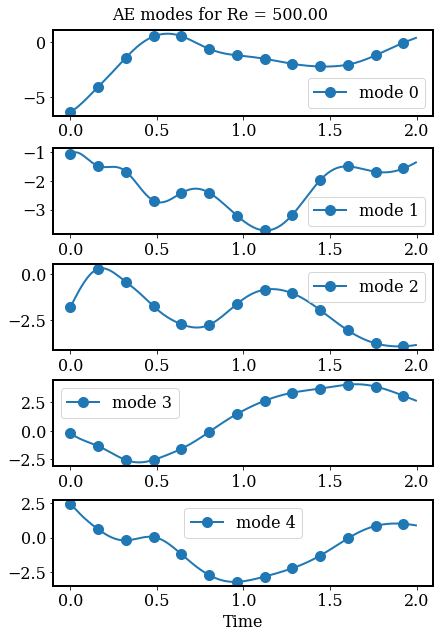

In [18]:
param_num = 3

def select_variable(param_num):
    p_indx = sum(list(Nt_train.values())[:param_num]); 
    encoded = encoded_u[p_indx:p_indx+Nt_train[param_num]]; ldim = latent_dim_u
    return encoded, ldim

def plot_latent_param_nums(param_num):

    num_rows = 5 
    fig, ax = plt.subplots(nrows=num_rows,ncols=1,figsize=(6,num_rows*1.75),constrained_layout=True)    

    for ix,comp in enumerate([param_num]):
        encoded, ldim = select_variable(comp)
        
        for i in range(num_rows):
            tt = ax[i].plot(times_offline[comp][:train_end[comp]+1:snap_incr],encoded[:,i],
                            label='mode %d'%i,marker='o',markevery=20)
            ax[i].legend()
        ax[i].set_xlabel('Time')  
        fig.suptitle('AE modes for %s = %.2f'%(flag, param_train[param_num]),fontsize=16)  


plot_latent_param_nums(param_num)


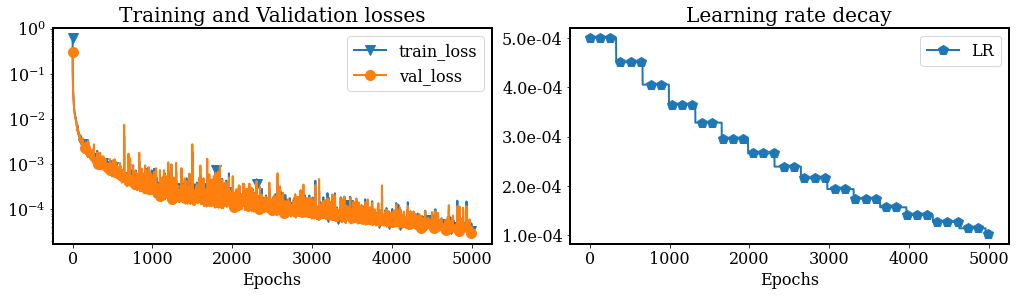

In [19]:
## Visualization losses and learning rate evolution
num_epochs_u = np.arange(epochs_u)

pu.plot_training(num_epochs_u, loss_u, vloss_u, lr_u)


In [20]:
### Predict using all high-fidelity data points 
### for parameter values in the training set

key = soln_names[0]
iparam = 3 
print("Testing AE predictions for %s = %f (parameter number = %d)"%(flag,param_train[iparam], iparam))
val = param_train[iparam]/p_max

u_test = snap_data[iparam][key][:,:snap_end[iparam]+1].T
u_shift_test = shifted_snap[iparam][key][:,:snap_end[iparam]+1].T
if scaling:
    u_test, u_shift_test, _, _ = du.data_scaler(u_test, u_shift_test, u_max, u_min)

u_test = np.hstack((u_test , val*np.ones((Nt[iparam],1)) ))
u_shift_test = np.hstack((u_shift_test , val*np.ones((Nt[iparam],1)) ))


encoded_u_test = u_autoencoder.encoder(u_test).numpy()
if augment_output:
    shift_u_test = u_autoencoder.shift(encoded_u_test).numpy()[:,:-1]
    decoded_u_test = u_autoencoder.decoder(encoded_u_test).numpy()[:,:-1]
else:
    shift_u_test = u_autoencoder.shift(encoded_u_test).numpy()
    decoded_u_test = u_autoencoder.decoder(encoded_u_test).numpy()


pred_shift = {}
pred_shift[key] = du.scaler_inverse(shift_u_test, u_max, u_min, scaling=scaling).T

pred_recon = {}
pred_recon[key] = du.scaler_inverse(decoded_u_test, u_max, u_min, scaling=scaling).T


Testing AE predictions for Re = 500.000000 (parameter number = 3)


Text(0.5, 0.98, 'Comparing AE predictions of true snapshots for Re = 500')

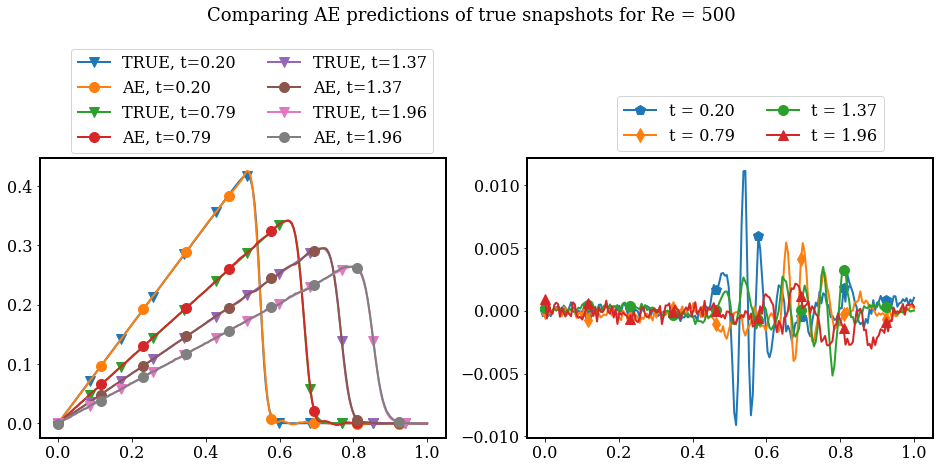

In [21]:
### Visualizing direct reconstruction using true decoder

fig = plt.figure(figsize=(16,7))
ky = soln_names[0]; 
np.random.seed(2021)
fig.tight_layout()
fig.subplots_adjust(top=0.68)

pu.compare_soln_1d(pred_recon,snap_data[iparam],times_offline[iparam],times_offline[iparam],
                   nodes,ky,flag='AE', tr_end = 0.98)
fig.suptitle("Comparing AE predictions of true snapshots for %s = %d"%(flag, param_train[iparam]),fontsize=18, y=0.98)



In [22]:
## Evaluate predictions on a dataset with unseen parameter value

new_test = True

if new_test:
    if flag == 'Re':
        test_param = np.random.choice(param_test)
        Re_new = test_param;
        new_data = np.load(os.path.join(data_dir,'Burgers1d_Nx200_Nt500_Re%.2f'%(Re_new)+'.npz'))
        
    
    print("Chosen parameter: %s = %f"%(flag, test_param))
    print("Loading pre-computed true snapshots -----\n")
    
    snap_new, times_new, nodes2, Nx2, Ny2, snap_start_new, snap_end_new = du.read_data(new_data, soln_names)
    Nt_new = times_new.size
    
    
    shifted_snap_new = {}
    for key in soln_names:
        tmp = snap_new[key][:,int(Nt_new//2)].reshape((Nn,-1))
        shifted_snap_new[key] = np.outer(tmp,np.ones(Nt_new))

    del new_data
    gc.collect()

    
    ky = soln_names[0]
    u_new = snap_new[ky][:,:snap_end_new+1].T
    u_shift_new = shifted_snap_new[ky][:,:snap_end_new+1].T
    if scaling:
        u_new, u_shift_new, _, _ = du.data_scaler(u_new, u_shift_new, u_max, u_min)

    u_new = np.hstack(( u_new, (test_param/p_max)*np.ones((Nt_new,1)) ))
    u_shift_new = np.hstack(( u_shift_new, (test_param/p_max)*np.ones((Nt_new,1)) ))

    
    encoded_u_new = u_autoencoder.encoder(u_new).numpy()
    if augment_output:
        shift_u_new = u_autoencoder.shift(encoded_u_new).numpy()[:,:-1]
        decoded_u_new = u_autoencoder.decoder(encoded_u_new).numpy()[:,:-1]
    else:
        shift_u_new = u_autoencoder.shift(encoded_u_new).numpy()
        decoded_u_new = u_autoencoder.decoder(encoded_u_new).numpy()

    pred_shift_new = {}
    pred_shift_new[ky] = du.scaler_inverse(shift_u_new, u_max, u_min, scaling=scaling).T

    pred_recon_new = {}
    pred_recon_new[ky] = du.scaler_inverse(decoded_u_new, u_max, u_min, scaling=scaling).T



Chosen parameter: Re = 400.000000
Loading pre-computed true snapshots -----

Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins


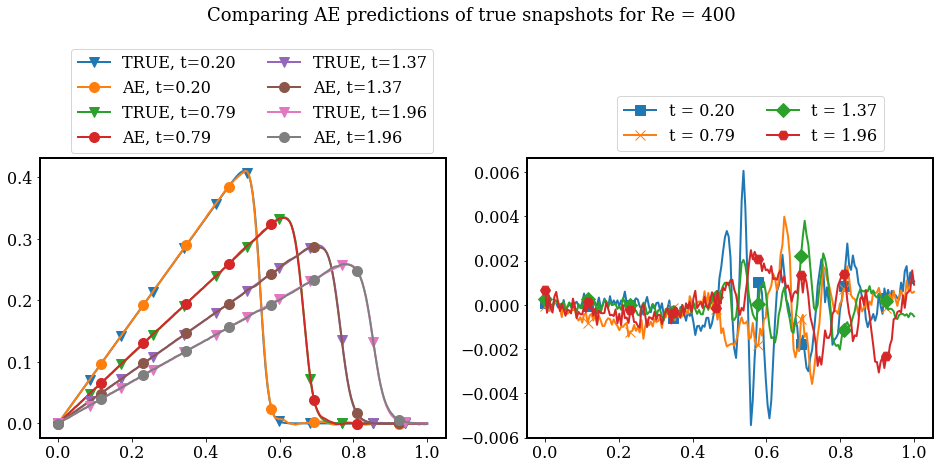

In [23]:
### Visualizing direct reconstruction using true decoder
if new_test:
    fig = plt.figure(figsize=(16,7))
    ky = soln_names[0]; 
    np.random.seed(2021)
    fig.tight_layout()
    fig.subplots_adjust(top=0.68)

    pu.compare_soln_1d(pred_recon_new,snap_new,times_new,times_new,nodes,ky,flag='AE',tr_end=.98)
    fig.suptitle("Comparing AE predictions of true snapshots for %s = %d"%(flag, test_param),fontsize=18, y=0.98)


